In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import userdata
github_token = userdata.get('zbotta_token')

token = github_token
username = "zbotta"
repo = 'reportingAgent'
%cd /content/drive/MyDrive/GitHub/{repo}

/content/drive/MyDrive/GitHub/reportingAgent


In [ ]:
!git config --global user.name "zbotta"
!git config --global user.email "zbotta@proton.me"
!git pull
!git checkout dev

Already up to date.
M	PoC/PoC-training-MBO.ipynb
M	app/datasets/training/smollm2_360m_onepara_lora/adapter/adapter_config.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-20/adapter_config.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-20/special_tokens_map.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-20/tokenizer.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-20/tokenizer_config.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-20/trainer_state.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-20/vocab.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-22/adapter_config.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-22/special_tokens_map.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-22/tokenizer.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-22/tokenizer_config.json
D	app/datasets/training/smollm2_360m_onep

# Testing models < 1B

In [ ]:
!pip -q install -U "transformers>=4.43" "accelerate>=0.33" bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00


## Qwen 2.5-0.5B-Instruct

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch, re

MODEL_ID = "Qwen/Qwen2.5-0.5B-Instruct"

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.float16
)

tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True, trust_remote_code=True)
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID, quantization_config=bnb_cfg, device_map="auto",
    torch_dtype=torch.float16, trust_remote_code=True
)

SYSTEM_INSTR = (
  "You are an incident-report generator.\n"
  "Language: {lang_directive}\n"
  "Write ONE SINGLE PARAGRAPH that includes ALL facts provided: what happened, when, where, who, how, why (root cause), and contingency/corrective actions. "
  "Constraints: neutral factual tone; no bullet points, no headings, no lists, no JSON; "
  "do NOT invent details; include only information given; output must be a single line with no line breaks; "
  "preserve numbers, times, names, and proper nouns; limit length to {max_chars} characters."
)

def extract_lang(user_text:str):
    # Optional inline directive, e.g. "Language: French"
    m = re.search(r"(?i)\bLanguage\s*:\s*([A-Za-zÀ-ÿ \-]+)", user_text)
    return m.group(1).strip() if m else None

def build_prompt(user_text, max_chars=400, lang="auto"):
    inline = extract_lang(user_text)
    if inline:
        lang_directive = f"write in {inline}"
    elif lang and lang.lower() != "auto":
        lang_directive = f"write in {lang}"
    else:
        lang_directive = "match the dominant language of the INPUT"

    return (
        SYSTEM_INSTR.format(lang_directive=lang_directive, max_chars=max_chars)
        + "\n\nINPUT:\n" + user_text.strip()
        + f"\n\nOUTPUT (single paragraph, ≤{max_chars} chars):"
    )

def _one_line(s: str) -> str:
    s = s.replace("\n", " ")
    return re.sub(r"\s+", " ", s).strip()

def _clip_paragraph(s: str, max_chars: int) -> str:
    if len(s) <= max_chars: return s
    clipped = s[:max_chars]
    end = max(clipped.rfind("."), clipped.rfind("!"), clipped.rfind("?"))
    return clipped[:end+1] if end > 50 else clipped  # prefer a sentence end

def generate_event_report(user_text, max_chars=400, max_new_tokens=260,
                          temperature=0.0, top_p=1.0, lang="auto"):
    prompt = build_prompt(user_text, max_chars=max_chars, lang=lang)
    messages = [{"role":"user","content":prompt}]
    input_ids = tok.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt").to(model.device)

    out = model.generate(
        input_ids, max_new_tokens=max_new_tokens,
        do_sample=(temperature>0), temperature=temperature, top_p=top_p,
        eos_token_id=tok.eos_token_id
    )
    gen_ids = out[0, input_ids.shape[-1]:]
    text = tok.decode(gen_ids, skip_special_tokens=True)
    text = _one_line(text)
    return _clip_paragraph(text, int(max_chars))




## Tests several languages

As Qwen model is multilingual, we can make a test of the output when the a language directive is done.

This could be interesting to include in the APP deployment.

#### ENGLISH

In [ ]:
# Smoke test (English, auto)
example = """What: Incorrect pH adjustment in buffer preparation
When: June 10, 2025, 9:15 AM
Where: Formulation Area, Production Building 2
Who: Rahul Mehta, Process Technician
How: pH meter not calibrated before use
Why: Technician skipped calibration step due to time pressure
ContingencyActions: Buffer batch discarded, technician retrained, equipment calibration logs reviewed"""
print(generate_event_report(example, lang="auto"))

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


On June 10, 2025, at 9:15 AM, during the process of preparing a buffer solution for a production batch, an incorrect pH adjustment was made. The pH meter had not been calibrated before its use, leading to an uncontrolled pH level. This oversight occurred after the technician had already started the preparation process without checking the calibration status.


#### FRENCH

In [ ]:
# Smoke test with your 5W1H-style input:
example = """What: Ajustement incorrect du pH lors de la préparation du tampon
When: 10 juin 2025, 9 h 15
Where: Zone de formulation, Bâtiment de production 2
Who: Rahul Mehta, technicien de procédé
How: pH-mètre non étalonné avant utilisation
Why: Le technicien a sauté l’étape d’étalonnage par manque de temps
ContingencyActions : Lot de tampons éliminé, technicien formé à nouveau, journaux d’étalonnage des équipements examinés"""
print(generate_event_report(example, temperature=0.0, lang="FRENCH"))

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Le pH incorrecte lors de la préparation du tampon a été détecté en juillet 2025, au sein de la zone de formation de la Bâtiment de Production 2, dans le Bâtiment de Production 2. L'ajout de pH-mètres n'était pas effectué avant cette utilisation. Le technicien de procédé, Rahul Mehta, s'est fait sauter l'étape d'étalonnage par manque de temps.


#### SPANISH

In [ ]:
example = """What: Ajuste incorrecto del pH en la preparación de la solución tampón
When: 10 de junio de 2025, 9:15 a. m.
Where: Área de Formulación, Edificio de Producción 2
Who: Rahul Mehta, Técnico de Procesos
How: El medidor de pH no se calibró antes de su uso
Why: El técnico omitió el paso de calibración por falta de tiempo
ContingencyActions : Se descartó el lote de solución tampón, se capacitó al técnico y se revisaron los registros de calibración del equipo"""
print(generate_event_report(example, temperature=0.0, lang="SPANISH"))

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Un ajuste incorrecto del pH en la preparación de la solución tampón ocurrió el 10 de junio de 2025, a las 9:15 a. m., en el área de Formulación del edificio de producción 2. El medidor de pH no se había calibrado antes de su uso. El técnico Rahul Mehta, un técnico de procesos, omitió el paso de calibración por falta de tiempo. La causa fue la falta de tiempo para realizar la calificación correcta.


In [ ]:
!pip install evaluate sentence_transformers numpy bert_score rouge_score

  Using cached rouge_score-0.1.2.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=23294bdcc1c45770cc05ac0f21d137877906e92c73c07d67a150ccd752b633c9
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
REF = "On June 10, 2025, at 9:15 AM in the Formulation Area (Production Building 2), technician Rahul Mehta used a non-calibrated pH meter to adjust the buffer, leading to an incorrect pH. The calibration step was skipped due to time pressure. The buffer batch was discarded, Rahul was retrained, and calibration logs were reviewed to prevent recurrence."
PRED = "On June 10, 2025, the buffer preparation process at the Production Building 2 of the Formulation Area encountered an incorrect pH adjustment. The pH meter had not been calibrated before its use, leading to an unadjusted pH value. This oversight resulted in a significant deviation from the desired pH range, causing a critical safety hazard."
PRED2 = "On June 10, 2025, at 9:15 AM, the buffer preparation process for batch number 4667 failed due to incorrect pH adjustment in the buffer preparation area of the production building. The technician, Rahul Mehta, had been tasked with preparing a buffer solution, but he had not performed a pH correction step as per his calibration schedule."
PRED3 = "On June 10, 2025, at 9:15 AM in the production area of Building 2, the buffer preparation team conducted batch #16, a solution containing sodium hydroxide, under the supervision of Master Technician Rahul Mehta, on process control measures. Initially, they expected pH readings within the specified range of 3.8 to 4.3. After checking, they noticed that the pH meters were uncalibrated."
PRED4 = "On June 10, 2025, at 9:15 AM, the buffer preparation process at the Production Building 2 of the Formulation Area encountered an incorrect pH adjustment in the buffer solution. The pH meter had not been calibrated before its use, leading to an uncontrolled pH level. This oversight resulted in a significant deviation from the desired pH range, causing a potential safety hazard."
#at 9:15 AM,
import sys, os
from pathlib import Path
sys.path.append(os.getcwd())
sys.path.append(os.getcwd() + '/app')

from app.mods.metricsEvaluator import MetricsEvaluator

me = MetricsEvaluator()

In [ ]:
me.set_cross_encoder_score(REF, [PRED])
print(me.get_cross_encoder_score())
me.set_cross_encoder_score(REF, [PRED2])
print(me.get_cross_encoder_score())
me.set_cross_encoder_score(REF, [PRED3])
print(me.get_cross_encoder_score())
me.set_cross_encoder_score(REF, [PRED4])
print(me.get_cross_encoder_score())

[1.]
[1.]
[1.]
[1.]


In [ ]:
me.set_bi_encoder_score(REF, [PRED], is_test_bench=False)
print(me.get_bi_encoder_score())
me.set_bi_encoder_score(REF, [PRED2])
print(me.get_bi_encoder_score())
me.set_bi_encoder_score(REF, [PRED3])
print(me.get_bi_encoder_score())
me.set_bi_encoder_score(REF, [PRED4])
print(me.get_bi_encoder_score())

[1.        0.7809284]
[1.         0.73692465]
[1.         0.72478765]
[1.        0.7777794]


In [ ]:
!python -V

Python 3.11.13


In [ ]:
!pip -q install -r requirements_colab.txt
!pip install --upgrade torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 100.6 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.8.0 which is incompatible.


# Grid Search on Tiny Models

## HuggingFaceTB/SmolLM2-360M-Instruct & HuggingFaceTB/SmolLM2-135M-Instruct



In [ ]:
!python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-135M-Instruct  --non-threaded --prompt_method A B C --max_workers 4 --dataset_filename pharma_dev_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True & python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-360M-Instruct  --non-threaded --prompt_method A B C --max_workers 4 --dataset_filename pharma_dev_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True

Se han truncado las últimas 5000 líneas del flujo de salida.
{'temperature': 1.3, 'top_p': 0.6, 'top_k': 50, 'max_new_tokens': 300.0, 'do_sample': True, 'repetition_penalty': 1.0}
Batches: 100% 1/1 [00:00<00:00, 34.80it/s]
Batches: 100% 1/1 [00:00<00:00, 65.23it/s]
Ref_row:63 & prompt_method=C: Generating text with the following parameters:
{'temperature': 1.3, 'top_p': 0.9, 'top_k': 50, 'max_new_tokens': 300.0, 'do_sample': True, 'repetition_penalty': 1.0}
Batches: 100% 1/1 [00:00<00:00, 64.69it/s]
Batches: 100% 1/1 [00:00<00:00, 61.22it/s]
Ref_row:64 & prompt_method=A: Generating text with the following parameters:
{'temperature': 0.3, 'top_p': 0.3, 'top_k': 50, 'max_new_tokens': 300.0, 'do_sample': True, 'repetition_penalty': 1.0}
08/20/2025 00:44:48 - mods.dataHandler - ERROR - Error while unpacking title or report from model output. Error: 1 validation error for Report
  Invalid JSON: EOF while parsing a string at line 1 column 653 [type=json_invalid, input_value='{"title": "What"

## Qwen/Qwen2.5-0.5B-Instruct

In [ ]:
!python app/reportParamGridSearch.py --model_id Qwen/Qwen2.5-0.5B-Instruct --non-threaded --max_workers  4 --prompt_method B C --dataset_filename pharma_dev_reports_collection.xlsx --start_idx 1 --end_idx 2  --temperature 0.7 1.3 --top_p 0.3 0.9 --top_k 50 --max_new_tokens 300 --do_sample True

2025-08-19 14:55:13.273844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755615313.308470   23223 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755615313.320179   23223 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755615313.348724   23223 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755615313.348754   23223 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755615313.348761   23223 computation_placer.cc:177] computation placer alr

In [ ]:
# KILL SESSION TO AVOID LEAVING SESSION ON AND CONSUME GPU UNITS

from google.colab import runtime
runtime.unassign()

# Training SmolLM2-360M-Instruct


## Plot training loss and metrics function


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
# =========================
# Post-training: PNG GRAPHS + CSV
# =========================

def plot_training_results(out_dir, _trainer):
  """ loads trainer log history and plots results and exports images """
  logs = pd.DataFrame(_trainer.state.log_history)
  if logs.empty:
      print("No logs recorded. Did logging_steps/eval_steps run?")
  else:
      os.makedirs(out_dir, exist_ok=True)
      log_csv = os.path.join(out_dir, "training_logs.csv")
      logs.to_csv(log_csv, index=False)
      print("Saved raw logs to:", log_csv)

      def safe_exp(x):
          try: return float(np.exp(x))
          except Exception: return np.nan

      train_df = logs[logs["loss"].notna()][["step","loss"]].copy()
      eval_df  = logs[logs["eval_loss"].notna()][["step","eval_loss"]].copy()
      lr_df    = logs[logs["learning_rate"].notna()][["step","learning_rate"]].copy()

      if not eval_df.empty: eval_df["eval_perplexity"] = eval_df["eval_loss"].map(safe_exp)
      if not train_df.empty: train_df["perplexity"] = train_df["loss"].map(safe_exp)

      def smooth(y, k=5):
          s = pd.Series(y); return s.rolling(k, min_periods=1, center=True).mean().values

      if not train_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(train_df["step"], train_df["loss"], label="train loss")
          plt.plot(train_df["step"], smooth(train_df["loss"], 7), label="train loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Training Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "train_loss.png")); plt.show()

      if not eval_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_loss"], label="eval loss")
          plt.plot(eval_df["step"], smooth(eval_df["eval_loss"], 3), label="eval loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Eval Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_loss.png")); plt.show()

          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_perplexity"], label="eval perplexity")
          plt.xlabel("Step"); plt.ylabel("Perplexity"); plt.title("Eval Perplexity")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_perplexity.png")); plt.show()

      if not lr_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(lr_df["step"], lr_df["learning_rate"], label="learning rate")
          plt.xlabel("Step"); plt.ylabel("LR"); plt.title("Learning Rate Schedule")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "learning_rate.png")); plt.show()

      if not eval_df.empty:
          best_row = eval_df.loc[eval_df["eval_loss"].idxmin()]
          print(f"Best eval loss: {best_row['eval_loss']:.4f} at step {int(best_row['step'])} "
                f"(perplexity ~ {best_row['eval_perplexity']:.2f})")
      if not train_df.empty:
          print(f"Final train loss: {train_df['loss'].iloc[-1]:.4f} at step {int(train_df['step'].iloc[-1])}")


## Training to minimize eval loss (NLL)

###  Dependencies

In [ ]:
!pip -q install -U "transformers>=4.43" "accelerate>=0.33" "datasets>=2.20" \
  "trl>=0.9.6" peft bitsandbytes evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
!pip -q install wandb

### Generic prompt

In [ ]:
import os

import wandb
IS_WANDB = False
if IS_WANDB:
  os.environ["WANDB_PROJECT"] = "accident-reporter"
  os.environ["WANDB_WATCH"] = "false"          # don't auto-log gradients
  os.environ["WANDB_SILENT"] = "true"
  from google.colab import userdata
  wand_db_token = userdata.get('wandb_token')
  wandb.login(key=wand_db_token)  # paste token (or set WANDB_API_KEY env var)
else:
  os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# === ONE-CELL QLoRA TRAINER: SmolLM2-360M-Instruct with trl.SFTConfig (no char clipping) ===
# Colab tip: Runtime -> Change runtime type -> GPU (T4)

import os, re, json, torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, EarlyStoppingCallback
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig

MODEL_ID = "HuggingFaceTB/SmolLM2-360M-Instruct"
TRAINING_DIR = "app/datasets/training"
OUT_DIR  = TRAINING_DIR + "/smollm2_360m_onepara_lora"

# 4-bit QLoRA base (tiny VRAM/RAM footprint)
bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb,
    torch_dtype=torch.float16,
    device_map="auto",
)
model.config.use_cache = False  # needed for grad checkpointing
# LoRA config (light but effective for ~500 rows)

# -------- Autodetect LoRA target modules (robust across archs) --------
def guess_lora_targets(m):
    names = set()
    for n, mod in m.named_modules():
        if isinstance(mod, torch.nn.Linear):
            names.add(n.split(".")[-1])
    # Prefer common llama/mistral-ish names if present
    preferred = [x for x in ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj",
                              "wi","wo","wq","wk","wv","out_proj","fc_in","fc_out"] if x in names]
    if preferred:
        return preferred
    # Fallback: all linear leaf names except lm_head
    return sorted(list({n for n in names if n != "lm_head"}))

target_modules = guess_lora_targets(model)
if not target_modules:
    raise RuntimeError("Could not find any target modules for LoRA — aborting to avoid no-grad training.")

# --- Load LoRa config  ---

peft_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    task_type="CAUSAL_LM"
)
model_lora_check = get_peft_model(model, peft_cfg)
model_lora_check.print_trainable_parameters()

ds = load_dataset("json", data_files={"train":TRAINING_DIR+"/train.jsonl","eval":TRAINING_DIR+"/eval.jsonl"})

print(f"DS_1: {ds}")


def one_line(s: str) -> str:
    s = str(s).replace("\n"," ")
    return re.sub(r"\s+"," ", s).strip()

INSTR = (
  "Write ONE SINGLE PARAGRAPH in English that includes ALL given facts: what happened, when, where, who, how, why "
  "(root cause), and contingency/corrective actions. Neutral tone. No bullet points, no headings, no lists, no JSON. "
  "DO NOT invent details. Output must be a single line (no line breaks)."
)
RESP_TMPL = "### Response:\n"  # SFTTrainer will mask everything before this marker as prompt
MAX_LEN = 1024

def find_subsequence(xs: list[int], ys: list[int]) -> int:
    """Return start index of ys inside xs, or -1 if not found."""
    n, m = len(xs), len(ys)
    if m == 0 or m > n: return -1
    for i in range(n - m + 1):
        if xs[i:i+m] == ys:
            return i
    return -1

def tokenize_and_mask(example: dict) -> dict:
    # Build full prompt -> "### Instruction ... INPUT ... ### Response:\n + target"
    text_in  = one_line(example["input"])
    text_out = one_line(example["target"])
    full = f"### Instruction:\n{INSTR}\n\nINPUT:\n{text_in}\n\n{RESP_TMPL}{text_out}"

    enc = tok(
        full,
        truncation=True,
        max_length=MAX_LEN,
        padding=False,             # pad later in collator
        return_tensors=None
    )
    input_ids = enc["input_ids"]
    labels    = input_ids.copy()

    # Locate response template and mask everything before the end of it
    rt_ids = tok(RESP_TMPL, add_special_tokens=False)["input_ids"]
    start = find_subsequence(input_ids, rt_ids)
    if start == -1:
        # If marker not found (rare after truncation), skip supervision on whole sample
        labels[:] = [-100] * len(labels)
    else:
        # Mask up to the end of the template tokens
        cut = start + len(rt_ids)
        labels[:cut] = [-100] * cut

    return {
        "input_ids": input_ids,
        "attention_mask": enc["attention_mask"],
        "labels": labels
    }

ds_tok = ds.map(tokenize_and_mask, remove_columns=ds["train"].column_names, desc="Tokenizing & masking")

# print(f"DS_2: {ds_tok}")

ds_tok = ds_tok.remove_columns([c for c in ds_tok["train"].column_names
                                if c not in ("input_ids","attention_mask","labels")])

# Make sure the dataset yields torch tensors with those keys
ds_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
# print(f"DS_3: {ds_tok}")

# Simple collator: pad inputs and labels to max length in batch
class CausalLMPadCollator:
    def __init__(self, tokenizer, label_pad_id=-100):
        self.tok = tokenizer
        self.label_pad_id = label_pad_id

    def __call__(self, features: list[dict]) -> dict[str, torch.Tensor]:
        max_len = max(len(f["input_ids"]) for f in features)
        input_ids, attn, labels = [], [], []
        for f in features:
            pad = max_len - len(f["input_ids"])
            input_ids.append(f["input_ids"] + [self.tok.pad_token_id] * pad)
            attn.append(f["attention_mask"] + [0] * pad)
            labels.append(f["labels"] + [self.label_pad_id] * pad)
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attn, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }

collator = CausalLMPadCollator(tok)

# --- SFTConfig (replaces TrainingArguments) ---
sft_cfg = SFTConfig(
    output_dir=OUT_DIR,
    num_train_epochs=4,                       # 2 epochs is plenty for ~500 rows
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,           # eff batch ~= 64
    gradient_checkpointing=False,             #Turn off checkpointing (needs a bit more VRAM on T4, but SmolLM2-360M QLoRA usually fits):
    learning_rate=1.5e-4,
    lr_scheduler_type="cosine",
    warmup_steps=3,
    load_best_model_at_end=True,
    # warmup_ratio = 0.03, # not a good idea if our data is short
    eval_strategy="epoch", # "steps"
    # eval_steps=100,
    save_strategy="epoch", # "steps"
    # save_steps=100,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,
    logging_steps=1,
    fp16=True,                                # T4-friendly
    optim="paged_adamw_8bit",
    max_grad_norm=0.5,
    max_length = MAX_LEN,                      # handled by SFTTrainer when set here
    # dataset_text_field="text", # Removed as data is already tokenized
    packing=False,
    remove_unused_columns=False,           # important for pre-tokenized inputs
    report_to="none"  # wandb
)

trainer = SFTTrainer(
    model=model,
    args=sft_cfg,                             # <-- using SFTConfig
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
    train_dataset=ds_tok["train"], # Use the tokenized dataset
    eval_dataset=ds_tok["eval"],   # Use the tokenized dataset
    data_collator = collator,
    peft_config=peft_cfg,
)
trainer.train()
final_metrics = trainer.evaluate()      # logs eval_loss into state.log_history
print("Final eval:", final_metrics)

# Save LoRA adapter
adapter_dir = f"{OUT_DIR}/adapter"
trainer.model.save_pretrained(adapter_dir)
tok.save_pretrained(adapter_dir)
print("Saved LoRA adapter to:", adapter_dir)

# ---------------------- Inference (no char clipping) ----------------------
# @torch.no_grad()
# def build_infer_prompt(user_text: str) -> str:
#     return "### Instruction:\n" + INSTR + "\n\nINPUT:\n" + one_line(user_text) + f"\n\n{RESP_TMPL}"

# @torch.no_grad()
# def generate_one_paragraph(user_text: str, max_new_tokens: int = 220,
#                            temperature: float = 0.0, top_p: float = 1.0) -> str:
#     prompt = build_infer_prompt(user_text)
#     ids = tok(prompt, return_tensors="pt").to(trainer.model.device)
#     out = trainer.model.generate(
#         **ids,
#         max_new_tokens=max_new_tokens,
#         do_sample=(temperature>0),
#         temperature=temperature,
#         top_p=top_p,
#         eos_token_id=tok.eos_token_id
#     )
#     gen = tok.decode(out[0], skip_special_tokens=True).split(RESP_TMPL, 1)[-1]
#     return one_line(gen)  # single line, but no length clipping

# # Quick check on a couple eval samples
# eval_split = load_dataset("json", data_files={"eval":TRAINING_DIR+"/eval.jsonl"})["eval"] # Load from the correct directory
# for i in range(min(3, len(eval_split))):
#     print("-", generate_one_paragraph(eval_split[i]["input"]))

# Log metrics in wandb
# wandb.log({
#   "eval/paragraphness": no_breaks / N,      # % with no '\n'
#   "eval/<=400_chars": within_len / N,
#   "eval/slot_coverage": slot_cov,           # if you compute it
# })
# del meval

plot_training_results(OUT_DIR,trainer)

trainable params: 4,341,760 || all params: 366,162,880 || trainable%: 1.1857
DS_1: DatasetDict({
    train: Dataset({
        features: ['input', 'target'],
        num_rows: 699
    })
    eval: Dataset({
        features: ['input', 'target'],
        num_rows: 70
    })
})


Tokenizing & masking:   0%|          | 0/699 [00:00<?, ? examples/s]

Tokenizing & masking:   0%|          | 0/70 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Truncating train dataset:   0%|          | 0/699 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/70 [00:00<?, ? examples/s]

KeyboardInterrupt: 

### Prompt with demo (prompt D as ref)


In [ ]:
!pip -q install -U "transformers>=4.43" "accelerate>=0.33" "datasets>=2.20" peft bitsandbytes trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 30.8 MB/s eta 0:00:00


#### Load training function and plot function

In [ ]:
# ==== ONE-CELL COLAB: wrap QLoRA + demo-prompt SFT into a function that returns the trainer ====
# Colab: Runtime > Change runtime type > GPU (T4)
import os, re, numpy as np, torch
from dataclasses import dataclass
from typing import Dict, List, Tuple
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, BitsAndBytesConfig, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer, SFTConfig

import matplotlib.pyplot as plt
import pandas as pd

# =========================
# Post-training: PNG GRAPHS + CSV
# =========================

def plot_training_results(out_dir, _trainer):
  """ loads trainer log history and plots results and exports images """
  logs = pd.DataFrame(_trainer.state.log_history)
  if logs.empty:
      print("No logs recorded. Did logging_steps/eval_steps run?")
  else:
      os.makedirs(out_dir, exist_ok=True)
      log_csv = os.path.join(out_dir, "training_logs.csv")
      logs.to_csv(log_csv, index=False)
      print("Saved raw logs to:", log_csv)

      def safe_exp(x):
          try: return float(np.exp(x))
          except Exception: return np.nan

      train_df = logs[logs["loss"].notna()][["step","loss"]].copy()
      eval_df  = logs[logs["eval_loss"].notna()][["step","eval_loss"]].copy()
      lr_df    = logs[logs["learning_rate"].notna()][["step","learning_rate"]].copy()

      if not eval_df.empty: eval_df["eval_perplexity"] = eval_df["eval_loss"].map(safe_exp)
      if not train_df.empty: train_df["perplexity"] = train_df["loss"].map(safe_exp)

      def smooth(y, k=5):
          s = pd.Series(y); return s.rolling(k, min_periods=1, center=True).mean().values

      if not train_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(train_df["step"], train_df["loss"], label="train loss")
          plt.plot(train_df["step"], smooth(train_df["loss"], 7), label="train loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Training Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "train_loss.png")); plt.show()

      if not eval_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_loss"], label="eval loss")
          plt.plot(eval_df["step"], smooth(eval_df["eval_loss"], 3), label="eval loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Eval Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_loss.png")); plt.show()

          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_perplexity"], label="eval perplexity")
          plt.xlabel("Step"); plt.ylabel("Perplexity"); plt.title("Eval Perplexity")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_perplexity.png")); plt.show()

      if not lr_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(lr_df["step"], lr_df["learning_rate"], label="learning rate")
          plt.xlabel("Step"); plt.ylabel("LR"); plt.title("Learning Rate Schedule")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "learning_rate.png")); plt.show()

      if not eval_df.empty:
          best_row = eval_df.loc[eval_df["eval_loss"].idxmin()]
          print(f"Best eval loss: {best_row['eval_loss']:.4f} at step {int(best_row['step'])} "
                f"(perplexity ~ {best_row['eval_perplexity']:.2f})")
      if not train_df.empty:
          print(f"Final train loss: {train_df['loss'].iloc[-1]:.4f} at step {int(train_df['step'].iloc[-1])}")


def train_demo_qlora(
    sft_cfg: SFTConfig,
    MODEL_ID: str = "HuggingFaceTB/SmolLM2-360M-Instruct",
    OUT_DIR: str = "smollm2_demo_qlora",
    DEMO_PROB: float = 1.0,
    DATASET_ID = "zBotta/traffic-accidents-reports-800",
):
    """
    Fine-tune MODEL_ID with QLoRA on DATASET_ID using a demo-wired prompt.
    Dataset format: splits 'train' and 'eval', each row has:
      - 'input': string "What: ..., When: ..., Where: ..., Who: ..., How: ..., Why: ..., ContingencyActions: ..."
      - 'target': one-paragraph report (string)
    Returns: SFTTrainer (trained)
    """
    from transformers import AutoModelForCausalLM # Moved import inside function

    MAX_LEN   = 1024
    RESP_TMPL = "### Response:\n"
    INSTR = (
      """
      You are a reporting agent.
      You task is to create a report when provided the what, when, why, who, how and where questions about the events.
      You are also given information about the contingency actions regarding the event.

      Guidelines:
      - Generate only one report given the informations about the event
      - Generate the report as text in one paragraph
      - It is important to focus on accuracy and coherence when generating the report so that the description content matches the information provided (what, when, where, who, how , why, contingency actions).
        If an information is not provided in (what, when, where, who, how , why, contingency actions), it must not be part of the generated text description.
      """
    )

    def one_line(s: str) -> str:
        return re.sub(r"\s+"," ", str(s).replace("\n"," ")).strip()

    # ---- Load dataset (must have train/eval with 'input' and 'target') ----
    raw_any = load_dataset(DATASET_ID)
    assert "train" in raw_any and "eval" in raw_any, "Dataset must have 'train' and 'eval' splits."
    ds_raw = DatasetDict(train=raw_any["train"], eval=raw_any["eval"])

    print(f"train len before validation: {len(ds_raw['train'])}")
    print(f"eval  len before validation: {len(ds_raw['eval'])}")

    def valid_row(rec: Dict) -> bool:
        return bool(str(rec.get("input","")).strip()) and bool(str(rec.get("target","")).strip())

    ds_raw = DatasetDict(
        train=ds_raw["train"].filter(valid_row),
        eval =ds_raw["eval"].filter(valid_row)
    )

    print(f"train len after validation: {len(ds_raw['train'])}")
    print(f"eval  len after validation: {len(ds_raw['eval'])}")

    # Build demo pool from TRAIN
    demo_pool: List[Tuple[str,str]] = [(one_line(ex["input"]), one_line(ex["target"])) for ex in ds_raw["train"]]

    # ---- Prompt builders ----
    def build_prompt_with_demo(demo_in: str, demo_out: str, current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input-example:\n" + demo_in + "\n\n" +
            "### Output-example:\n" + one_line(demo_out) + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

    def build_prompt_no_demo(current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

# ------------------ Tokenizer ------------------
    tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
    if tok.pad_token_id is None: tok.pad_token = tok.eos_token

    # Map rows -> prompt first (kept), then target fills the remaining budget
    def add_demo_and_tokenize(example, idx):
        cur_in  = one_line(example["input"])
        cur_out = one_line(example["target"])

        use_demo = (np.random.rand() < DEMO_PROB) and (len(demo_pool) > 1)
        if use_demo:
            demo_idx = (idx + 1) % len(demo_pool)  # simple different row
            demo_in, demo_out = demo_pool[demo_idx]
            prompt = build_prompt_with_demo(demo_in, demo_out, cur_in)
        else:
            prompt = build_prompt_no_demo(cur_in)

        # 1) tokenize prompt first (so the response marker is always inside)
        prom = tok(prompt, add_special_tokens=True, truncation=True, max_length=MAX_LEN, padding=False)
        prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        # If prompt alone overflows, fall back to no-demo minimal prompt
        if len(prompt_ids) >= MAX_LEN - 4:
            prompt = build_prompt_no_demo(cur_in)
            prom = tok(prompt, add_special_tokens=True, truncation=True, max_length=MAX_LEN, padding=False)
            prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        # 2) tokenize target to fill remaining budget
        budget = MAX_LEN - len(prompt_ids)
        targ = tok(cur_out, add_special_tokens=False, truncation=True, max_length=max(1, budget), padding=False)
        target_ids = targ["input_ids"][:max(0, budget)]

        # assemble & ensure ≥1 supervised token
        input_ids = prompt_ids + target_ids
        attention_mask = attn_prompt + [1]*len(target_ids)
        labels = [-100]*len(prompt_ids) + target_ids
        if not target_ids:  # ensure graph has grad
            eos = tok.eos_token_id
            input_ids += [eos]; attention_mask += [1]; labels += [eos]

        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


    ds_tok = ds_raw.map(
        add_demo_and_tokenize,
        with_indices=True,
        remove_columns=ds_raw["train"].column_names,
        desc="Building demo prompts + tokenizing"
    )

    ds_tok = ds_tok.remove_columns([c for c in ds_tok["train"].column_names
                                if c not in ("input_ids","attention_mask","labels")])

    # Make sure the dataset yields torch tensors with those keys
    ds_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

    # ---- QLoRA base model ----
    bnb4 = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.float16
    )
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        quantization_config=bnb4,
        torch_dtype=torch.float16,
        device_map="auto",
    )
    model.config.use_cache = False  # better with gradient checkpointing

    # LoRA adapters

    # -------- Autodetect LoRA target modules (robust across archs) --------
    def guess_lora_targets(m):
        names = set()
        for n, mod in m.named_modules():
            if isinstance(mod, torch.nn.Linear):
                names.add(n.split(".")[-1])
        # Prefer common llama/mistral-ish names if present
        preferred = [x for x in ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj",
                                 "wi","wo","wq","wk","wv","out_proj","fc_in","fc_out"] if x in names]
        if preferred:
            return preferred
        # Fallback: all linear leaf names except lm_head
        return sorted(list({n for n in names if n != "lm_head"}))

    target_modules = guess_lora_targets(model)
    if not target_modules:
        raise RuntimeError("Could not find any target modules for LoRA — aborting to avoid no-grad training.")

    # --- Load LoRa config  ---

    lora_cfg = LoraConfig(
        r=8, lora_alpha=16, lora_dropout=0.05,
        target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
        task_type="CAUSAL_LM"
    )
    model_lora_check = get_peft_model(model, lora_cfg)
    model_lora_check.print_trainable_parameters()

    # ---- Collator ----
    @dataclass
    class CausalLMPadCollator:
        pad_id: int
        def __call__(self, feats: List[Dict]):
            maxlen = max(len(f["input_ids"]) for f in feats)
            def pad(seq, v): return seq + [v]*(maxlen-len(seq))
            return {
                "input_ids": torch.tensor(
                    [pad(f["input_ids"], self.pad_id) for f in feats]
                ),
                "attention_mask": torch.tensor(
                    [pad(f["attention_mask"], 0) for f in feats]
                ),
                "labels": torch.tensor([pad(f["labels"], -100) for f in feats]),
            }
    collator = CausalLMPadCollator(tok.pad_token_id)

    # ---- Trainer (TRL SFT) ----


    trainer = SFTTrainer(
        model=model,
        args=sft_cfg,
        peft_config=lora_cfg,
        train_dataset=ds_tok["train"],
        eval_dataset=ds_tok["eval"],
        data_collator=collator,
        callbacks=[EarlyStoppingCallback(
            early_stopping_patience=2,       # try 2–3
            early_stopping_threshold=1e-3    # tiny but meaningful improvement
        )],
    )

    trainer.train()
    import json, os
    from peft import PeftModel
    from transformers import AutoModelForCausalLM

    # ---- Save LoRA adapter (primary artifact) ----
    adapter_dir = f"{OUT_DIR}/adapter"
    os.makedirs(adapter_dir, exist_ok=True)
    # Use the trainer's model to ensure we save the PEFT adapter
    trainer.model.save_pretrained(adapter_dir)
    tok.save_pretrained(adapter_dir)
    print("Saved LoRA adapter to:", adapter_dir)

    # ---- Build a merged FP16 checkpoint for simple from_pretrained() use ----
    # Reload the *base* in FP16 (NOT 4-bit), apply adapter, then merge.


    merged_dir = f"{OUT_DIR}/merged-fp16"
    os.makedirs(merged_dir, exist_ok=True)

    base_fp16 = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,   # merge target dtype
        device_map="cpu"             # CPU is fine for 360M; avoids extra VRAM
    )
    peft_model = PeftModel.from_pretrained(base_fp16, adapter_dir)
    merged = peft_model.merge_and_unload()
    merged.save_pretrained(merged_dir, safe_serialization=True)
    tok.save_pretrained(merged_dir)

    # (Optional) provide a default generation_config for convenience

    gen_cfg = {
        "max_new_tokens": 300,
        "do_sample": True,
        "eos_token_id": tok.eos_token_id,
        "pad_token_id": tok.pad_token_id
    }
    with open(os.path.join(merged_dir, "generation_config.json"), "w") as f:
        json.dump(gen_cfg, f)

    print("Merged FP16 model saved to:", merged_dir)
    print("You can now load it with:\n"
          "  AutoModelForCausalLM.from_pretrained(merged_dir_or_hub_id, torch_dtype=torch.float16, device_map='auto')")

    return trainer

# --- Example usage (uncomment to run) ---
# trainer = train_demo_qlora(
#     MODEL_ID="HuggingFaceTB/SmolLM2-360M-Instruct",
#     OUT_DIR="smollm2_360m_demo_qlora",
#     DEMO_PROB=1.0
# )

#### Execute function with given model training ID - 800 rows

##### SmolLM2-360M-Instruct


train len before validation: 629
eval  len before validation: 70
train len after validation: 629
eval  len after validation: 70
trainable params: 4,341,760 || all params: 366,162,880 || trainable%: 1.1857


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Saved LoRA adapter to: app/datasets/training/smollm2_360m_demo_1para_qlora/adapter
Merged FP16 model saved to: app/datasets/training/smollm2_360m_demo_1para_qlora/merged-fp16
You can now load it with:
  AutoModelForCausalLM.from_pretrained(merged_dir_or_hub_id, torch_dtype=torch.float16, device_map='auto')
Saved raw logs to: app/datasets/training/smollm2_360m_demo_1para_qlora/training_logs.csv


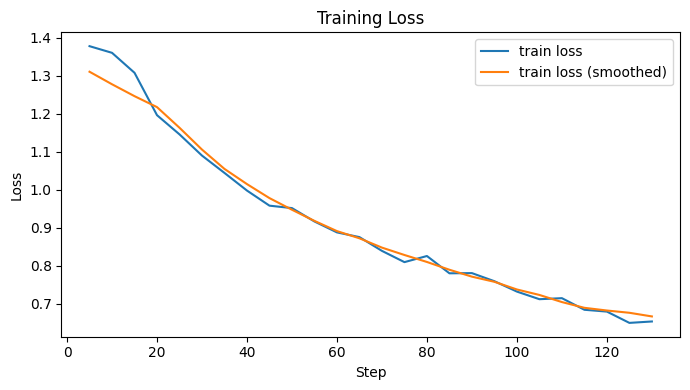

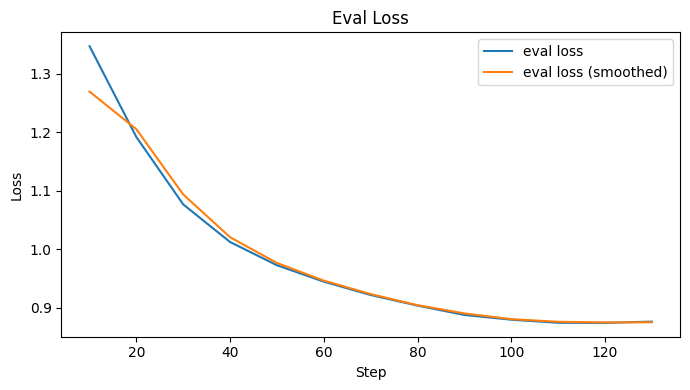

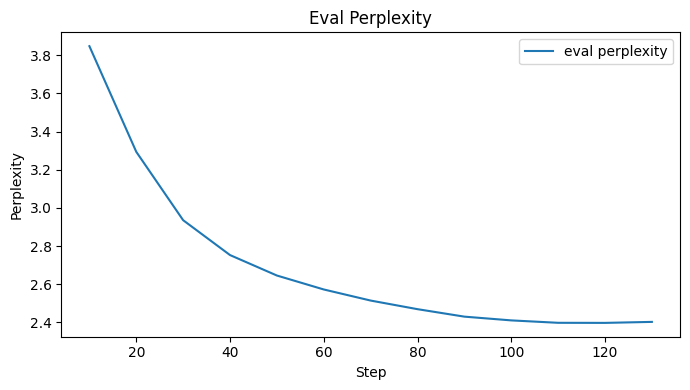

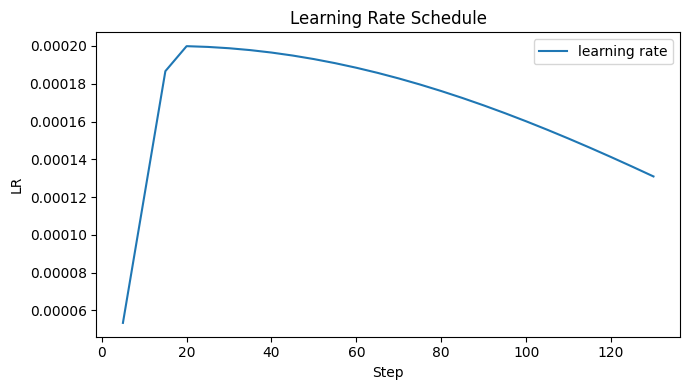

Best eval loss: 0.8745 at step 120 (perplexity ~ 2.40)
Final train loss: 0.6536 at step 130


In [ ]:
# Login to HG to download dataset and push trained model
from huggingface_hub import login
from google.colab import userdata
hf_token = userdata.get('hf_token')
login(token=hf_token)

TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/smollm2_360m_demo_1para_qlora"

sft_cfg = SFTConfig(
    output_dir=out_dir,
    num_train_epochs=30,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,        # eff batch ~64
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    weight_decay=0.05,
    logging_steps=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,
    gradient_checkpointing=False,             #Turn off checkpointing (needs a bit more VRAM on T4, but SmolLM2-360M QLoRA usually fits):
    optim="paged_adamw_8bit",
    max_length=1024,
    remove_unused_columns=False,           # keep tokenized fields
    report_to="none", #wandb
)

trainer = train_demo_qlora(
    sft_cfg=sft_cfg,
    MODEL_ID="HuggingFaceTB/SmolLM2-360M-Instruct",
    OUT_DIR=out_dir,
    DEMO_PROB=1.0,
    DATASET_ID="zBotta/traffic-accidents-reports-800",
)
plot_training_results(out_dir,trainer)

##### SmmolLM2-135M-Instruct

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/225k [00:00<?, ?B/s]

data/eval-00000-of-00001.parquet:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/40.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/629 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/70 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

train len before validation: 629
eval  len before validation: 70


Filter:   0%|          | 0/629 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

train len after validation: 629
eval  len after validation: 70


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

Building demo prompts + tokenizing:   0%|          | 0/629 [00:00<?, ? examples/s]

Building demo prompts + tokenizing:   0%|          | 0/70 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

trainable params: 2,442,240 || all params: 136,957,248 || trainable%: 1.7832


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Truncating train dataset:   0%|          | 0/629 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/70 [00:00<?, ? examples/s]

Saved LoRA adapter to: app/datasets/training/smollm2_135m_demo_1para_qlora/adapter
Merged FP16 model saved to: app/datasets/training/smollm2_135m_demo_1para_qlora/merged-fp16
You can now load it with:
  AutoModelForCausalLM.from_pretrained(merged_dir_or_hub_id, torch_dtype=torch.float16, device_map='auto')
Saved raw logs to: app/datasets/training/smollm2_135m_demo_1para_qlora/training_logs.csv


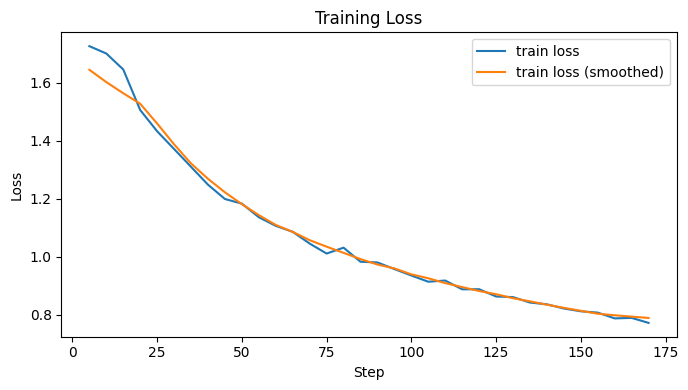

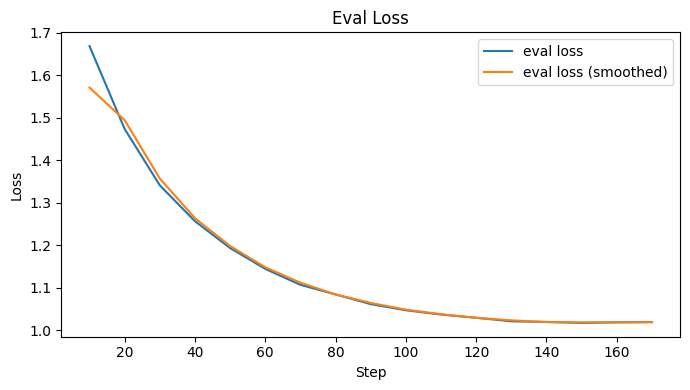

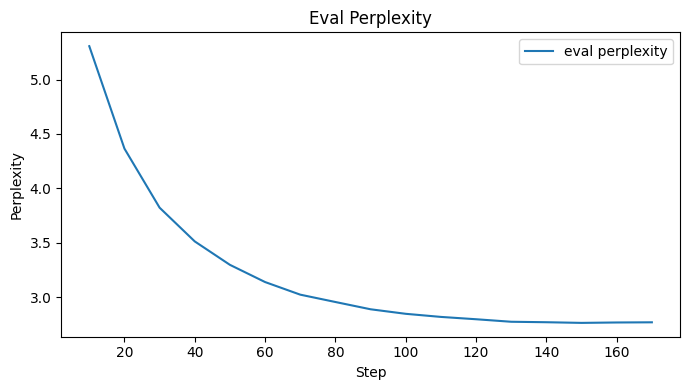

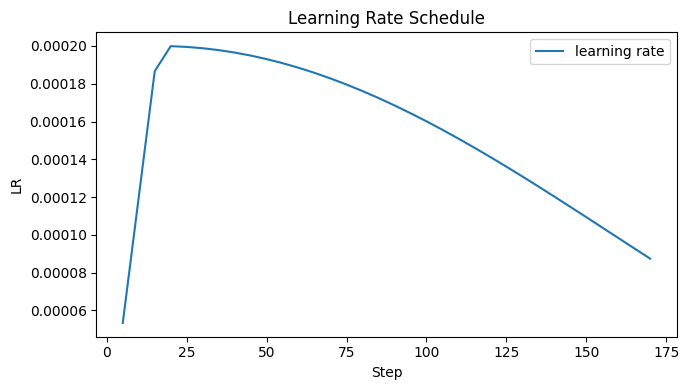

Best eval loss: 1.0168 at step 150 (perplexity ~ 2.76)
Final train loss: 0.7719 at step 170


In [ ]:
# Login to HG to download dataset and push trained model
from huggingface_hub import login
from google.colab import userdata
hf_token = userdata.get('hf_token')
login(token=hf_token)

TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/smollm2_135m_demo_1para_qlora"

sft_cfg = SFTConfig(
    output_dir=out_dir,
    num_train_epochs=30,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,        # eff batch ~64
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    weight_decay=0.05,
    logging_steps=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,
    gradient_checkpointing=False,             #Turn off checkpointing (needs a bit more VRAM on T4, but SmolLM2-360M QLoRA usually fits):
    optim="paged_adamw_8bit",
    max_length=1024,
    remove_unused_columns=False,           # keep tokenized fields
    report_to="none", #wandb
)

trainer = train_demo_qlora(
    sft_cfg=sft_cfg,
    MODEL_ID="HuggingFaceTB/SmolLM2-135M-Instruct",
    OUT_DIR=out_dir,
    DEMO_PROB=1.0,
    DATASET_ID="zBotta/traffic-accidents-reports-800",
)
plot_training_results(out_dir,trainer)

#### Push trained model to HF

##### SmolLM2-360M-Instruct

In [ ]:
repo_id = "zBotta/smollm2-accident-reporter-360m"
TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/smollm2_360m_demo_1para_qlora"

from huggingface_hub import HfApi, create_repo, upload_folder, login
merged_dir = f"{out_dir}/merged-fp16" # we should push the adapter model
from google.colab import userdata
hf_token = userdata.get('hf_token')

login(token=hf_token)

api = HfApi(token=hf_token)
try:
  api.create_repo(repo_id, private=False, repo_type="model")
except Exception as e:
  print(f"Repo model {repo_id} already created")
upload_folder(folder_path=merged_dir, repo_id=repo_id, repo_type="model")
print("Pushed:", repo_id)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...qlora/merged-fp16/model.safetensors:   6%|5         | 41.9MB /  724MB            

Pushed: zBotta/smollm2-accident-reporter-360m


##### SmolLM2-135M-Instruct

In [ ]:
repo_id = "zBotta/smollm2-accident-reporter-135m"
TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/smollm2_135m_demo_1para_qlora"

from huggingface_hub import HfApi, create_repo, upload_folder, login
merged_dir = f"{out_dir}/merged-fp16" # we should push the adapter model
from google.colab import userdata
hf_token = userdata.get('hf_token')

login(token=hf_token)

api = HfApi(token=hf_token)
try:
  api.create_repo(repo_id, private=False, repo_type="model")
except Exception as e:
  print(f"Repo model {repo_id} already created")
upload_folder(folder_path=merged_dir, repo_id=repo_id, repo_type="model")
print("Pushed:", repo_id)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...qlora/merged-fp16/model.safetensors:   6%|6         | 16.8MB /  269MB            

Pushed: zBotta/smollm2-accident-reporter-135m


#### Execute function with given model training ID - 5k rows

##### SmolLM2-360M on 5k

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.53M [00:00<?, ?B/s]

data/eval-00000-of-00001.parquet:   0%|          | 0.00/172k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/40.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4499 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/101 [00:00<?, ? examples/s]

train len before validation: 4499
eval  len before validation: 500


Filter:   0%|          | 0/4499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

train len after validation: 4499
eval  len after validation: 500


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

Building demo prompts + tokenizing:   0%|          | 0/4499 [00:00<?, ? examples/s]

Building demo prompts + tokenizing:   0%|          | 0/500 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

trainable params: 4,341,760 || all params: 366,162,880 || trainable%: 1.1857


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Truncating train dataset:   0%|          | 0/4499 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Saved LoRA adapter to: app/datasets/training/smollm2_360m_demo_1para_qlora_5k/adapter
Merged FP16 model saved to: app/datasets/training/smollm2_360m_demo_1para_qlora_5k/merged-fp16
You can now load it with:
  AutoModelForCausalLM.from_pretrained(merged_dir_or_hub_id, torch_dtype=torch.float16, device_map='auto')
Saved raw logs to: app/datasets/training/smollm2_360m_demo_1para_qlora_5k/training_logs.csv


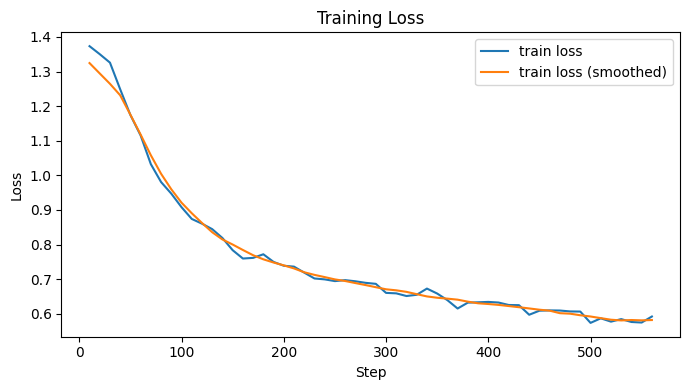

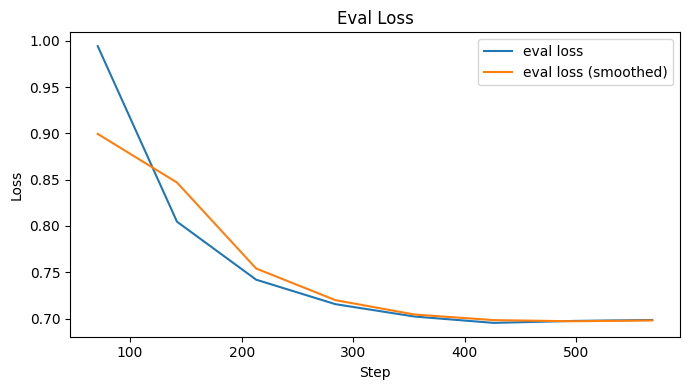

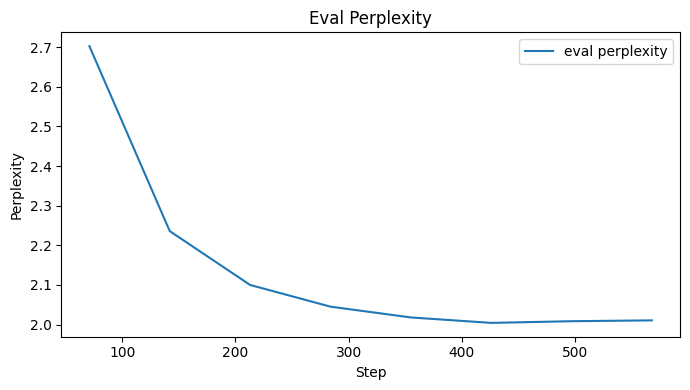

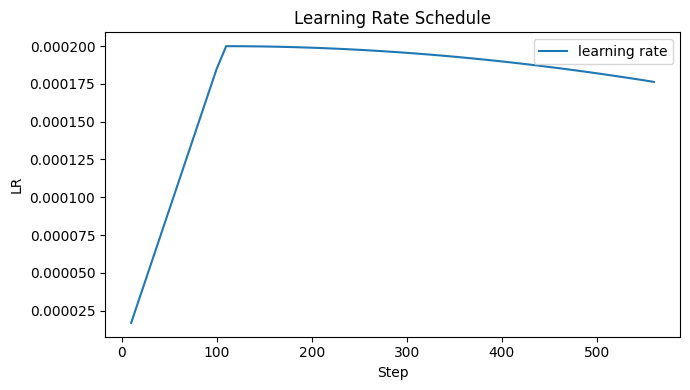

Best eval loss: 0.6953 at step 426 (perplexity ~ 2.00)
Final train loss: 0.5922 at step 560


In [ ]:
# Login to HG to download dataset and push trained model
from huggingface_hub import login
from google.colab import userdata
hf_token = userdata.get('hf_token')
login(token=hf_token)

TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/smollm2_360m_demo_1para_qlora_5k"

from trl import SFTConfig

sft_cfg = SFTConfig(
    output_dir=out_dir,
    num_train_epochs=30,                         # try 3 if still improving
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,             # eff batch = 64
    learning_rate=2e-4,                         # 8e-5 if r=16
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    weight_decay=0.05,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,                     # keep AMP off with paged_adamw_8bit
    optim="paged_adamw_8bit",
    max_length=1024,
    gradient_checkpointing=False,
    remove_unused_columns=False,
    report_to="none",
)

trainer = train_demo_qlora(
    sft_cfg=sft_cfg,
    MODEL_ID="HuggingFaceTB/SmolLM2-360M-Instruct",
    OUT_DIR=out_dir,
    DEMO_PROB=1.0,
    DATASET_ID="zBotta/traffic-accidents-reports-5k",
)
plot_training_results(out_dir,trainer)

##### SmolLM2-135M-Ins on 5k

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.53M [00:00<?, ?B/s]

data/eval-00000-of-00001.parquet:   0%|          | 0.00/172k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/40.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4499 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/101 [00:00<?, ? examples/s]

train len before validation: 4499
eval  len before validation: 500


Filter:   0%|          | 0/4499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

train len after validation: 4499
eval  len after validation: 500


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

Building demo prompts + tokenizing:   0%|          | 0/4499 [00:00<?, ? examples/s]

Building demo prompts + tokenizing:   0%|          | 0/500 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

trainable params: 2,442,240 || all params: 136,957,248 || trainable%: 1.7832


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Truncating train dataset:   0%|          | 0/4499 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Saved LoRA adapter to: app/datasets/training/smollm2_135m_5k_demo_1para_qlora/adapter
Merged FP16 model saved to: app/datasets/training/smollm2_135m_5k_demo_1para_qlora/merged-fp16
You can now load it with:
  AutoModelForCausalLM.from_pretrained(merged_dir_or_hub_id, torch_dtype=torch.float16, device_map='auto')
Saved raw logs to: app/datasets/training/smollm2_135m_5k_demo_1para_qlora/training_logs.csv


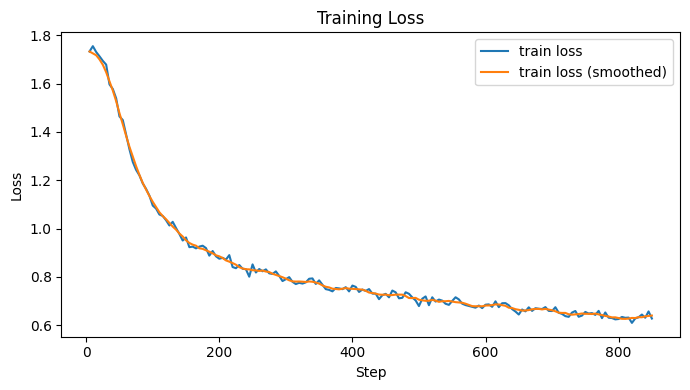

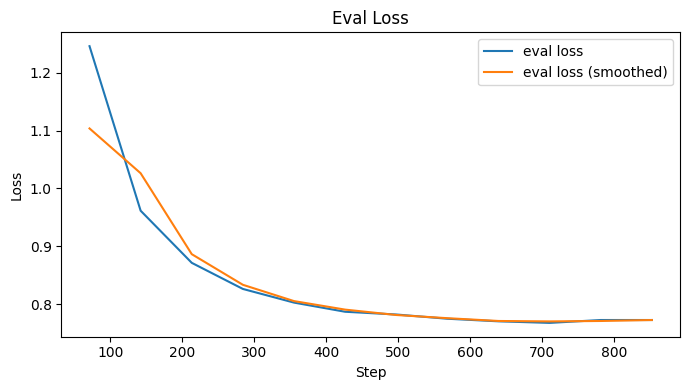

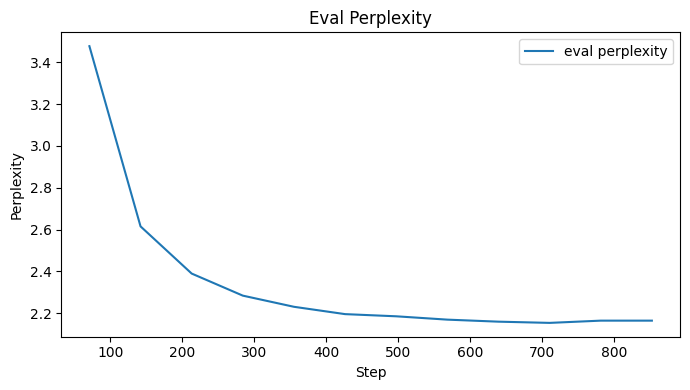

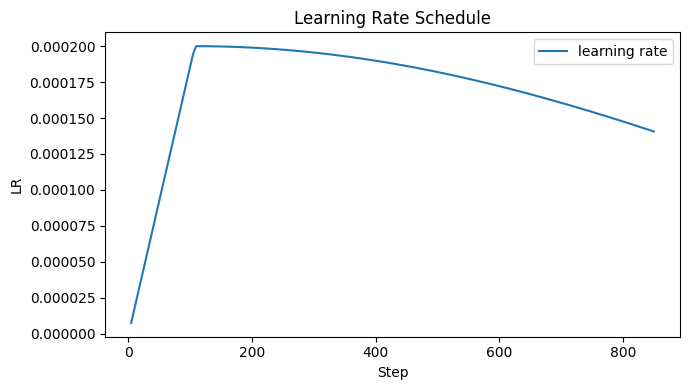

Best eval loss: 0.7674 at step 710 (perplexity ~ 2.15)
Final train loss: 0.6279 at step 850


In [ ]:
# Login to HG to download dataset and push trained model
from huggingface_hub import login
from google.colab import userdata
hf_token = userdata.get('hf_token')
login(token=hf_token)

TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/smollm2_135m_5k_demo_1para_qlora"

sft_cfg = SFTConfig(
    output_dir=out_dir,
    num_train_epochs=30,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,        # eff batch ~64
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    weight_decay=0.05,
    logging_steps=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,
    gradient_checkpointing=False,             #Turn off checkpointing (needs a bit more VRAM on T4, but SmolLM2-360M QLoRA usually fits):
    optim="paged_adamw_8bit",
    max_length=1024,
    remove_unused_columns=False,           # keep tokenized fields
    report_to="none", #wandb
)
trainer = train_demo_qlora(
    sft_cfg=sft_cfg,
    MODEL_ID="HuggingFaceTB/SmolLM2-135M-Instruct",
    OUT_DIR=out_dir,
    DEMO_PROB=1.0,
    DATASET_ID="zBotta/traffic-accidents-reports-5k",
)
plot_training_results(out_dir,trainer)

#### Push trained model to HF

##### SmolLM2-360M-Ins

In [ ]:
repo_id = "zBotta/smollm2-accident-reporter-360m-5k"

from huggingface_hub import HfApi, create_repo, upload_folder, login
merged_dir = f"{out_dir}/merged-fp16" # we should push the adapter model
from google.colab import userdata
hf_token = userdata.get('hf_token')

login(token=hf_token)

api = HfApi(token=hf_token)
try:
  api.create_repo(repo_id, private=False, repo_type="model")
except Exception as e:
  print(f"Repo model {repo_id} already created")
upload_folder(folder_path=merged_dir, repo_id=repo_id, repo_type="model")
print("Pushed:", repo_id)

Repo model zBotta/smollm2-accident-reporter-360m-5k already created


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ra_5k/merged-fp16/model.safetensors:   2%|2         | 16.8MB /  724MB            

Pushed: zBotta/smollm2-accident-reporter-360m-5k


##### SmolLM2-135M-Ins

In [ ]:
repo_id = "zBotta/smollm2-accident-reporter-135m-5k"
TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/smollm2_135m_5k_demo_1para_qlora"

from huggingface_hub import HfApi, create_repo, upload_folder, login
merged_dir = f"{out_dir}/merged-fp16" # we should push the adapter model
from google.colab import userdata
hf_token = userdata.get('hf_token')

login(token=hf_token)

api = HfApi(token=hf_token)
try:
  api.create_repo(repo_id, private=False, repo_type="model")
except Exception as e:
  print(f"Repo model {repo_id} already created")
upload_folder(folder_path=merged_dir, repo_id=repo_id, repo_type="model")
print("Pushed:", repo_id)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...qlora/merged-fp16/model.safetensors:   6%|6         | 16.8MB /  269MB            

Pushed: zBotta/smollm2-accident-reporter-135m-5k


In [ ]:
# KILL SESSION TO AVOID LEAVING SESSION ON AND CONSUME GPU UNITS

from google.colab import runtime
runtime.unassign()

### Free up VRAM

In [ ]:
# Free VRAM after training (safe cleanup)
import gc, torch

def free_vram(trainer=None, *extra_objs):
    # 1) ask Accelerate to release buffers (if present)
    try:
        if trainer is not None and hasattr(trainer, "accelerator"):
            trainer.accelerator.wait_for_everyone()
            trainer.accelerator.free_memory()
    except Exception as e:
        print("accelerator.free_memory() skipped:", e)

    # 2) move big models to CPU so CUDA refs can drop
    for obj in (trainer,)+extra_objs if trainer is not None else extra_objs:
        try:
            m = getattr(obj, "model", None) or obj
            if hasattr(m, "to"):
                m.to("cpu")
        except Exception:
            pass

    # 3) drop strong references
    for name in list(globals().keys()):
        # keep notebook/system internals
        if name.startswith(("__", "_", "In", "Out")):
            continue
        try:
            val = globals()[name]
            if hasattr(val, "to") or hasattr(val, "parameters"):  # models, trainers, tokenizers (sometimes hold buffers)
                globals()[name] = None
        except Exception:
            pass

    # 4) garbage-collect Python objects and release CUDA caches
    gc.collect()
    try:
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.synchronize()
    except Exception:
        pass

# Delete trainer data
free_vram(trainer)                   # if you only have the trainer


NameError: name 'trainer' is not defined

## Testing ce_sim/be_sim as metric for training

We are going to:
- use the existing **MetricsEvaluator** class
- Create a compute_metrics function to calculate be_sim and ce_sim on each generated text at the end of the epoch
- **NOTA**: It is really slow, we are going to keep with loss eval



In [ ]:
!pip -q install sentence_transformers bert-score evaluate rouge_score

In [ ]:
pred = "On June 10, 2025, at 9:15 AM in the Formulation Area (Production Building 2), technician Rahul Mehta used a non-calibrated pH meter to adjust the buffer, leading to an incorrect pH."
ref = "In the Formulation Area I had a problem with the ph"
meval.set_cross_encoder_score(ref, [pred], )
print(meval.get_cross_encoder_score())

[0.3631974 1.0000001 0.3631974]


In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder
import numpy as np
import re
from app.mods.metricsEvaluator import MetricsEvaluator

meval = MetricsEvaluator()

#### Training for maximizing be_sim

In [ ]:
# === ONE-CELL QLoRA TRAINER: SmolLM2-360M-Instruct with trl.SFTConfig (no char clipping) ===
# Colab tip: Runtime -> Change runtime type -> GPU (T4)

import os, re, json, torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, EarlyStoppingCallback
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig

MODEL_ID = "HuggingFaceTB/SmolLM2-360M-Instruct"
TRAINING_DIR = "app/datasets/training"
OUT_DIR  = TRAINING_DIR + "/smollm2_360m_onepara_lora"

# 4-bit QLoRA base (tiny VRAM/RAM footprint)
bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb,
    torch_dtype=torch.float16,
    device_map="auto",
)
model.config.use_cache = False  # needed for grad checkpointing

# LoRA config (light but effective for ~500 rows)
peft_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    task_type="CAUSAL_LM"
)

ds = load_dataset("json", data_files={"train":TRAINING_DIR+"/train.jsonl","eval":TRAINING_DIR+"/eval.jsonl"})

print(f"DS_1: {ds}")


def one_line(s: str) -> str:
    s = str(s).replace("\n"," ")
    return re.sub(r"\s+"," ", s).strip()

INSTR = (
  "Write ONE SINGLE PARAGRAPH in English that includes ALL given facts: what happened, when, where, who, how, why "
  "(root cause), and contingency/corrective actions. Neutral tone. No bullet points, no headings, no lists, no JSON. "
  "DO NOT invent details. Output must be a single line (no line breaks)."
)
RESP_TMPL = "### Response:\n"  # SFTTrainer will mask everything before this marker as prompt
MAX_LEN = 1024

def find_subsequence(xs: list[int], ys: list[int]) -> int:
    """Return start index of ys inside xs, or -1 if not found."""
    n, m = len(xs), len(ys)
    if m == 0 or m > n: return -1
    for i in range(n - m + 1):
        if xs[i:i+m] == ys:
            return i
    return -1

def tokenize_and_mask(example: dict) -> dict:
    # Build full prompt -> "### Instruction ... INPUT ... ### Response:\n + target"
    text_in  = one_line(example["input"])
    text_out = one_line(example["target"])
    full = f"### Instruction:\n{INSTR}\n\nINPUT:\n{text_in}\n\n{RESP_TMPL}{text_out}"

    enc = tok(
        full,
        truncation=True,
        max_length=MAX_LEN,
        padding=False,             # pad later in collator
        return_tensors=None
    )
    input_ids = enc["input_ids"]
    labels    = input_ids.copy()

    # Locate response template and mask everything before the end of it
    rt_ids = tok(RESP_TMPL, add_special_tokens=False)["input_ids"]
    start = find_subsequence(input_ids, rt_ids)
    if start == -1:
        # If marker not found (rare after truncation), skip supervision on whole sample
        labels[:] = [-100] * len(labels)
    else:
        # Mask up to the end of the template tokens
        cut = start + len(rt_ids)
        labels[:cut] = [-100] * cut

    return {
        "input_ids": input_ids,
        "attention_mask": enc["attention_mask"],
        "labels": labels
    }

ds_tok = ds.map(tokenize_and_mask, remove_columns=ds["train"].column_names, desc="Tokenizing & masking")

# print(f"DS_2: {ds_tok}")

ds_tok = ds_tok.remove_columns([c for c in ds_tok["train"].column_names
                                if c not in ("input_ids","attention_mask","labels")])

# Make sure the dataset yields torch tensors with those keys
ds_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
# print(f"DS_3: {ds_tok}")

# Simple collator: pad inputs and labels to max length in batch
class CausalLMPadCollator:
    def __init__(self, tokenizer, label_pad_id=-100):
        self.tok = tokenizer
        self.label_pad_id = label_pad_id

    def __call__(self, features: list[dict]) -> dict[str, torch.Tensor]:
        max_len = max(len(f["input_ids"]) for f in features)
        input_ids, attn, labels = [], [], []
        for f in features:
            pad = max_len - len(f["input_ids"])
            input_ids.append(f["input_ids"] + [self.tok.pad_token_id] * pad)
            attn.append(f["attention_mask"] + [0] * pad)
            labels.append(f["labels"] + [self.label_pad_id] * pad)
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attn, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }

collator = CausalLMPadCollator(tok)


# Keep raw targets so compute_metrics can use them
eval_ref_texts = [one_line(ex["target"]) for ex in ds["eval"]]  # BEFORE tokenization

def make_compute_ce_sim(meval: MetricsEvaluator,
                        tokenizer,
                        eval_ref_texts,
                        use_be: bool = True,     # compute bi-encoder similarity
                        use_ce: bool = False,    # compute cross-encoder similarity (slower)
                        max_new_tokens=300,
                        batch_size=8):
    @torch.inference_mode()
    def compute_ce_sim(_eval_pred):  # ignore logits; we generate here
        model.eval()
        preds = []
        # Need to regenerate text from input prompts, not decode raw predictions which may have -100s
        # The prompt needs to be built from the original input text, not the tokenized version.
        # Get the original input texts from the evaluation dataset
        refs = [ex["input"] for ex in ds["eval"]]

        for i in range(0, len(refs), batch_size):
            batch_inputs = refs[i:i+batch_size]
            prompts = [f"### Instruction:\n{INSTR}\n\nINPUT:\n{one_line(inp)}\n\n{RESP_TMPL}"
                       for inp in batch_inputs]

            ids = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
            out = model.generate(**ids, max_new_tokens=max_new_tokens, do_sample=False,
                                 eos_token_id=tokenizer.eos_token_id)
            texts = tokenizer.batch_decode(out, skip_special_tokens=True)
            preds.extend([one_line(t.split(RESP_TMPL,1)[-1]) for t in texts])

        ce_vals, be_vals = [], []
        if use_be:
          for ref, pred in zip(refs, preds):
              # compare_all_texts=False → only ref↔pred; is_test_bench=True → drop ref↔ref
              meval.set_bi_encoder_score(ref, [pred], compare_all_texts=False, is_test_bench=True)
              be = meval.get_bi_encoder_score()
              be_vals.append(float(np.asarray(be).reshape(-1)[0]))

        if use_ce:
            for ref, pred in zip(refs, preds):
                meval.set_cross_encoder_score(ref, [pred])
                ce = meval.get_cross_encoder_score()
                ce_vals.append(float(np.asarray(ce).reshape(-1)[0]))

        # score in small batches to save memory
        # scores = []
        # for p, r in zip(preds, eval_ref_texts):
        #     meval.set_cross_encoder_score(r, [p])
        #     score = float(meval.get_cross_encoder_score()[0]) # Corrected: get the scalar score
        #     scores.append(score)
        # return {"ce_sim": float(np.mean(scores)),
        #         "ce_sim_std": float(np.std(scores))}

        metrics = {}
        if use_be:
            metrics["be_sim_mean"] = float(np.mean(be_vals)) if be_vals else 0.0
            metrics["be_sim_std"]  = float(np.std(be_vals))  if be_vals else 0.0
        if use_ce:
            metrics["ce_sim_mean"] = float(np.mean(ce_vals)) if ce_vals else 0.0
            metrics["ce_sim_std"]  = float(np.std(ce_vals))  if ce_vals else 0.0
        return metrics
    return compute_ce_sim

compute_metrics = make_compute_ce_sim(meval, tok, eval_ref_texts, batch_size=4)

# --- SFTConfig (replaces TrainingArguments) ---
sft_cfg = SFTConfig(
    output_dir=OUT_DIR,
    num_train_epochs=4,                       # 2 epochs is plenty for ~500 rows
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,           # eff batch ~= 64
    gradient_checkpointing=False,             #Turn off checkpointing (needs a bit more VRAM on T4, but SmolLM2-360M QLoRA usually fits):
    learning_rate=1.5e-4,
    lr_scheduler_type="cosine",
    warmup_steps=3,
    eval_strategy="epoch", # "steps"
    save_strategy="epoch", # "steps"
    metric_for_best_model= "be_sim_mean",#"ce_sim",  # Cross-encoding similarity
    greater_is_better=True,   # Maximize metric
    save_total_limit=2,
    logging_steps=1,
    fp16=True,                                # T4-friendly
    optim="paged_adamw_8bit",
    max_grad_norm=0.5,
    max_length =MAX_LEN,                      # handled by SFTTrainer when set here
    packing=False,
    remove_unused_columns=False,           # important for pre-tokenized inputs
    report_to="none"  # wandb
)

trainer = SFTTrainer(
    model=model,
    args=sft_cfg,                             # <-- using SFTConfig
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
    train_dataset=ds_tok["train"], # Use the tokenized dataset
    eval_dataset=ds_tok["eval"],   # Use the tokenized dataset
    data_collator = collator,
    peft_config=peft_cfg,
    compute_metrics=compute_metrics, # custom ce_sim and be_sim
)
trainer.train()
final_metrics = trainer.evaluate()      # logs eval_loss into state.log_history
print("Final eval:", final_metrics)

# Save LoRA adapter
adapter_dir = f"{OUT_DIR}/adapter"
trainer.model.save_pretrained(adapter_dir)
tok.save_pretrained(adapter_dir)
print("Saved LoRA adapter to:", adapter_dir)

DS_1: DatasetDict({
    train: Dataset({
        features: ['input', 'target'],
        num_rows: 699
    })
    eval: Dataset({
        features: ['input', 'target'],
        num_rows: 70
    })
})


Tokenizing & masking:   0%|          | 0/699 [00:00<?, ? examples/s]

Tokenizing & masking:   0%|          | 0/70 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/699 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/70 [00:00<?, ? examples/s]

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

KeyboardInterrupt: 

# Data treatment and HF push dataset

### Importing and treating Excel Dataset

In [ ]:
!pip -q install pandas openpyxl

In [ ]:
# Convert Excel -> train/eval datasets for one-paragraph report SFT
# Requirements: pandas, openpyxl
# In Colab: !pip -q install pandas openpyxl

import pandas as pd, re, json, os
from sklearn.model_selection import train_test_split

DATASET_ID = "5k" #800

# === user settings ===
excel_path = f"app/datasets/training/training_traffic_accident_reports_{DATASET_ID}.xlsx"
test_excel_path = "app/datasets/traffic_accident_reports_collection.xlsx"
sheet_name = "TRAFFIC_ACCIDENT"                  # or "Sheet1"
max_chars = 700                 # target paragraph limit
train_frac = 0.9
random_state = 42
out_dir = "app/datasets/training"
os.makedirs(out_dir, exist_ok=True)

# Map flexible headers to canonical keys (lower-case, no spaces)
colmap = {
    "what": "what",
    "when": "when",
    "where": "where",
    "who":  "who",
    "how":  "how",
    "why":  "why",
    "contingencyactions": "contingency_actions",
    "contingency actions": "contingency_actions",
    "report": "reference_report",
    "reference_report": "reference_report",
}

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    new_cols = {}
    for c in df.columns:
        key = re.sub(r"\s+", " ", str(c)).strip().lower()
        key_nospace = key.replace(" ", "")

        # General mapping
        if key in colmap:
            new_cols[c] = colmap[key]
        elif key_nospace in colmap:
            new_cols[c] = colmap[key_nospace]
        else:
            new_cols[c] = key_nospace  # keep something sensible
    return df.rename(columns=new_cols)

def one_line(s: str) -> str:
    if pd.isna(s): s = ""
    s = str(s).replace("\n", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def build_input(row: dict) -> str:
    # Compact 5W1H list — this is what your Colab tester expects as input
    parts = []
    if row.get("what"): parts.append(f"What: {row['what']}")
    if row.get("when"): parts.append(f"When: {row['when']}")
    if row.get("where"): parts.append(f"Where: {row['where']}")
    if row.get("who"): parts.append(f"Who: {row['who']}")
    if row.get("how"): parts.append(f"How: {row['how']}")
    if row.get("why"): parts.append(f"Why: {row['why']}")
    if row.get("contingency_actions"): parts.append(f"ContingencyActions: {row['contingency_actions']}")
    return "\n".join(parts)

# --- Load & normalize ---
df = pd.read_excel(excel_path, sheet_name=sheet_name)
df = normalize_columns(df)
df_test = pd.read_excel(test_excel_path, sheet_name=sheet_name)
df_test = normalize_columns(df_test)

# Keep only the columns we care about; fill missing
needed = ["what","when","where","who","how","why","contingency_actions","reference_report"]
for k in needed:
    if k not in df.columns:
        df[k] = ""
df = df[needed].fillna("")

# Build input/target
records = []
too_long = 0
empty_targets = 0
for _, r in df.iterrows():
    row = {k: one_line(r[k]) for k in needed}
    inp = build_input(row)
    tgt = one_line(row["reference_report"])

    if len(tgt) > max_chars: too_long += 1

    records.append({"input": inp, "target": tgt})

# Keep only the columns we care about; fill missing
needed = ["what","when","where","who","how","why","contingency_actions","reference_report"]
for k in needed:
    if k not in df_test.columns:
        df_test[k] = ""
df_test = df_test[needed].fillna("")

# Build input/target
test_recs = []
too_long = 0
empty_targets = 0
for _, r in df_test.iterrows():
    row = {k: one_line(r[k]) for k in needed}
    inp = build_input(row)
    tgt = one_line(row["reference_report"])

    if len(tgt) > max_chars: too_long += 1

    test_recs.append({"input": inp, "target": tgt})


# Split train/eval
train_recs, eval_recs = train_test_split(records, test_size=1-train_frac, random_state=random_state)
print(f"Rows train prepared: {len(train_recs)}")
print(f"Rows eval prepared: {len(eval_recs)}")
print(f"Rows test prepared: {len(test_recs)}")
# Save JSONL

def to_jsonl(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for d in data:
            f.write(json.dumps(d, ensure_ascii=False) + "\n")

to_jsonl(os.path.join(out_dir, "train.jsonl"), train_recs)
to_jsonl(os.path.join(out_dir, "eval.jsonl"),  eval_recs)
to_jsonl(os.path.join(out_dir, "test.jsonl"), test_recs)

print("Wrote:",
      os.path.join(out_dir, "train.jsonl"),
      os.path.join(out_dir, "eval.jsonl"),
      os.path.join(out_dir, "test.jsonl"),
      sep="\n - ")


Rows train prepared: 4499
Rows eval prepared: 500
Rows test prepared: 101
Wrote:
 - app/datasets/training/train.jsonl
 - app/datasets/training/eval.jsonl
 - app/datasets/training/test.jsonl


### Push dataset to HF

In [ ]:
# -------------------- BUILD & PUSH TO HF HUB --------------------
from datasets import Dataset, DatasetDict
from huggingface_hub import HfApi, login, create_repo


# 1) Login (uses env var if set; else interactive prompt)
from google.colab import userdata
HF_TOKEN = userdata.get('hf_token')
try:
    login(token=HF_TOKEN) if HF_TOKEN else login()
except Exception as e:
    print("⚠️ Hugging Face login skipped/failed:", e)

# 2) Create DatasetDict from your records
train_ds = Dataset.from_list(train_recs)   # expects dicts with at least {'input': ..., 'target': ...}
eval_ds  = Dataset.from_list(eval_recs)
test_ds = Dataset.from_list(test_recs)
ds = DatasetDict({"train": train_ds, "eval": eval_ds, "test": test_ds})

# 3) Choose repo id (owner/repo). If you set DATASET_REPO manually, it will be used.
api = HfApi()
user = (api.whoami(token=HF_TOKEN) or {}).get("name", None)

repo_name = f"traffic-accidents-reports-{DATASET_ID}"
DATASET_REPO = globals().get("DATASET_REPO", f"{user}/{repo_name}" if user else repo_name)

# 4) Create (or reuse) the dataset repo
create_repo(DATASET_REPO, repo_type="dataset", private=False, exist_ok=True)

# 5) Optional: write a lightweight Dataset Card
card_path = os.path.join(out_dir, "README.md")
card = f"""---
pretty_name: Accident Reports (One Paragraph)
tasks:
- text2text-generation
language:
- en
size_categories:
- n<{len(train_recs)+len(eval_recs)+len(test_recs)}
---

# Accident Reports (One Paragraph)

Supervised pairs for one-paragraph accident reporting.
Each example has:
- `input`: "What, When, Where, Who, How, Why, ContingencyActions" facts in one string.
- `target`: a single-paragraph neutral report.

**Splits**
- train: {len(train_recs)}
- eval:  {len(eval_recs)}
- test:  {len(test_recs)}
"""
with open(card_path, "w", encoding="utf-8") as f:
    f.write(card)

# 6) Push DatasetDict (structured HF dataset)
print(f"Pushing DatasetDict to hub: {DATASET_REPO}")
ds.push_to_hub(DATASET_REPO, private=False, commit_message="Initial dataset upload")

# 7) Also upload raw files (JSONL + README) into the dataset repo under /data
print("Uploading raw files & README...")
api.upload_folder(
    repo_id=DATASET_REPO,
    repo_type="dataset",
    folder_path=out_dir,
    path_in_repo="data",
    commit_message="Add raw JSONL and dataset card"
)

print(f"✅ Done. Your dataset is at: https://huggingface.co/datasets/{DATASET_REPO}")

Pushing DatasetDict to hub: zBotta/accidents-reports-5k


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        : 100%|##########| 1.53MB / 1.53MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        : 100%|##########|  172kB /  172kB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        : 100%|##########| 40.5kB / 40.5kB            

Uploading raw files & README...


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...a/adapter/adapter_model.safetensors: 100%|##########|  40.0B /  40.0B            

  ...360m_demo_1para_qlora/eval_loss.png: 100%|##########| 27.4kB / 27.4kB            

  ...g_traffic_accident_reports_800.xlsx: 100%|##########|  226kB /  226kB            

  ...emo_1para_qlora/eval_perplexity.png: 100%|##########| 22.9kB / 22.9kB            

  ..._demo_1para_qlora/learning_rate.png: 100%|##########| 29.5kB / 29.5kB            

  ...60m_demo_1para_qlora/train_loss.png: 100%|##########| 27.3kB / 27.3kB            

  ...ng_traffic_accident_reports_5k.xlsx: 100%|##########| 1.43MB / 1.43MB            

  ...ara_qlora/adapter/model.safetensors:   5%|4         | 16.8MB /  369MB            

  ...qlora/merged-fp16/model.safetensors:   2%|2         | 16.8MB /  724MB            

✅ Done. Your dataset is at: https://huggingface.co/datasets/zBotta/accidents-reports-5k


# Grid Search on trained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import userdata
github_token = userdata.get('zbotta_token')

token = github_token
username = "zbotta"
repo = 'reportingAgent'
%cd /content/drive/MyDrive/GitHub/{repo}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/reportingAgent


In [ ]:
!git pull

Already up to date.


In [ ]:
!pip install -r requirements_colab.txt

## on prommpts A B and C

Let's compare using only two lines of the Test set **traffic_accident_reports_collection.xlsx**. We are comparing:
-

In [ ]:
!python app/reportParamGridSearch.py --model_id zBotta/smollm2-accident-reporter-360m  --non-threaded --prompt_method A B C --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True & python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-360M-Instruct  --non-threaded --prompt_method A B C --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 2  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True

2025-08-25 15:14:44.748350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756134884.805916   13054 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756134884.824498   13054 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756134884.859128   13054 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756134884.859173   13054 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756134884.859181   13054 computation_placer.cc:177] computation placer alr

# On prompt D
Prompt D has a traffic accident example specified in it

In [ ]:
!python app/reportParamGridSearch.py --model_id zBotta/smollm2-accident-reporter-360m  --non-threaded --prompt_method D --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True \
& python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-360M-Instruct  --non-threaded --prompt_method A --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True \
& python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-360M-Instruct  --non-threaded --prompt_method B --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True \
& python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-360M-Instruct  --non-threaded --prompt_method C --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True \
& python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-360M-Instruct  --non-threaded --prompt_method D --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True

Se han truncado las últimas 5000 líneas del flujo de salida.
Ref_row:71 & prompt_method=C: Generating text with the following parameters:
{'temperature': 0.3, 'top_p': 0.9, 'top_k': 50, 'max_new_tokens': 300.0, 'do_sample': True, 'repetition_penalty': 1.0}
Batches: 100% 1/1 [00:00<00:00, 53.60it/s]
Batches: 100% 1/1 [00:00<00:00, 43.34it/s]
Ref_row:64 & prompt_method=D: Generating text with the following parameters:
{'temperature': 1.0, 'top_p': 0.3, 'top_k': 50, 'max_new_tokens': 300.0, 'do_sample': True, 'repetition_penalty': 1.0}
Batches: 100% 1/1 [00:00<00:00, 19.58it/s]
Batches: 100% 1/1 [00:00<00:00, 27.11it/s]
Ref_row:63 & prompt_method=D: Generating text with the following parameters:
{'temperature': 1.0, 'top_p': 0.9, 'top_k': 50, 'max_new_tokens': 300.0, 'do_sample': True, 'repetition_penalty': 1.0}
Batches: 100% 1/1 [00:00<00:00, 41.87it/s]
Batches: 100% 1/1 [00:00<00:00, 45.87it/s]
Ref_row:71 & prompt_method=C: Generating text with the following parameters:
{'temperature': 

In [ ]:
# KILL SESSION TO AVOID LEAVING SESSION ON AND CONSUME GPU UNITS

from google.colab import runtime
runtime.unassign()

# Distillation of SmolLM2-360M-Instruct


## Discussion
**QUESTION**  
Our SmolLM2-360M-Instruct trained model works very well in generating one paragraph reports. If I want to obtain the tiniest model possible for generating one paragraph reports, would you try to train it from a base model or would you create a distilled version from our SmolLM2-360M-Instruct trained model.

**ChatGPT answer:**

**Distill → then quantize.**
For “tiniest possible” *and* best task fidelity, it’s almost always better to **distill your well-trained SmolLM2-360M teacher** into a smaller student than to re-train a tiny base from scratch on 5k rows.

## Why distillation wins

* **Data efficiency:** Your 5k rows are great for SFT, but *not* enough to teach a tiny base robust formatting/coverage. A teacher can generate extra supervised signals (soft targets, diverse paraphrases).
* **Format fidelity:** KD (logit matching) transfers your one-paragraph style (no bullets, field coverage) much more faithfully than SFT alone.
* **Smaller + better:** A \~100–200M student can approach your 360M performance after KD; plain SFT of a tiny base usually lags.

## Recommended path (concise)

1. **Pick a student** near 100–200M (same family/tokenizer if possible, e.g., the smaller SmolLM2 variant).
2. **Make a KD dataset:** Use your teacher to produce:

   * (a) targets for your 5k inputs (already have), **plus**
   * (b) extra synthetic inputs (teacher self-instruct) to 30–100k examples.
3. **Train with mixed objective:**
   $\mathcal L = \lambda_{\text{CE}} \cdot \text{CE}(y_{\text{student}}, y_{\text{gold}}) + \lambda_{\text{KL}} \cdot \text{KL}(p_T \,\|\, p_S)$

   * Temperature **T=2–4**, start **λ\_CE=1.0, λ\_KL=0.5** (tune 0.25–1.0).
   * Response-only loss mask (just like your SFT).
4. **Regularize lightly:** `lora_dropout=0.05–0.1`, `weight_decay=0.03–0.08`, early stopping on eval loss.
5. **Export tiny inference build:**

   * Merge student adapters → **FP16** repo for plug-and-play.
   * Also push a **4-bit** quantized variant (bnb 4-bit or AWQ) for minimum VRAM.

## When *not* to distill

* You find a **pretrained tiny Instruct** model that already nails the task after a short SFT (rare below \~300M).
* You intentionally want a **different tokenizer/arch** and accept a performance hit.
* You need to remove teacher biases (then mix KD with gold CE + adversarial eval).

## Minimal KD trainer sketch (what to change)

* Keep your current SFT pipeline; add a **custom `compute_loss`** that:

  1. runs the **teacher** in `torch.no_grad()` on the same inputs to get soft logits,
  2. computes **KL(student || teacher)** over the *response tokens only*,
  3. adds it to your normal CE on the ground-truth report.

That’s it—you’ll keep your demo-wired prompting and masking, but the student learns the teacher’s distribution (style, coverage) in addition to the label text.

## Final tip

After KD, **quantize the student** (4-bit) and benchmark: if the 100–200M 4-bit student meets your quality bar, you’ve achieved “tiniest possible” with minimal VRAM and the same simple load:

```python
AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto")
```


## Discussion 2: KL divergence and the use of logits fcts in pytorch

## Why logits, log-probs, and temperature?

* **Logits** are the raw (unnormalized) scores over the vocabulary produced by the model at each step.

* To compare teacher vs student as **probability distributions**, we need to normalize them with **softmax**. In distillation we **soften** the distributions using a **temperature $T$**:

  $$
  p_T(i)=\text{softmax}\!\left(\frac{z_i}{T}\right)
  $$

  Larger $T$ makes the distribution less peaky—revealing the teacher’s “dark knowledge” (its beliefs about *other* tokens, not just the top-1).

* PyTorch’s KL loss expects **log-probs for the input** and **probs for the target**.
  That’s why we compute:

  * `logp_s_T = log_softmax(student_logits / T)` (student **log-probs**),
  * `p_t_T    = softmax(teacher_logits / T)` (teacher **probs**).

* Using `torch.nn.functional.kl_div(logp_s_T, p_t_T, reduction="none")` computes

  $$
  \mathrm{KL}\big(p_t^T \;\|\; p_s^T\big)
  $$

  i.e., **KL(teacher || student)** at temperature $T$. This is equivalent to minimizing cross-entropy to the teacher’s soft targets.

* We multiply by $T^2$ (Hinton et al.) so that gradient magnitudes remain comparable as $T$ changes.

* In SFT with KD we apply this KL **only on response tokens** (masking prompt tokens), so the student learns to match the teacher *where it matters*—the generated paragraph.

## Visual intuition (interactive plots)

I generated four figures that illustrate the above:

* Teacher vs student probabilities at **T=1**: [probs\_T1.png](sandbox:/mnt/data/probs_T1.png)
* Same at **T=3** (softer, more informative): [probs\_T3.png](sandbox:/mnt/data/probs_T3.png)
* KD loss as the **student interpolates** toward the teacher (α from 0→1): [kl\_interp.png](sandbox:/mnt/data/kl_interp.png)
* KD loss vs **temperature** for a fixed student: [kl\_vs\_T.png](sandbox:/mnt/data/kl_vs_T.png)

### What to look for

* **T=1 vs T=3 (bar charts):** At T=3, the teacher gives non-zero mass to several tokens. Matching these *relative* preferences is what makes KD powerful—you’re not just chasing the argmax.
* **KL during interpolation:** As the student’s logits move toward the teacher’s, the KL term smoothly declines to \~0. That’s the signal you add to CE on the gold label.
* **KL vs temperature:** Increasing T first **increases** the usable signal (because the teacher distribution reveals more), then the $T^2$ factor and near-uniform tails can make the loss flatten. In practice, **T ≈ 2–4** is a good sweet spot.

### TL;DR

We form **student log-probs** and **teacher probs** at a chosen temperature and compute **KL(teacher || student)** on response tokens. The temperature **softens** the targets so the student learns not just *what* the teacher would output, but also *how confident* it is relative to other choices—transferring style and formatting behavior more faithfully than hard labels alone.


In [ ]:
# Re-run after state reset (Colab sometimes resets the kernel for plotting).

import numpy as np
import torch
import matplotlib.pyplot as plt

tokens = np.array(["what","when","where","who","how","why"])
teacher_logits = torch.tensor([4.0, 1.0, 0.0, -1.0, -2.0, -3.0])
student_logits0 = torch.tensor([1.5, 0.8, -0.5, -1.0, -1.5, -2.0])

def softmax_T(logits, T=1.0):
    z = logits / T
    z = z - torch.logsumexp(z, dim=-1, keepdim=True)
    return torch.exp(z)

def kl_teacher_to_student(teacher_logits, student_logits, T=1.0):
    p_t_T = softmax_T(teacher_logits, T)
    logp_s_T = torch.log(softmax_T(student_logits, T))
    kl = torch.nn.functional.kl_div(logp_s_T, p_t_T, reduction="sum")
    return (T*T) * kl

for T, fn in [(1.0, "/mnt/data/probs_T1.png"), (3.0, "/mnt/data/probs_T3.png")]:
    p_t = softmax_T(teacher_logits, T).detach().numpy()
    p_s = softmax_T(student_logits0, T).detach().numpy()

    x = np.arange(len(tokens))
    width = 0.35

    plt.figure()
    plt.bar(x - width/2, p_t, width, label="Teacher")
    plt.bar(x + width/2, p_s, width, label="Student")
    plt.xticks(x, tokens)
    plt.title(f"Teacher vs Student probabilities at T={T}")
    plt.xlabel("Token")
    plt.ylabel("Probability")
    plt.legend()
    plt.tight_layout()
    plt.savefig(fn)
    plt.show()

alphas = torch.linspace(0, 1, steps=31)
KL_T1 = []
KL_T3 = []
for a in alphas:
    student_logits = (1-a)*student_logits0 + a*teacher_logits
    KL_T1.append(float(kl_teacher_to_student(teacher_logits, student_logits, T=1.0)))
    KL_T3.append(float(kl_teacher_to_student(teacher_logits, student_logits, T=3.0)))

plt.figure()
plt.plot(alphas.numpy(), KL_T1, label="T=1.0")
plt.plot(alphas.numpy(), KL_T3, label="T=3.0")
plt.xlabel("Interpolation α (0=student0, 1=teacher)")
plt.ylabel("KD loss ~ T^2 * KL(teacher || student)")
plt.title("KD loss as student approaches teacher")
plt.legend()
plt.tight_layout()
plt.savefig("/mnt/data/kl_interp.png")
plt.show()

Ts = torch.linspace(0.5, 5.0, steps=19)
KL_vs_T = []
for T in Ts:
    KL_vs_T.append(float(kl_teacher_to_student(teacher_logits, student_logits0, T=float(T))))

plt.figure()
plt.plot(Ts.numpy(), KL_vs_T)
plt.xlabel("Temperature T")
plt.ylabel("KD loss ~ T^2 * KL(teacher || student)")
plt.title("Effect of temperature on KD loss")
plt.tight_layout()
plt.savefig("/mnt/data/kl_vs_T.png")
plt.show()

print("Saved figures to:")
print("/mnt/data/probs_T1.png")
print("/mnt/data/probs_T3.png")
print("/mnt/data/kl_interp.png")
print("/mnt/data/kl_vs_T.png")


## Discussion 3: about using KL vs CE

Here’s the gist, then some concrete numbers you can crib.

# What KL divergence is

For two discrete probability distributions $P$ (the “target”) and $Q$ (the “approximation”) over the same support:

$$
\mathrm{KL}(P\|Q)=\sum_i P(i)\,\log\frac{P(i)}{Q(i)} \quad (\text{nats; use }\log_2 \text{ for bits})
$$

* **Non-negative**, and **0 only if $P=Q$**.
* **Asymmetric**: $\mathrm{KL}(P\|Q)\neq \mathrm{KL}(Q\|P)$.
* Information view: the **extra code length** (in nats/bits) when coding samples drawn from $P$ with a code optimized for $Q$.
* Relation to cross-entropy: $\mathrm{KL}(P\|Q)=H(P,Q)-H(P)$. When $P$ is fixed, minimizing KL is same as minimizing cross-entropy to $P$.

# Why we use logits, log-probs, and temperature in KD

In knowledge distillation (KD) you want the **student** to match the **teacher’s full distribution** over the vocabulary (not just the top token).

* Convert **logits** $(z)$ to probabilities with **softmax** at temperature $T$:

  $$
  p_T = \mathrm{softmax}(z/T)
  $$

  Larger $T$ **softens** the distribution, exposing the teacher’s “dark knowledge” (relative preference among *non-argmax* tokens).
* PyTorch’s `kl_div` takes **log-probs** as input and **probs** as target → we compute
  `logp_s_T = log_softmax(student_logits / T)` and `p_t_T = softmax(teacher_logits / T)`.
* KD loss (per token position), Hinton-style:

  $$
  \mathcal{L}_{\text{KD}} = T^2 \cdot \mathrm{KL}\!\big(p_T^{\text{teacher}} \,\|\, p_T^{\text{student}}\big)
  $$

  The $T^2$ keeps gradient magnitudes comparable across different $T$.

In SFT+KD we **mask** prompt tokens and apply KL only on **response tokens**; then combine KD with the usual **CE on gold labels**:

$$
\mathcal{L}=\lambda_{\text{CE}}\cdot \text{CE}(\text{gold}, \text{student}) + (1-\lambda_{\text{CE}})\cdot \mathcal{L}_{\text{KD}}
$$

# Concrete mini-examples

## 1) Simple KL calculation

Teacher $P=(0.8,0.1,0.1)$, Student $Q=(0.6,0.2,0.2)$ over 3 tokens:

$$
\mathrm{KL}(P\|Q) = 0.8\log\frac{0.8}{0.6} + 0.1\log\frac{0.1}{0.2} + 0.1\log\frac{0.1}{0.2}
\approx 0.0915 \text{ nats } (\approx 0.1320 \text{ bits})
$$

Smaller = closer; 0 only if they match exactly.

## 2) CE can’t see shape; KL can

Gold label = token 0. Two students:

* $Q=(0.6,0.2,0.2)$
* $R=(0.6,0.39,0.01)$

**Cross-entropy (gold one-hot)** for both is identical: $-\log 0.6$.
**But** teacher soft target $P=(0.7,0.2,0.1)$ says class 1 is more plausible than class 2.

* $\mathrm{KL}(P\|Q)=0.0386$ (closer to teacher’s shape)
* $\mathrm{KL}(P\|R)=0.2046$ (mismatch: too much mass on class 1, too little on class 2)

\=> KD prefers **Q**, even though CE can’t tell them apart.

## 3) Temperature intuition

* **T=1** → sharp teacher; KD focuses mostly on the top token.
* **T≈2–4** → softer, more informative distribution; student learns *relative* preferences among alternatives (useful for style/format).
* Extremely large $T$ → near-uniform targets; signal weak again (despite the $T^2$ factor). Practical sweet spot: **2–4**.

# Gold labels vs KD labels

| Aspect              | Gold labels (CE)                                          | KD labels (soft)                                                   |
| ------------------- | --------------------------------------------------------- | ------------------------------------------------------------------ |
| What is it?         | One-hot target: only the “correct” next token = 1         | Teacher’s **soft distribution** over all tokens (with temperature) |
| What does it teach? | “Put high prob on this token.”                            | “Match my **entire** preference ordering, not just the top token.” |
| Sensitivity         | Ignores shape over non-gold tokens                        | Penalizes wrong *relative* confidence among all tokens             |
| When helpful        | Exactness, grounding to dataset                           | Style/format fidelity, generalization, low-data regimes            |
| Pitfall             | Can’t distinguish two students with same $p(\text{gold})$ | Needs smoothing (T>1) to avoid infinite KL (zeros)                 |

**Together**: CE anchors correctness to your dataset; KD transfers the teacher’s richer behavior (format, tone, field coverage). In practice you blend them (e.g., $\lambda_{\text{CE}}=0.5$, $T=2$–4) and mask to response tokens.

Great call—here’s the **cross-entropy (CE)** worked out for the exact **Q vs R** example.

We’ll use natural logs (nats).
Gold class is **0**.
Students:

* $Q=(0.6,\,0.2,\,0.2)$
* $R=(0.6,\,0.39,\,0.01)$

---

## 1) CE with **one-hot gold** (standard SFT)

For a one-hot target $y$ at class $0$,

$$
\text{CE}(y, q) \;=\; -\log q_0
$$

* $\text{CE}(y,Q) = -\log(0.6) \approx 0.5108$ nats (≈ **0.737 bits**)
* $\text{CE}(y,R) = -\log(0.6) \approx 0.5108$ nats (≈ **0.737 bits**)

➡️ **Identical**: CE only “looks” at the probability on the gold token. It cannot tell Q and R apart.

---

## 2) CE with **soft targets** (teacher or label smoothing)

When the target is a distribution $P$ (soft labels),

$$
\text{CE}(P, q) \;=\; -\sum_i P_i \log q_i
$$

### a) Teacher as soft target

Let teacher $P=(0.7,\,0.2,\,0.1)$.

* $\text{CE}(P,Q)= -\big[0.7\log 0.6 + 0.2\log 0.2 + 0.1\log 0.2\big] \approx \mathbf{0.8404}$ nats
* $\text{CE}(P,R)= -\big[0.7\log 0.6 + 0.2\log 0.39 + 0.1\log 0.01\big] \approx \mathbf{1.0064}$ nats

Now they **differ**: Q is closer to the teacher’s whole distribution than R is.

(And since $ \mathrm{KL}(P\|Q)=\text{CE}(P,Q)-H(P)$, you get the earlier KLs:
$\mathrm{KL}(P\|Q)\approx 0.0386$, $\mathrm{KL}(P\|R)\approx 0.2046$.)

### b) Label smoothing example

If you use label smoothing with $\epsilon=0.1$ on 3 classes, the target becomes
$P_\text{LS}=(0.9,\,0.05,\,0.05)$.

* $\text{CE}(P_\text{LS},Q)= -[0.9\log 0.6+0.05\log 0.2+0.05\log 0.2] \approx \mathbf{0.6207}$ nats
* $\text{CE}(P_\text{LS},R)= -[0.9\log 0.6+0.05\log 0.39+0.05\log 0.01] \approx \mathbf{0.7371}$ nats

Again, **Q < R**—soft targets make CE sensitive to the **shape** of the distribution, not just the top class.

---

## What is H(P)
**H(P)** is the **entropy** of the target distribution $P$:

$$
H(P)\;=\;-\sum_i P(i)\,\log P(i)
$$

It measures how **uncertain/peaked** the target is. (Units are **nats** with $\log$ base-e, or **bits** with $\log_2$.)

### In our examples

1. **Teacher soft targets** $P=(0.7,\,0.2,\,0.1)$

$$
H(P)=-(0.7\ln0.7+0.2\ln0.2+0.1\ln0.1)
\approx \mathbf{0.8018}\ \text{nats} \;=\; \mathbf{1.1568}\ \text{bits}.
$$

2. **Label-smoothed targets** $P_{\text{LS}}=(0.9,\,0.05,\,0.05)$

$$
H(P_{\text{LS}})=-(0.9\ln0.9+0.05\ln0.05+0.05\ln0.05)
\approx \mathbf{0.3944}\ \text{nats} \;=\; \mathbf{0.5690}\ \text{bits}.
$$

3. **One-hot gold label** (e.g., $P=(1,0,0)$)

$$
H(P)=0\ \text{(perfectly certain)}.
$$

### Why it shows up

For any target $P$ and prediction $Q$:

$$
\mathrm{KL}(P\|Q) \;=\; \underbrace{\text{CE}(P,Q)}_{\text{cross-entropy}} \;-\; \underbrace{H(P)}_{\text{target entropy}}.
$$

So when we switch from **one-hot** (entropy $0$) to **soft KD labels** (entropy $>0$), CE includes an extra constant $H(P)$. Minimizing CE with soft labels is equivalent to minimizing **KL(teacher‖student)** up to that constant, which is why KD encourages the student to match the teacher’s **entire probability shape**, not just the top class.

### Takeaway

* **One-hot CE**: measures only the probability assigned to the gold token → Q and R tie.
* **Soft-label CE** (teacher KD or label smoothing): measures alignment to the **entire** target distribution → Q wins, which is why **KD** helps a small student mimic the teacher’s style and preferences, not just its argmax.


That’s all KL/KD is doing under the hood: **make the student’s *distribution* match the teacher’s**, not just the single gold token—so your tiny model picks up your teacher’s paragraph structure and wording preferences more faithfully.


## Distillation function load and plot (bug alignment corrected)
This is the simplest distillation, with the T^2 (Hinton) approach on KL divergence.

In [ ]:
# ==== ONE-CELL: KD + QLoRA (student), KD dataset cache, merged-FP16 saver ====
!pip -q install -U "transformers>=4.43" "accelerate>=0.33" "datasets>=2.20" peft bitsandbytes trl evaluate

import os, re, json, math, numpy as np, torch
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import evaluate
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets, load_from_disk, load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, EarlyStoppingCallback
from peft import LoraConfig, PeftModel
from trl import SFTConfig, SFTTrainer
from huggingface_hub import HfApi, create_repo, upload_folder, login

# speed & stability on T4 with bnb
torch.backends.cuda.matmul.allow_tf32 = True
os.environ["ACCELERATE_MIXED_PRECISION"] = "no"

def train_kd_demo_qlora_student(
    STUDENT_ID: str,                                  # e.g., "HuggingFaceTB/SmolLM2-135M"
    OUT_DIR: str = "student_kd_output",
    DATASET_ID: str = "zBotta/traffic-accidents-reports-5k",
    TEACHER_ID: str = "zBotta/smollm2-accident-reporter-360m",
    DEMO_PROB: float = 0.8,
    KD_TEXT_RATIO: float = 0.5,                       # duplicate this fraction of train with teacher outputs
    KD_CACHE_DIR: str | None = None,                  # if None -> OUT_DIR/kd_dataset
    KD_ALPHA: float = 0.5,                            # CE weight (KL gets 1-KD_ALPHA)
    KD_T: float = 2.0,                                # temperature
    RANK: int = 8,
    sft_cfg: SFTConfig | None = None,
    MAX_LEN = 1024,
):
    """
    Distill your trained TEACHER into a tiny STUDENT:
      - Loads 5k dataset (input/target).
      - Builds & caches KD-augmented train data (teacher-generated targets).
      - Trains student with CE + KL (response-only masking).
      - Saves LoRA adapter and merged FP16 checkpoint (ready to push).
    Returns: trainer
    """
    os.makedirs(OUT_DIR, exist_ok=True)

    RESP_TMPL = "### Response:\n"
    INSTR = (
      """
      You are a reporting agent.
      You task is to create a report when provided the what, when, why, who, how and where questions about the events.
      You are also given information about the contingency actions regarding the event.

      Guidelines:
      - Generate only one report given the informations about the event
      - Generate the report as text in one paragraph
      - It is important to focus on accuracy and coherence when generating the report so that the description content matches the information provided (what, when, where, who, how , why, contingency actions).
        If an information is not provided in (what, when, where, who, how , why, contingency actions), it must not be part of the generated text description.
      """
    )

    def one_line(s: str) -> str:
        return re.sub(r"\s+"," ", str(s).replace("\n"," ")).strip()

    def prompt_with_demo(demo_in: str, demo_out: str, current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input-example:\n" + demo_in + "\n\n" +
            "### Output-example:\n" + one_line(demo_out) + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

    def prompt_no_demo(current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

    # -------- Load dataset (5k) --------
    raw = load_dataset(DATASET_ID)  # expects splits "train"/"eval" with 'input' and 'target'
    assert "train" in raw and "eval" in raw, "Dataset must have 'train' and 'eval'."
    def ok(r): return bool(str(r.get("input","")).strip()) and bool(str(r.get("target","")).strip())
    ds_raw = DatasetDict(train=raw["train"].filter(ok), eval=raw["eval"].filter(ok))
    demo_pool: List[Tuple[str,str]] = [(one_line(r["input"]), one_line(r["target"])) for r in ds_raw["train"]]

    # -------- Tokenizers (student & teacher) --------
    tok_student = AutoTokenizer.from_pretrained(STUDENT_ID, use_fast=True)
    if tok_student.pad_token_id is None: tok_student.pad_token = tok_student.eos_token
    tok_teacher = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
    if tok_teacher.pad_token_id is None: tok_teacher.pad_token = tok_teacher.eos_token
    assert tok_student.get_vocab() == tok_teacher.get_vocab(), \
        "Tokenizer mismatch: drop logit KD or pick a student with the same tokenizer family."

    # -------- 4-bit config --------
    bnb4 = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.float16
    )

    # -------- Tokenize (response-only labels) --------
    def add_demo_and_tokenize(example, idx):
        cur_in, cur_out = one_line(example["input"]), one_line(example["target"])
        use_demo = (np.random.rand() < DEMO_PROB) and (len(demo_pool) > 1)
        if use_demo:
            d_in, d_out = demo_pool[(idx+1) % len(demo_pool)]
            prompt = prompt_with_demo(d_in, d_out, cur_in)
        else:
            prompt = prompt_no_demo(cur_in)

        # Tokenize prompt
        prom = tok_student(prompt, add_special_tokens=True, truncation=True, max_length=MAX_LEN)
        prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        # If prompt is too close to the limit, fall back to no-demo prompt
        if len(prompt_ids) >= MAX_LEN - 4:
            prom = tok_student(prompt_no_demo(cur_in), add_special_tokens=True, truncation=True, max_length=MAX_LEN)
            prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        eos = tok_student.eos_token_id
        if eos is None:
            # safety: align pad/eos if missing
            tok_student.pad_token = tok_student.eos_token
            eos = tok_student.eos_token_id

        # Budget AFTER prompt; we will ALWAYS append EOS as a labeled token.
        budget = MAX_LEN - len(prompt_ids)

        # If no room at all, trim one token from the prompt to make room for EOS.
        if budget <= 0:
            prompt_ids = prompt_ids[:-1]
            attn_prompt = attn_prompt[:-1]
            budget = 1

        # Tokenize target (no special tokens); reserve 1 slot for EOS
        allow = max(0, budget - 1)
        targ_ids = tok_student(cur_out, add_special_tokens=False, truncation=True, max_length=max(1, allow)).input_ids
        targ_ids = targ_ids[:allow]  # hard cap

        # Build final sequence: prompt + target + EOS
        target_with_eos = targ_ids + [eos]

        input_ids      = prompt_ids + target_with_eos
        attention_mask = attn_prompt + [1] * len(target_with_eos)
        labels         = [-100] * len(prompt_ids) + target_with_eos

        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

    REPO_ID = "zBotta/traffic-accidents-reports-kd-smollm2-360M-7k"
    print(f"📦 Loading KD dataset from {REPO_ID}")
    # login(token=hf_token)  # keep your own auth line if needed
    ds = load_dataset(REPO_ID)
    print(f"Dataset loaded:\n {ds}")

    ds_tok = DatasetDict(
        train = ds["train"].map(add_demo_and_tokenize, with_indices=True, remove_columns=ds["train"].column_names, desc="Tokenizing train (KD+gold)"),
        eval  = ds["eval"].map(add_demo_and_tokenize, with_indices=True, remove_columns=ds["eval"].column_names, desc="Tokenizing eval")
    )

    # -------- Student + Teacher models for KD (both 4-bit) --------
    student = AutoModelForCausalLM.from_pretrained(
        STUDENT_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto"
    )
    student.config.use_cache = False

    teacher_for_logits = AutoModelForCausalLM.from_pretrained(
        TEACHER_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto"
    ).eval()
    for p in teacher_for_logits.parameters(): p.requires_grad_(False)

    # -------- LoRA config --------
    lora_cfg = LoraConfig(
        r=RANK, lora_alpha=2*RANK, lora_dropout=0.05,
        target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
        task_type="CAUSAL_LM"
    )

    # -------- Collator --------
    @dataclass
    class Coll:
        pad_id: int
        def __call__(self, feats):
            L = max(len(f["input_ids"]) for f in feats)
            def pad(x, v): return x + [v]*(L-len(x))
            batch = {
                "input_ids": torch.tensor([pad(f["input_ids"], self.pad_id) for f in feats]),
                "attention_mask": torch.tensor([pad(f["attention_mask"], 0) for f in feats]),
                "labels": torch.tensor([pad(f["labels"], -100) for f in feats]),
            }
            if not (batch["labels"] != -100).any():
                raise RuntimeError("Batch has no supervised tokens.")
            return batch
    collator = Coll(tok_student.pad_token_id)

    # -------- KD Trainer (CE + KL with teacher logits) --------
    class DistillSFTTrainer(SFTTrainer):
        def __init__(self, *args, teacher_model=None, kd_alpha=0.5, kd_temp=2.0, **kwargs):
            super().__init__(*args, **kwargs)
            assert teacher_model is not None
            self.teacher = teacher_model
            self.kd_alpha = float(kd_alpha)
            self.kd_temp = float(kd_temp)

        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None, **kwargs):
            # pull labels out of inputs for manual CE/KD
            labels = inputs.pop("labels")
            # forward student & teacher on the SAME (unshifted) inputs
            out_s = model(**inputs, use_cache=False)
            logits_s = out_s.logits  # [B, L, V]
            with torch.inference_mode():
                out_t = self.teacher(**inputs, use_cache=False)
                logits_t = out_t.logits  # [B, L, V]

            # ===== ALIGNMENT: next-token prediction =====
            # shift logits left (drop last step), shift labels right (drop first label)
            shift_logits_s = logits_s[:, :-1, :].contiguous()  # [B, L-1, V]
            shift_logits_t = logits_t[:, :-1, :].contiguous()  # [B, L-1, V]
            shift_labels   = labels[:, 1:].contiguous()        # [B, L-1]
            shift_mask     = (shift_labels != -100)            # [B, L-1]

            if not shift_mask.any():
                # no supervised tokens in this batch after masking
                loss = torch.zeros((), device=logits_s.device, dtype=logits_s.dtype)
                return (loss, out_s) if return_outputs else loss

            # ===== CE (gold) on shifted tensors =====
            logp_s = torch.log_softmax(shift_logits_s, dim=-1)          # [B, L-1, V]
            ce = torch.nn.functional.nll_loss(
                logp_s[shift_mask], shift_labels[shift_mask], reduction="mean"
            )

            # ===== KD: KL(student || teacher) at temperature T, on shifted tensors =====
            T = self.kd_temp
            logp_s_T = torch.log_softmax(shift_logits_s / T, dim=-1)    # [B, L-1, V]
            p_t_T    = torch.softmax(shift_logits_t / T, dim=-1)        # [B, L-1, V]
            kl_tok   = torch.nn.functional.kl_div(
                logp_s_T, p_t_T, reduction="none"
            ).sum(dim=-1)                                               # [B, L-1]
            kd = (kl_tok[shift_mask]).mean() * (T * T)

            loss = self.kd_alpha * ce + (1.0 - self.kd_alpha) * kd
            return (loss, out_s) if return_outputs else loss

    trainer = DistillSFTTrainer(
        model=student,
        args=sft_cfg,
        peft_config=lora_cfg,
        train_dataset=ds_tok["train"],
        eval_dataset=ds_tok["eval"],
        data_collator=collator,
        teacher_model=teacher_for_logits,
        kd_alpha=KD_ALPHA,
        kd_temp=KD_T,
        callbacks=[EarlyStoppingCallback(
            early_stopping_patience=2,
            early_stopping_threshold=1e-3
        )],
    )

    print("Accelerate mixed precision:", trainer.accelerator.mixed_precision)
    trainables = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)
    print("Trainable params:", trainables)

    # ---- Train ----
    trainer.train()

    # ---- Save LoRA adapter (best) ----
    adapter_dir = f"{OUT_DIR}/adapter"
    os.makedirs(adapter_dir, exist_ok=True)
    trainer.model.save_pretrained(adapter_dir)
    tok_student.save_pretrained(adapter_dir)
    print("✅ Saved LoRA adapter to:", adapter_dir)

    # ---- Build merged FP16 checkpoint (ready to push) ----
    best_dir = trainer.state.best_model_checkpoint or adapter_dir  # ensure best weights
    merged_dir = f"{OUT_DIR}/merged-fp16"
    os.makedirs(merged_dir, exist_ok=True)

    base_fp16 = AutoModelForCausalLM.from_pretrained(
        STUDENT_ID, torch_dtype=torch.float16, device_map="cpu"
    )
    peft_best = PeftModel.from_pretrained(base_fp16, best_dir)
    merged = peft_best.merge_and_unload()
    merged.eval()

    # pad token hygiene
    if tok_student.pad_token_id is None:
        tok_student.pad_token = tok_student.eos_token

    merged.save_pretrained(merged_dir, safe_serialization=True)
    tok_student.save_pretrained(merged_dir)
    # Optional generation defaults
    gen_cfg = {"max_new_tokens": 300, "do_sample": True,
               "eos_token_id": tok_student.eos_token_id, "pad_token_id": tok_student.pad_token_id}
    with open(os.path.join(merged_dir, "generation_config.json"), "w") as f: json.dump(gen_cfg, f)

    print("✅ Merged FP16 model saved to:", merged_dir)
    print("Load with:\n  from transformers import AutoModelForCausalLM, AutoTokenizer\n"
          f"  m='{merged_dir}'\n  tok=AutoTokenizer.from_pretrained(m)\n"
          "  model=AutoModelForCausalLM.from_pretrained(m, torch_dtype=torch.float16, device_map='auto')")

    return trainer

import matplotlib.pyplot as plt
import pandas as pd

# =========================
# Post-training: PNG GRAPHS + CSV
# =========================

def plot_training_results(out_dir, _trainer):
  """ loads trainer log history and plots results and exports images """
  logs = pd.DataFrame(_trainer.state.log_history)
  if logs.empty:
      print("No logs recorded. Did logging_steps/eval_steps run?")
  else:
      os.makedirs(out_dir, exist_ok=True)
      log_csv = os.path.join(out_dir, "training_logs.csv")
      logs.to_csv(log_csv, index=False)
      print("Saved raw logs to:", log_csv)

      def safe_exp(x):
          try: return float(np.exp(x))
          except Exception: return np.nan

      train_df = logs[logs["loss"].notna()][["step","loss"]].copy()
      eval_df  = logs[logs["eval_loss"].notna()][["step","eval_loss"]].copy()
      lr_df    = logs[logs["learning_rate"].notna()][["step","learning_rate"]].copy()

      if not eval_df.empty: eval_df["eval_perplexity"] = eval_df["eval_loss"].map(safe_exp)
      if not train_df.empty: train_df["perplexity"] = train_df["loss"].map(safe_exp)

      def smooth(y, k=5):
          s = pd.Series(y); return s.rolling(k, min_periods=1, center=True).mean().values

      if not train_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(train_df["step"], train_df["loss"], label="train loss")
          plt.plot(train_df["step"], smooth(train_df["loss"], 7), label="train loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Training Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "train_loss.png")); plt.show()

      if not eval_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_loss"], label="eval loss")
          plt.plot(eval_df["step"], smooth(eval_df["eval_loss"], 3), label="eval loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Eval Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_loss.png")); plt.show()

          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_perplexity"], label="eval perplexity")
          plt.xlabel("Step"); plt.ylabel("Perplexity"); plt.title("Eval Perplexity")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_perplexity.png")); plt.show()

      if not lr_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(lr_df["step"], lr_df["learning_rate"], label="learning rate")
          plt.xlabel("Step"); plt.ylabel("LR"); plt.title("Learning Rate Schedule")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "learning_rate.png")); plt.show()

      if not eval_df.empty:
          best_row = eval_df.loc[eval_df["eval_loss"].idxmin()]
          print(f"Best eval loss: {best_row['eval_loss']:.4f} at step {int(best_row['step'])} "
                f"(perplexity ~ {best_row['eval_perplexity']:.2f})")
      if not train_df.empty:
          print(f"Final train loss: {train_df['loss'].iloc[-1]:.4f} at step {int(train_df['step'].iloc[-1])}")


### Run distillation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import userdata
github_token = userdata.get('zbotta_token')

token = github_token
username = "zbotta"
repo = 'reportingAgent'
!git config --global user.name "zbotta"
!git config --global user.email "zbotta@proton.me"
%cd /content/drive/MyDrive/GitHub/{repo}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/reportingAgent


Filter:   0%|          | 0/4499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

📦 Loading KD dataset from zBotta/traffic-accidents-reports-kd-smollm2-360M-7k
Dataset loaded:
 DatasetDict({
    train: Dataset({
        features: ['input', 'target', 'source'],
        num_rows: 6748
    })
    eval: Dataset({
        features: ['input', 'target', 'source'],
        num_rows: 500
    })
})


Tokenizing train (KD+gold):   0%|          | 0/6748 [00:00<?, ? examples/s]

Tokenizing eval:   0%|          | 0/500 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

Truncating train dataset:   0%|          | 0/6748 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Accelerate mixed precision: no
Trainable params: 2442240


✅ Saved LoRA adapter to: app/datasets/training/student_kd_135m/adapter
✅ Merged FP16 model saved to: app/datasets/training/student_kd_135m/merged-fp16
Load with:
  from transformers import AutoModelForCausalLM, AutoTokenizer
  m='app/datasets/training/student_kd_135m/merged-fp16'
  tok=AutoTokenizer.from_pretrained(m)
  model=AutoModelForCausalLM.from_pretrained(m, torch_dtype=torch.float16, device_map='auto')
Saved raw logs to: app/datasets/training/student_kd_135m/training_logs.csv


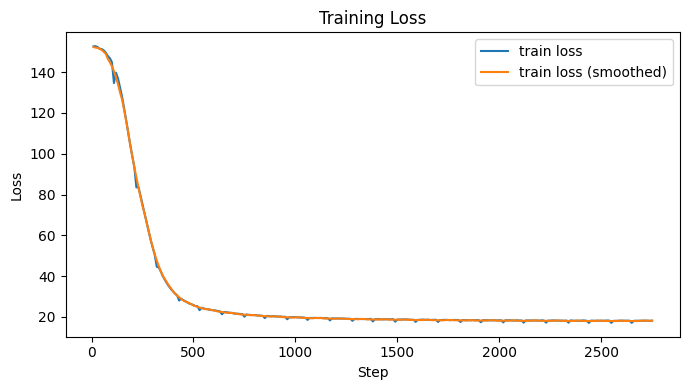

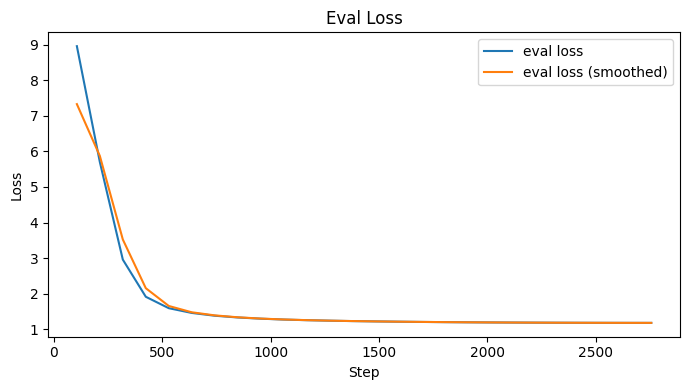

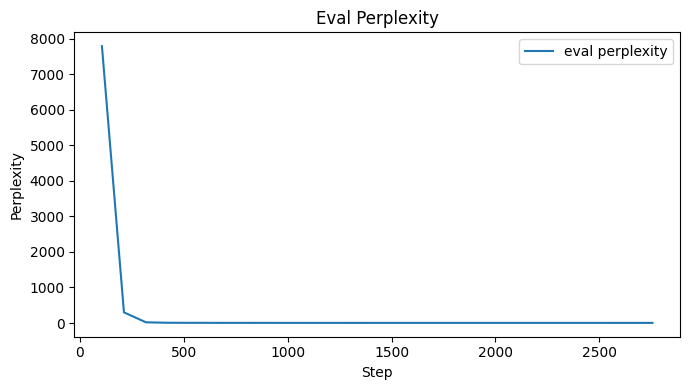

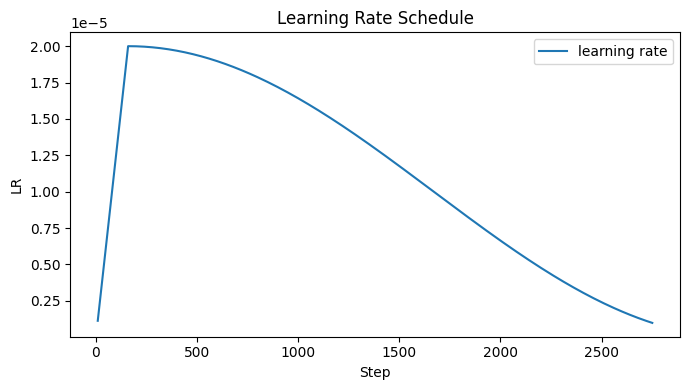

Best eval loss: 1.1769 at step 2756 (perplexity ~ 3.24)
Final train loss: 18.1938 at step 2750


In [ ]:
# ==== Example (fill your student base) ====
TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_135m"

# TODO: Run KD on top-k only and on first epoch run CE only.
# -------- Trainer config --------
sft_cfg = SFTConfig(
    output_dir=out_dir,
    num_train_epochs=30,
    per_device_train_batch_size=4, #4
    gradient_accumulation_steps=16, #16    # eff batch ~64
    learning_rate=2e-5, # 2e-4 with TOP-K and first epoch CE
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    weight_decay=0.05,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss", # eval_loss
    greater_is_better=False,
    fp16=False, bf16=False,
    optim="paged_adamw_8bit", # paged_adamw_8bit
    packing=False,
    max_length=1024,
    gradient_checkpointing=False,
    remove_unused_columns=False,
    report_to="none",
    seed=42,
)

try:
  trainer = train_kd_demo_qlora_student(
      STUDENT_ID="HuggingFaceTB/SmolLM2-135M",
      OUT_DIR=out_dir,
      DATASET_ID="zBotta/traffic-accidents-reports-5k", #800
      TEACHER_ID="zBotta/smollm2-accident-reporter-360m",
      KD_TEXT_RATIO=0.5,
      KD_ALPHA=0.7,
      KD_T=4.0, # increase T to smooth logit
      RANK=8, # lora rank = 16 for 135m distilled
      sft_cfg=sft_cfg,
      MAX_LEN=1024,
      DEMO_PROB= 1,
  )

  plot_training_results(out_dir, trainer)
except Exception as e:
  print(f"Error while training KD trainer: {e}")
  print("Desconnect Colab session")
  from google.colab import runtime
  runtime.unassign()

### Push Distilled model to HF

In [ ]:
repo_id = "zBotta/smollm2-135m-accident-reporting-distilled-kd360m"

from huggingface_hub import HfApi, create_repo, upload_folder, login
merged_dir = f"{out_dir}/merged-fp16" # we should push the adapter model
from google.colab import userdata
hf_token = userdata.get('hf_token')

login(token=hf_token)

api = HfApi(token=hf_token)
try:
  api.create_repo(repo_id, private=False, repo_type="model")
except Exception as e:
  print(f"Repo model {repo_id} already created")
upload_folder(folder_path=merged_dir, repo_id=repo_id, repo_type="model")
print("Pushed:", repo_id)

Repo model zBotta/smollm2-135m-accident-reporting-distilled-kd360m already created


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ..._135m/merged-fp16/model.safetensors:   3%|3         | 8.38MB /  269MB            

Pushed: zBotta/smollm2-135m-accident-reporting-distilled-kd360m


### Push KD data set to HF

In [ ]:
from huggingface_hub import HfApi, login, upload_folder
from google.colab import userdata
hf_token = userdata.get('hf_token')

login(token=hf_token)



README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

data/eval-00000-of-00001.parquet:   0%|          | 0.00/172k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6748 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'target', 'source'],
        num_rows: 6748
    })
    eval: Dataset({
        features: ['input', 'target', 'source'],
        num_rows: 500
    })
})


In [ ]:
import os
from datasets import load_from_disk, load_dataset, DatasetDict
from huggingface_hub import HfApi, create_repo, upload_folder, login
TRAINING_DIR = "app/datasets/training"
out_dir = TRAINING_DIR + "/student_kd_135m"
KD_CACHE_DIR = os.path.join(out_dir, "kd_dataset_opt")
print(f"KD directory: {KD_CACHE_DIR}")

repo_id = "zBotta/traffic-accidents-reports-kd-smollm2-360M-7k"

if os.path.isdir(KD_CACHE_DIR):
    print(f"📦 Loading cached KD dataset from {KD_CACHE_DIR}")
    ds_train_kd = load_from_disk(KD_CACHE_DIR)

print(ds_train_kd[:3])

# Add eval to data set
raw = load_dataset("zBotta/traffic-accidents-reports-5k")  # expects splits "train"/"eval" with 'input' and 'target'
assert "train" in raw and "eval" in raw, "Dataset must have 'train' and 'eval'."
def ok(r): return bool(str(r.get("input","")).strip()) and bool(str(r.get("target","")).strip())
ds_raw = DatasetDict(train=raw["train"].filter(ok), eval=raw["eval"].filter(ok))


eval_gold_with_src = ds_raw["eval"].map(lambda ex: {"source": "gold"}, desc="Tagging gold rows")



ds_train_complete = DatasetDict(train=ds_train_kd, eval=eval_gold_with_src)


KD_CACHE_DIR = os.path.join(out_dir, "kd_dataset_with_eval")
print(f"KD directory: {KD_CACHE_DIR}")
ds_train_complete.save_to_disk(KD_CACHE_DIR)
print(f"💾 Saved KD dataset to {KD_CACHE_DIR}")


KD directory: app/datasets/training/student_kd_135m/kd_dataset_opt
📦 Loading cached KD dataset from app/datasets/training/student_kd_135m/kd_dataset_opt
{'input': ['What: Minor collision between Vehicle A (compact car) and Vehicle B (minivan) in parking lot\nWhen: Occurrence: December 9, 2025, 13:00; Discovery: December 9, 2025, 13:01\nWhere: Shopping center parking lot, Lot B\nWho: Ms. Karen Liu – compact car driver (Vehicle A), Mr. Thomas Barnes – minivan driver (Vehicle B)\nHow: Vehicle A misjudged turning space and touched Vehicle B\nWhy: Driver inattention during parking maneuver\nContingencyActions: Drivers exchanged info, no injuries reported, security cameras documented accident', "What: Rear-end collision involving Vehicle A (bus), Vehicle B (sedan), and Vehicle C (sedan)\nWhen: Occurrence: September 18, 2025, 07:55; Discovery: September 18, 2025, 07:57\nWhere: Highway 50 northbound ramp\nWho: Vehicle A driver: Mr. Carlos Rivera; Vehicle B driver: Ms. Stella Huang; Vehicle C d

Filter:   0%|          | 0/4499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Tagging gold rows:   0%|          | 0/500 [00:00<?, ? examples/s]

KD directory: app/datasets/training/student_kd_135m/kd_dataset_with_eval


Saving the dataset (0/1 shards):   0%|          | 0/6748 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

💾 Saved KD dataset to app/datasets/training/student_kd_135m/kd_dataset_with_eval


In [ ]:
ds_train_complete["eval"][100]

{'input': 'What: Side-swipe collision between Vehicle A (sedan) and Vehicle B (SUV)\nWhen: Occurrence: April 12, 2024, 14:30; Discovery: April 12, 2024, 14:31\nWhere: Highway 101, near exit 25, California\nWho: Michael Thompson – driver of Vehicle A; Emily Zhang – driver of Vehicle B\nHow: Vehicle A changed lanes without signaling, colliding with Vehicle B\nWhy: Unsafe lane change by Vehicle A\nContingencyActions: Authorities arrived; vehicles towed; minor injuries treated on-site',
 'target': "At 2:30 pm on April 12, 2024, on Highway 101 near exit 25, a side-swipe accident occurred when Michael Thompson in a sedan changed lanes without signaling, hitting Emily Zhang's SUV. Emergency services managed the scene and treated minor injuries.",
 'source': 'gold'}

In [ ]:
if os.path.isdir(KD_CACHE_DIR):
    print(f"📦 Loading cached KD dataset from {KD_CACHE_DIR}")
    ds_train_complete = load_from_disk(KD_CACHE_DIR)


    from huggingface_hub import HfApi, login, upload_folder
    from google.colab import userdata
    hf_token = userdata.get('hf_token')

    login(token=hf_token)

    api = HfApi(token=hf_token)
    try:
      api.create_repo(repo_id, private=False, repo_type="dataset")

    except Exception as e:
      print(f"Dataset model {repo_id} already created")
    finally:
      ds_train_complete.push_to_hub(repo_id, private=False, commit_message="Initial dataset upload")
      print("Pushed:", repo_id)

📦 Loading cached KD dataset from app/datasets/training/student_kd_135m/kd_dataset_with_eval
Dataset model zBotta/traffic-accidents-reports-kd-smollm2-360M-7k already created


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  45%|####5     | 1.14MB / 2.51MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  94%|#########4|  163kB /  172kB            

README.md: 0.00B [00:00, ?B/s]

Pushed: zBotta/traffic-accidents-reports-kd-smollm2-360M-7k


## Distillation v5.0 (on SmolLM2-135M) function load and plot

In [ ]:
# ==== ONE-CELL: KD + QLoRA (student), optional KD gen from gold, eval & latency ====
!pip -q install -U "transformers>=4.43" "accelerate>=0.33" "datasets>=2.20" peft bitsandbytes trl evaluate sacrebleu rouge_score

import os, re, json, math, time, random, gc
import numpy as np, torch
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import evaluate
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,
    EarlyStoppingCallback, GenerationConfig, TrainerCallback
)
from peft import LoraConfig, PeftModel
from trl import SFTConfig, SFTTrainer
from huggingface_hub import login

# (Colab) login if you store your token in user data
try:
    from google.colab import userdata
    hf_token = userdata.get('hf_token')
    if hf_token: login(token=hf_token)
except Exception:
    pass

# speed & stability on T4 with bnbkl_topk
torch.backends.cuda.matmul.allow_tf32 = True
os.environ["ACCELERATE_MIXED_PRECISION"] = "no"

def train_kd_demo_qlora_student(
    STUDENT_ID: str = "HuggingFaceTB/SmolLM2-360M-Instruct",      # tiny student
    TEACHER_ID: str = "HuggingFaceTB/SmolLM2-1.7B-Instruct",      # teacher (same tokenizer family!)
    OUT_DIR: str = "student_kd_output",
    GOLD_DATASET_ID: str = "zBotta/traffic-accidents-reports-5k",
    KD_DATASET_REPO: Optional[str] = None,     # optional ready-made KD set; else we use GOLD
    USE_KD_DATASET: bool = False,
    DEMO_PROB: float = 0.8,
    KD_ALPHA: list = [0.85, 0.65],            # CE weight (KL gets 1-KD_ALPHA)
    KD_T: float = 2.0,                        # KD temperature
    KD_TOP_K: int = 128,
    SOFT_KD_WMIN: float = 0.05,
    SOFT_KD_GAMMA: float = 2.0,
    BETA_UL: float = 0.1,
    RANK: int = 8,
    LORA_DROPOUT: float = 0.05,
    sft_cfg: Optional[SFTConfig] = None,
    MAX_LEN: int = 1024,
    EVAL_N: int = 5,                          # eval examples for metrics & latency
    GEN_MAX_NEW: int = 256,                   # generation budget for eval/latency
):
    """
    KD (logit) + CE distillation with QLoRA student.
    """
    os.makedirs(OUT_DIR, exist_ok=True)

    RESP_TMPL = "### Response:\n"
    # INSTR = ("You are a reporting agent. Write ONE factual paragraph using ONLY the given facts "
    #          "(What, When, Where, Who, How, Why, ContingencyActions). Do not invent details.")
    INSTR = (
    """
    You are a reporting agent.
    You task is to create a report when provided the what, when, why, who, how and where questions about the events.
    You are also given information about the contingency actions regarding the event.

    Guidelines:
    - Generate only one report given the informations about the event
    - Generate the report as text in one paragraph
    - It is important to focus on accuracy and coherence when generating the report so that the description content matches the information provided (what, when, where, who, how , why, contingency actions).
      If an information is not provided in (what, when, where, who, how , why, contingency actions), it must not be part of the generated text description.
    """
    )

    def one_line(s: str) -> str:
        return re.sub(r"\s+", " ", str(s).replace("\n", " ")).strip()

    def prompt_with_demo(demo_in: str, demo_out: str, current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input-example:\n" + demo_in + "\n\n" +
            "### Output-example:\n" + one_line(demo_out) + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

    def prompt_no_demo(current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

    # -------- Load GOLD dataset --------
    raw_gold = load_dataset(GOLD_DATASET_ID)  # expects splits "train"/"eval" with 'input' and 'target'
    assert "train" in raw_gold and "eval" in raw_gold, "Gold dataset must have 'train' and 'eval'."
    def ok(r): return bool(str(r.get("input","")).strip()) and bool(str(r.get("target","")).strip())
    ds_gold = DatasetDict(train=raw_gold["train"].filter(ok), eval=raw_gold["eval"].filter(ok))
    demo_pool: List[Tuple[str,str]] = [(one_line(r["input"]), one_line(r["target"])) for r in ds_gold["train"]]

    # -------- Tokenizers --------
    tok_student = AutoTokenizer.from_pretrained(STUDENT_ID, use_fast=True)
    tok_teacher = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
    if tok_student.pad_token_id is None: tok_student.pad_token = tok_student.eos_token
    if tok_teacher.pad_token_id is None: tok_teacher.pad_token = tok_teacher.eos_token

    # Required for logit KD
    if tok_student.get_vocab() != tok_teacher.get_vocab():
        raise RuntimeError(
            "Tokenizer mismatch: student and teacher must share IDENTICAL vocab for logit KD.\n"
            f"Student vocab size={len(tok_student)}, Teacher vocab size={len(tok_teacher)}.\n"
            "Pick a student with the exact same tokenizer as the teacher, or disable logit KD."
        )

    # -------- 4-bit config --------
    bnb4 = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.float16
    )

    # -------- KD dataset load / fallback --------
    def try_load_kd_repo(repo_id: Optional[str]) -> Optional[DatasetDict]:
        if not repo_id: return None
        try:
            ds = load_dataset(repo_id)
            if "train" in ds and "eval" in ds and all(k in ds["train"].column_names for k in ("input","target")):
                print(f"✅ KD dataset loaded from: {repo_id}")
                return DatasetDict(train=ds["train"], eval=ds["eval"])
            else:
                print(f"⚠️ KD repo {repo_id} missing expected splits/columns; will generate from GOLD.")
                return None
        except Exception as e:
            print(f"⚠️ Could not load KD repo {repo_id}: {e}\nWill generate teacher outputs from GOLD.")
            return None

    if USE_KD_DATASET:
        ds_base = try_load_kd_repo(KD_DATASET_REPO)
        need_kd_from_gold = ds_base is None
    else:
        ds_base = ds_gold
        need_kd_from_gold = False

    # -------- Teacher model (for logits & optional text gen) --------
    teacher_for_logits = AutoModelForCausalLM.from_pretrained(
        TEACHER_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto"
    ).eval()
    for p in teacher_for_logits.parameters(): p.requires_grad_(False)

    # ----- FIXED per-row decode slicing for teacher gens -----
    def gen_teacher_texts(ds: Dataset, batch_size: int = 4, max_new: int = 256) -> List[str]:
        """Generate teacher texts for ds['input'] with the same prompting scheme (no demo)."""
        outs = []
        device = next(teacher_for_logits.parameters()).device
        for i in range(0, len(ds), batch_size):
            batch = ds[i:i+batch_size]
            prompts = [prompt_no_demo(one_line(x)) for x in batch["input"]]
            enc = tok_teacher(prompts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
            enc = {k: v.to(device) for k, v in enc.items()}
            with torch.inference_mode():
                gen = teacher_for_logits.generate(
                    **enc, do_sample=False, temperature=1.0, max_new_tokens=max_new,
                    eos_token_id=tok_teacher.eos_token_id, pad_token_id=tok_teacher.pad_token_id
                )
            input_lens = enc["attention_mask"].sum(dim=1).tolist()
            for j in range(len(prompts)):
                new_ids = gen[j, input_lens[j]:]
                text = tok_teacher.decode(new_ids, skip_special_tokens=True)
                outs.append(one_line(text))
        return outs

    if need_kd_from_gold:
        print("🛠 Generating teacher outputs from GOLD for KD...")
        kd_train_out = gen_teacher_texts(ds_gold["train"])
        kd_eval_out  = gen_teacher_texts(ds_gold["eval"])
        ds_base = DatasetDict(
            train = ds_gold["train"].add_column("target", kd_train_out),
            eval  = ds_gold["eval"].add_column("target",  kd_eval_out),
        )

    # -------- Tokenize (response-only labels) --------
    def add_demo_and_tokenize(example, idx):
        cur_in, cur_out = one_line(example["input"]), one_line(example["target"])
        use_demo = (np.random.rand() < DEMO_PROB) and (len(demo_pool) > 1)
        if use_demo:
            d_in, d_out = demo_pool[(idx+1) % len(demo_pool)]
            prompt = prompt_with_demo(d_in, d_out, cur_in)
        else:
            prompt = prompt_no_demo(cur_in)

        prom = tok_student(prompt, add_special_tokens=True, truncation=True, max_length=MAX_LEN)
        prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        # fallback to no-demo if too tight
        if len(prompt_ids) >= MAX_LEN - 4:
            prom = tok_student(prompt_no_demo(cur_in), add_special_tokens=True, truncation=True, max_length=MAX_LEN)
            prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        eos = tok_student.eos_token_id
        if eos is None:
            tok_student.pad_token = tok_student.eos_token
            eos = tok_student.eos_token_id

        budget = MAX_LEN - len(prompt_ids)
        if budget <= 0:
            prompt_ids = prompt_ids[:-1]; attn_prompt = attn_prompt[:-1]
            budget = 1

        allow = max(0, budget - 1)
        targ_ids = tok_student(cur_out, add_special_tokens=False, truncation=True, max_length=max(1, allow)).input_ids
        targ_ids = targ_ids[:allow]

        target_with_eos = targ_ids + [eos]
        input_ids      = prompt_ids + target_with_eos
        attention_mask = attn_prompt + [1] * len(target_with_eos)
        labels         = [-100] * len(prompt_ids) + target_with_eos
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

    ds_tok = DatasetDict(
        train = ds_base["train"].map(add_demo_and_tokenize, with_indices=True, remove_columns=ds_base["train"].column_names, desc="Tokenizing train"),
        eval  = ds_base["eval"].map(add_demo_and_tokenize,  with_indices=True, remove_columns=ds_base["eval"].column_names,  desc="Tokenizing eval"),
    )

    # -------- Student model (4-bit) + LoRA --------
    student = AutoModelForCausalLM.from_pretrained(
        STUDENT_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto"
    )
    student.config.use_cache = False

    lora_cfg = LoraConfig(
        r=RANK, lora_alpha=2*RANK, lora_dropout=LORA_DROPOUT,
        target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
        task_type="CAUSAL_LM"
    )

    # -------- Collator --------
    @dataclass
    class Coll:
        pad_id: int
        def __call__(self, feats):
            L = max(len(f["input_ids"]) for f in feats)
            def pad(x, v): return x + [v]*(L-len(x))
            batch = {
                "input_ids": torch.tensor([pad(f["input_ids"], self.pad_id) for f in feats]),
                "attention_mask": torch.tensor([pad(f["attention_mask"], 0) for f in feats]),
                "labels": torch.tensor([pad(f["labels"], -100) for f in feats]),
            }
            if not (batch["labels"] != -100).any():
                raise RuntimeError("Batch has no supervised tokens.")
            return batch
    collator = Coll(tok_student.pad_token_id)

    # -------- KD-enabled Trainer (with alignment fix) --------
    class DistillSFTTrainer(SFTTrainer):
      def __init__(self, *args,
                 teacher_model=None,
                 kd_alpha_ce_start=0.85,
                 kd_alpha_ce_end=0.65,
                 kd_warmup_epochs=2,
                 kd_ramp_epochs=2,
                 kd_temp=3.0,
                 kd_top_K=128,
                 beta_ul=0.1,
                 ce_smoothing=0.05,
                 soft_kd_gamma=2.0,
                 soft_kd_wmin=0.05,
                 **kwargs):
        super().__init__(*args, **kwargs)
        assert teacher_model is not None
        self.teacher = teacher_model.eval()
        for p in self.teacher.parameters(): p.requires_grad_(False)
        self.kd_alpha_ce_start = float(kd_alpha_ce_start)
        self.kd_alpha_ce_end   = float(kd_alpha_ce_end)
        self.kd_warmup_epochs  = int(kd_warmup_epochs)
        self.kd_ramp_epochs    = int(kd_ramp_epochs)
        self.kd_temp           = float(kd_temp)
        self.kd_top_K          = int(kd_top_K)
        self.beta_ul           = float(beta_ul)
        self.ce_smoothing      = float(ce_smoothing)
        self.soft_kd_gamma     = float(soft_kd_gamma)
        self.soft_kd_wmin      = float(soft_kd_wmin)

      def _ce_weight(self):
        e = float(self.state.epoch or 0.0)
        if e < self.kd_warmup_epochs: return 1.0
        if e < self.kd_warmup_epochs + self.kd_ramp_epochs:
            t = (e - self.kd_warmup_epochs) / max(1.0, self.kd_ramp_epochs)
            return self.kd_alpha_ce_start + (self.kd_alpha_ce_end - self.kd_alpha_ce_start) * t
        return self.kd_alpha_ce_end

      def _smoothed_ce(self, logp, labels, mask, eps=0.05):
          # logp: [B,L,V] aligned with labels [B,L]
          gather = torch.gather(logp, -1, labels.clamp_min(0).unsqueeze(-1)).squeeze(-1)  # [B,L]
          nll = -(gather[mask]).mean()
          H   = -(logp[mask]).mean()
          return (1 - eps) * nll + eps * H

      def compute_loss(self, model, inputs, return_outputs=False, **kw):
          labels = inputs.pop("labels")                   # [B, L]
          out_s = model(**inputs, use_cache=False)
          logits_s = out_s.logits                         # [B, L, V]

          # ===== ALIGN BY ONE STEP =====
          logits_s_shift = logits_s[:, :-1, :]            # predict next token
          labels_shift   = labels[:, 1:]
          mask_shift     = (labels_shift != -100)

          # CE (smoothed) on shifted tensors
          logp_s_shift = torch.log_softmax(logits_s_shift, dim=-1)
          ce = self._smoothed_ce(logp_s_shift, labels_shift, mask_shift, eps=self.ce_smoothing)

          ce_w = self._ce_weight()
          if ce_w >= 0.999:
              return (ce, out_s) if return_outputs else ce

          # Teacher forward + shift
          with torch.inference_mode():
              out_t = self.teacher(**inputs, use_cache=False)
              logits_t_shift = out_t.logits[:, :-1, :]

          # KD (top-K partial KL) on shifted tensors
          T = self.kd_temp
          V = logits_s_shift.shape[-1]
          K = min(self.kd_top_K, V)
          topk_val, topk_idx = torch.topk(logits_t_shift / T, k=K, dim=-1)  # [B,L-1,K]
          p_t_topk = torch.softmax(topk_val, dim=-1)                         # [B,L-1,K]
          conf = p_t_topk[..., 0]                                            # [B,L-1]
          w = torch.clamp(conf ** self.soft_kd_gamma, min=self.soft_kd_wmin) * mask_shift.float()
          has_kd = (w.sum() > 0)

          if has_kd:
              logp_s_T_shift = torch.log_softmax(logits_s_shift / T, dim=-1)
              gather_logp_s  = torch.gather(logp_s_T_shift, -1, topk_idx)  # [B,L-1,K]
              kl_pos = torch.sum(p_t_topk * (torch.log(p_t_topk + 1e-9) - gather_logp_s), dim=-1)  # [B,L-1]
              kd = (w * kl_pos).sum() / (w.sum() + 1e-6)
          else:
              kd = torch.zeros((), device=logits_s.device)

          # tiny anti-repeat on next-token probs (aligned)
          beta_ul = self.beta_ul
          if beta_ul > 0:
              prev_tok = inputs["input_ids"][:, :-1]     # token at t
              p_next   = torch.softmax(logits_s_shift, dim=-1)
              p_repeat = torch.gather(p_next, -1, prev_tok.unsqueeze(-1)).squeeze(-1)  # P(x_{t+1}=x_t)
              ul = -torch.log(1.0 - p_repeat + 1e-6)
              ul = (ul[mask_shift]).mean() if mask_shift.any() else torch.zeros((), device=logits_s.device)
          else:
              ul = torch.zeros((), device=logits_s.device)

          kd_w = 1.0 - ce_w
          loss = ce_w * ce + kd_w * kd + beta_ul * ul

          if self.state.global_step % 50 == 0:
              self.log({
                  "train/ce": float(ce.detach()),
                  "train/kd": float(kd.detach()),
                  "train/ul": float(ul.detach()),
                  "train/ce_weight": float(ce_w),
                  "train/kd_weight": float(kd_w),
              })
          return (loss, out_s) if return_outputs else loss

    # ===== Callback to print a sample generation at each epoch end =====
    class SampleGenerateCallback(TrainerCallback):
      def __init__(self, tok, make_prompt_fn, eval_ds, max_new=180, resp_marker="### Response:\n"):
          self.tok = tok
          self.make_prompt_fn = make_prompt_fn
          self.eval_ds = eval_ds
          self.max_new = max_new
          self.resp_marker = resp_marker
          self.rng = np.random.default_rng(123)

      def _extract_report(self, decoded_full: str, decoded_new: str) -> str:
          """
          Prefer slicing from RESP_TMPL inside the full decoded text.
          Fall back to the already-sliced new text if the marker isn't found.
          Also stop at the next '###' section header if present.
          """
          marker = self.resp_marker.strip()  # "### Response:"
          idx = decoded_full.find(marker)
          if idx != -1:
              start = idx + len(marker)
              out = decoded_full[start:]
          else:
              out = decoded_new

          # If the model echoed a new section header, cut before it
          out = out.split("###", 1)[0]

          # Clean common boilerplate/echoes
          out = re.sub(r'^\s*(#+\s*Response:)?\s*', '', out)                     # drop echoed "### Response:"
          out = re.sub(r'^\s*(Factual\s+(paragraph|report)\s*:)\s*', '', out, flags=re.I)

          return one_line(out)

      def _gen(self, model, prompt: str) -> str:
          device = next(model.parameters()).device
          enc = self.tok([prompt], return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
          enc = {k: v.to(device) for k, v in enc.items()}
          with torch.inference_mode():
              out = model.generate(
                  **enc,
                  do_sample=False,                 # deterministic
                  max_new_tokens=self.max_new,
                  no_repeat_ngram_size=4,          # mild guard
                  repetition_penalty=1.05,
                  renormalize_logits=True,
                  eos_token_id=self.tok.eos_token_id,
                  pad_token_id=self.tok.pad_token_id
              )

          # Decode both (full and new-only) so we can robustly slice from the marker
          input_len = int(enc["attention_mask"].sum().item())
          decoded_full = self.tok.decode(out[0], skip_special_tokens=True)
          decoded_new  = self.tok.decode(out[0, input_len:], skip_special_tokens=True)
          return self._extract_report(decoded_full, decoded_new)

      def on_epoch_end(self, args, state, control, **kwargs):
          model = kwargs["model"]
          was_training = model.training
          model.eval()
          try:
              idx = int(self.rng.integers(0, len(self.eval_ds)))
              cur_in = one_line(self.eval_ds[idx]["input"])
              prompt = self.make_prompt_fn(cur_in)
              text = self._gen(model, prompt)

              # Print only the report (trimmed)
              print(f"\n[epoch {int(state.epoch)}] sample report (post-RESP_TMPL)")
              print("Report:", (text[:300] + ("..." if len(text) > 300 else "")))
          finally:
              if was_training: model.train()
          gc.collect()
          if torch.cuda.is_available():
              torch.cuda.empty_cache()


    def make_eval_prompt(x): return prompt_no_demo(one_line(x))
    sample_cb = SampleGenerateCallback(
        tok_student,
        make_eval_prompt,
        ds_gold["eval"],
        max_new=300,
        resp_marker=RESP_TMPL)

    trainer = DistillSFTTrainer(
        model=student,
        args=sft_cfg,
        peft_config=lora_cfg,
        train_dataset=ds_tok["train"],
        eval_dataset=ds_tok["eval"],
        data_collator=collator,
        teacher_model=teacher_for_logits,
        kd_alpha_ce_start=KD_ALPHA[0],
        kd_alpha_ce_end=KD_ALPHA[1],
        kd_warmup_epochs=2,
        kd_ramp_epochs=2,
        kd_temp=KD_T,
        kd_top_K=KD_TOP_K,
        beta_ul=BETA_UL,
        ce_smoothing=0.05,
        soft_kd_gamma=SOFT_KD_GAMMA,
        soft_kd_wmin=SOFT_KD_WMIN,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=1e-3),
            sample_cb,  # <-- prints a quick report each epoch
        ],
    )

    print("Accelerate mixed precision:", trainer.accelerator.mixed_precision)
    trainables = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)
    print("Trainable params:", trainables)

    # ---- Train ----
    trainer.train()

    # ---- Save LoRA adapter (best) ----
    adapter_dir = f"{OUT_DIR}/adapter"
    os.makedirs(adapter_dir, exist_ok=True)
    trainer.model.save_pretrained(adapter_dir)
    tok_student.save_pretrained(adapter_dir)
    print("✅ Saved LoRA adapter to:", adapter_dir)

    # ---- Build merged FP16 checkpoint (ready to push) ----
    best_dir = trainer.state.best_model_checkpoint or adapter_dir
    merged_dir = f"{OUT_DIR}/merged-fp16"
    os.makedirs(merged_dir, exist_ok=True)

    base_fp16 = AutoModelForCausalLM.from_pretrained(STUDENT_ID, torch_dtype=torch.float16, device_map="cpu")
    peft_best = PeftModel.from_pretrained(base_fp16, best_dir)
    merged = peft_best.merge_and_unload().eval()

    if tok_student.pad_token_id is None:
        tok_student.pad_token = tok_student.eos_token
    merged.save_pretrained(merged_dir, safe_serialization=True)
    tok_student.save_pretrained(merged_dir)

    with open(os.path.join(merged_dir, "generation_config.json"), "w") as f:
        json.dump({
            "max_new_tokens": 300,
            "do_sample": True,
            "eos_token_id": tok_student.eos_token_id,
            "pad_token_id": tok_student.pad_token_id
        }, f)

    print("✅ Merged FP16 model saved to:", merged_dir)

    # =========================
    # Evaluation & Latency (5)
    # =========================
    rouge = evaluate.load("rouge")
    bleu  = evaluate.load("sacrebleu")

    rng = np.random.default_rng(42)
    idxs = rng.choice(len(ds_gold["eval"]), size=min(EVAL_N, len(ds_gold["eval"])), replace=False)
    eval_subset = ds_gold["eval"].select(list(idxs))
    prompts = [make_eval_prompt(x["input"]) for x in eval_subset]
    refs    = [[one_line(x["target"])] for x in eval_subset]  # sacrebleu expects list of list

    def gen_text(model, tok, prompts, max_new=GEN_MAX_NEW, do_sample=False, temperature=1.0):
        device = next(model.parameters()).device
        enc = tok(prompts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.inference_mode():
            gen = model.generate(
                **enc,
                do_sample=do_sample, temperature=temperature,
                max_new_tokens=max_new,
                eos_token_id=tok.eos_token_id, pad_token_id=tok.pad_token_id
            )
        input_lens = enc["attention_mask"].sum(dim=1).tolist()
        texts = []
        for i in range(len(prompts)):
            out_ids = gen[i, input_lens[i]:]
            texts.append(one_line(tok.decode(out_ids, skip_special_tokens=True)))
        return texts, gen, enc

    student_eval = AutoModelForCausalLM.from_pretrained(merged_dir, torch_dtype=torch.float16, device_map="auto").eval()
    teacher_eval = teacher_for_logits  # same instance

    print("\n=== Accuracy on 5 samples (Teacher) ===")
    pred_teacher, _, _ = gen_text(teacher_eval, tok_teacher, prompts, do_sample=False, temperature=1.0)
    rouge_teacher = rouge.compute(predictions=pred_teacher, references=[r[0] for r in refs], use_stemmer=True)
    bleu_teacher  = bleu.compute(predictions=pred_teacher, references=refs)
    print("ROUGE-Lsum:", round(rouge_teacher["rougeLsum"], 4), " | SacreBLEU:", round(bleu_teacher["score"], 2))

    print("\n=== Accuracy on 5 samples (Student) ===")
    pred_student, _, _ = gen_text(student_eval, tok_student, prompts, do_sample=False, temperature=1.0)
    rouge_student = rouge.compute(predictions=pred_student, references=[r[0] for r in refs], use_stemmer=True)
    bleu_student  = bleu.compute(predictions=pred_student, references=refs)
    print("ROUGE-Lsum:", round(rouge_student["rougeLsum"], 4), " | SacreBLEU:", round(bleu_student["score"], 2))

    for i,(p,ref,ts,ss) in enumerate(zip(prompts, [r[0] for r in refs], pred_teacher, pred_student)):
        print(f"\n--- Sample {i+1} ---")
        print("Ref :", ref[:200] + ("..." if len(ref)>200 else ""))
        print("Teach:", ts[:200] + ("..." if len(ts)>200 else ""))
        print("Stud :", ss[:200] + ("..." if len(ss)>200 else ""))

    def latency_test(model, tok, prompts, max_new=GEN_MAX_NEW, warmup=True, label="model"):
        device = next(model.parameters()).device
        if warmup:
            _ = gen_text(model, tok, prompts[:1], max_new=32, do_sample=False, temperature=1.0)
            if device.type == "cuda":
                torch.cuda.synchronize()
        times, toks = [], []
        for prompt in prompts:
            enc = tok([prompt], return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
            enc = {k: v.to(device) for k, v in enc.items()}
            if device.type == "cuda": torch.cuda.synchronize()
            t0 = time.perf_counter()
            with torch.inference_mode():
                gen = model.generate(
                    **enc, do_sample=False, temperature=1.0, max_new_tokens=max_new,
                    eos_token_id=tok.eos_token_id, pad_token_id=tok.pad_token_id
                )
            if device.type == "cuda": torch.cuda.synchronize()
            input_len = int(enc["attention_mask"].sum().item())
            out_len = int(gen.shape[1] - input_len)
            times.append(time.perf_counter() - t0)
            toks.append(out_len)
        avg_lat = sum(times)/len(times)
        avg_toks = sum(toks)/len(toks)
        tps = (sum(toks)/sum(times)) if sum(times)>0 else 0.0
        print(f"\n=== Latency ({label}) ===")
        for i,(dt,tk) in enumerate(zip(times,toks)):
            print(f"ex{i+1}: {dt:.3f}s, gen_tokens={tk}, tok/s={tk/dt if dt>0 else 0.0:.1f}")
        print(f"AVG: {avg_lat:.3f}s per sample | {tps:.1f} tok/s | avg_gen_tokens={avg_toks:.1f}")

    latency_test(teacher_eval, tok_teacher, prompts, max_new=GEN_MAX_NEW, label="Teacher")
    latency_test(student_eval, tok_student, prompts, max_new=GEN_MAX_NEW, label="Student")

    print("\nDone.")
    return trainer




import matplotlib.pyplot as plt
import pandas as pd

# =========================
# Post-training: PNG GRAPHS + CSV
# =========================

def plot_training_results(out_dir, _trainer):
  """ loads trainer log history and plots results and exports images """
  logs = pd.DataFrame(_trainer.state.log_history)
  if logs.empty:
      print("No logs recorded. Did logging_steps/eval_steps run?")
  else:
      os.makedirs(out_dir, exist_ok=True)
      log_csv = os.path.join(out_dir, "training_logs.csv")
      logs.to_csv(log_csv, index=False)
      print("Saved raw logs to:", log_csv)

      def safe_exp(x):
          try: return float(np.exp(x))
          except Exception: return np.nan

      train_df = logs[logs["loss"].notna()][["step","loss"]].copy()
      eval_df  = logs[logs["eval_loss"].notna()][["step","eval_loss"]].copy()
      lr_df    = logs[logs["learning_rate"].notna()][["step","learning_rate"]].copy()

      if not eval_df.empty: eval_df["eval_perplexity"] = eval_df["eval_loss"].map(safe_exp)
      if not train_df.empty: train_df["perplexity"] = train_df["loss"].map(safe_exp)

      def smooth(y, k=5):
          s = pd.Series(y); return s.rolling(k, min_periods=1, center=True).mean().values

      if not train_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(train_df["step"], train_df["loss"], label="train loss")
          plt.plot(train_df["step"], smooth(train_df["loss"], 7), label="train loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Training Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "train_loss.png")); plt.show()

      if not eval_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_loss"], label="eval loss")
          plt.plot(eval_df["step"], smooth(eval_df["eval_loss"], 3), label="eval loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Eval Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_loss.png")); plt.show()

          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_perplexity"], label="eval perplexity")
          plt.xlabel("Step"); plt.ylabel("Perplexity"); plt.title("Eval Perplexity")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_perplexity.png")); plt.show()

      if not lr_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(lr_df["step"], lr_df["learning_rate"], label="learning rate")
          plt.xlabel("Step"); plt.ylabel("LR"); plt.title("Learning Rate Schedule")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "learning_rate.png")); plt.show()

      if not eval_df.empty:
          best_row = eval_df.loc[eval_df["eval_loss"].idxmin()]
          print(f"Best eval loss: {best_row['eval_loss']:.4f} at step {int(best_row['step'])} "
                f"(perplexity ~ {best_row['eval_perplexity']:.2f})")
      if not train_df.empty:
          print(f"Final train loss: {train_df['loss'].iloc[-1]:.4f} at step {int(train_df['step'].iloc[-1])}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.7 MB/s eta 0:00:00


### Run Distillation v5.0 + 135M

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import userdata
github_token = userdata.get('zbotta_token')

token = github_token
username = "zbotta"
repo = 'reportingAgent'
!git config --global user.name "zbotta"
!git config --global user.email "zbotta@proton.me"
%cd /content/drive/MyDrive/GitHub/{repo}

Mounted at /content/drive
/content/drive/MyDrive/GitHub/reportingAgent


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.53M [00:00<?, ?B/s]

data/eval-00000-of-00001.parquet:   0%|          | 0.00/172k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/40.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4499 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/101 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Tokenizing train:   0%|          | 0/4499 [00:00<?, ? examples/s]

Tokenizing eval:   0%|          | 0/500 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Truncating train dataset:   0%|          | 0/4499 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Accelerate mixed precision: no
Trainable params: 2442240



[epoch 1] sample report (post-RESP_TMPL)
Report: - The response should be written in a single paragraph with the following elements: - What: What happened - When: Occurance: December 4, 22, 21:16 - Why: Lacking visibility and improper turning techniques by Vehicle B What: What was observed - Where: Where: Underground garage, 8th Street complex Why...

[epoch 2] sample report (post-RESP_TMPL)
Report: The response should include the following elements: - What: What happened - When: Occurance: February 20, 22, 21 When: Occurrance: February 3, 23, 12 When: Occurnce: February 5, 24, 13 When: Occurence: February 7, 25, 14 When: Occurreance: February28, 26, when: Occurrence 26: Occurrence28, when: occ...

[epoch 3] sample report (post-RESP_TMPL)
Report: The incident occurred at 15.30 on November 14, 2

[epoch 4] sample report (post-RESP_TMPL)
Report: The report will include the following information: - Vehicle A was driven by Mr. Michael Brook, who drove a pickup truck with a wet surface on 


[epoch 16] sample report (post-RESP_TMPL)
Report: At 0830 on March 15, 2007, Vehicle A (a sedan driven by Mr. John L., a 64-year-old man) ran a red light at the intersection of Main St and Fifth Ave. Vehicle B (a truck driven by Ms. Maria, a 30-year- old woman) was involved in a collision with Vehicle A. The collision occurred at 0845. The incident...

[epoch 17] sample report (post-RESP_TMPL)
Report: At 0600 on July 7th, 21:00, a multi-vehicle collision occurred at I-94 northbound near Exit 55. Vehicle A, a truck driven by Mr Alan Smith, collided with Vehicle B, a sedan driven and operated by Ms Linda Rose, and Vehicle C, an SUV operated by Mr Samuel Han, which was driven by Mr Samuel. The accid...

[epoch 18] sample report (post-RESP_TMPL)
Report: At 16.20 on June 5th, 22:20, Vehicle A (sedan) driven by Mrs. Jessica was struck by Vehicle B (Motorcycle) driven by Mr. Luis F. on a narrow lane near the Old Town district. The collision occurred at 1620 hours. The collision was discovere

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



=== Accuracy on 5 samples (Teacher) ===


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


ROUGE-Lsum: 0.331  | SacreBLEU: 19.31

=== Accuracy on 5 samples (Student) ===
ROUGE-Lsum: 0.2276  | SacreBLEU: 9.19

--- Sample 1 ---
Ref : On March 10, 2024, at 08:15, Mr. John Smith driving a sedan rear-ended Ms. Laura Green’s SUV at the intersection of Main St and Elm St in Springfield. The SUV had braked suddenly, but Mr. Smith was di...
Teach: Rear-end collision between Vehicle A (sedan) and Vehicle B (SUV) occurred at the intersection of Main St and Elm St, Springfield, on March 10, 2024, at 08:15. The collision was discovered at 08:17, an...
Stud : At 08:15, Vehicle A, a sedan driven by Mr. John Smith, rear-ended Vehicle B, a SUV driven by Ms. Laura Green, on Main St and Elm St. The driver of Vehicle A was distracted by driving at high speed and...

--- Sample 2 ---
Ref : At 11:20 on April 18, 2024, on 5th Avenue & Elm Street, Vehicle A, driven by Mr. Lucas Romero, turned left in front of oncoming Vehicle B, an SUV driven by Ms. Hana Yilmaz, causing a crash. Ms. Yilmaz...
Teach

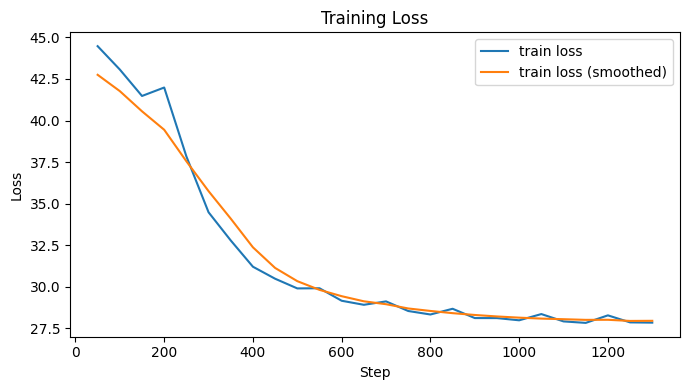

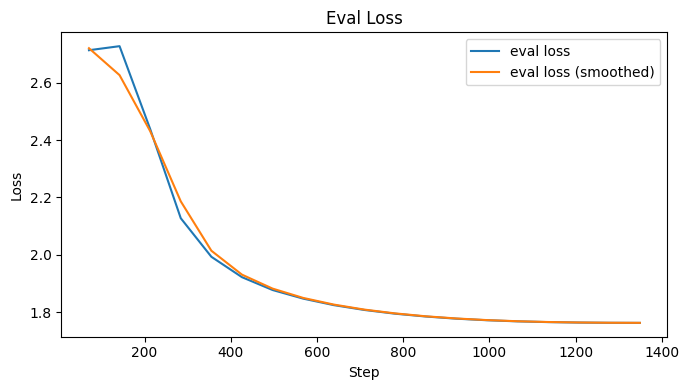

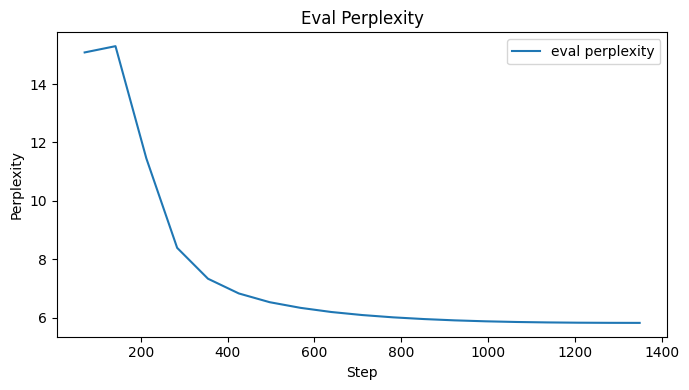

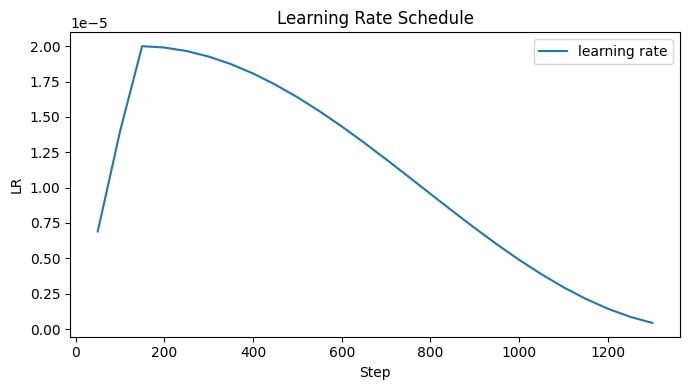

Best eval loss: 1.7629 at step 1349 (perplexity ~ 5.83)
Final train loss: 27.8466 at step 1300


In [5]:
# ==== Example (fill your student base) ====
TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_135m-v5"


# -------- Trainer config --------
sft_cfg = SFTConfig(
    output_dir=out_dir,
    num_train_epochs=20,
    per_device_train_batch_size=4, #4
    gradient_accumulation_steps=16, #16    # eff batch ~64
    learning_rate=2e-5, # 2e-5
    lr_scheduler_type="cosine",
    warmup_ratio=0.1, # 0.08
    weight_decay=0.05,
    label_smoothing_factor=0.05,
    max_grad_norm=0.5, # 1.0
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss", # eval_loss
    greater_is_better=False,
    fp16=False, bf16=False,
    optim="adamw_bnb_8bit",
    packing=False,
    max_length=1024,
    gradient_checkpointing=True,       # ON
    gradient_checkpointing_kwargs={"use_reentrant": False},
    remove_unused_columns=False,
    dataloader_num_workers=4,   # new
    dataloader_pin_memory=True,  # new
    report_to="none",
    seed=42,
)

try:
  trainer = train_kd_demo_qlora_student(
      TEACHER_ID="HuggingFaceTB/SmolLM2-1.7B-Instruct", #"meta-llama/Llama-3.2-3B-Instruct",        # Teacher
      STUDENT_ID="HuggingFaceTB/SmolLM2-135M", #"motionlabs/AMD-Llama-350M-Upgraded",      # Llama-style tiny student
      OUT_DIR=out_dir,
      GOLD_DATASET_ID="zBotta/traffic-accidents-reports-5k", # 5k
      USE_KD_DATASET = False,            # Keep it false as we do not need to regenerate targets with teacher
      DEMO_PROB = 1,
      KD_ALPHA= [0.7, 0.4],     # [start, end]  # CE weight (KL gets 1-KD_ALPHA)
      KD_T= 3,                 # temperature for KD
      KD_TOP_K= 64,
      SOFT_KD_GAMMA=1.5,
      SOFT_KD_WMIN=0.20,
      BETA_UL=0.1,
      RANK= 8,
      LORA_DROPOUT = 0.05,
      sft_cfg = sft_cfg,
      MAX_LEN = 1024,
      EVAL_N = 5,                   # number of evaluation examples for metrics & latency
      GEN_MAX_NEW = 256,            # generation budget for eval/latency
  )

  plot_training_results(out_dir, trainer)
except Exception as e:
  print(f"Error while training KD trainer: {e}")
  print("Desconnect Colab session")
  # from google.colab import runtime
  # runtime.unassign()

### Push Distilled model to HF

In [8]:
TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_135m-v5"
repo_id = "zBotta/smollm2-135m-accident-reporting-distilled-kd1.7B-v5.1"

from huggingface_hub import HfApi, create_repo, upload_folder, login
merged_dir = f"{out_dir}/merged-fp16" # we should push the adapter model
from google.colab import userdata
hf_token = userdata.get('hf_token')

login(token=hf_token)

api = HfApi(token=hf_token)
try:
  api.create_repo(repo_id, private=True, repo_type="model")
except Exception as e:
  print(f"Repo model {repo_id} already created")
upload_folder(folder_path=merged_dir, repo_id=repo_id, repo_type="model")
print("Pushed:", repo_id)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...5m-v5/merged-fp16/model.safetensors:  12%|#2        | 33.5MB /  269MB            

Pushed: zBotta/smollm2-135m-accident-reporting-distilled-kd1.7B-v5.1


#### Output tests

In [ ]:
tok = AutoTokenizer.from_pretrained(merged_dir, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(merged_dir, torch_dtype=torch.float16, device_map="auto")

INSTR = (
"""
You are a reporting agent.
You task is to create a report when provided the what, when, why, who, how and where questions about the events.
You are also given information about the contingency actions regarding the event.

Guidelines:
- Generate only one report given the informations about the event
- Generate the report as text in one paragraph
- It is important to focus on accuracy and coherence when generating the report so that the description content matches the information provided (what, when, where, who, how , why, contingency actions).
  If an information is not provided in (what, when, where, who, how , why, contingency actions), it must not be part of the generated text description.
"""
)

ds = load_dataset("zBotta/traffic-accidents-reports-5k")
ds_test = ds['test']

current_in = ds_test[37]['input']
demo_in = ds_test[22]["input"]
demo_out = ds_test[22]["target"]
RESP_TMPL = "### Response:\n"

prompt = (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input-example:\n" + demo_in + "\n\n" +
            "### Output-example:\n" + demo_out + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

enc = tok(prompt, return_tensors="pt", padding=True, truncation=True, max_length=1024)
enc = {k: v.to(model.device) for k, v in enc.items()}

out = model.generate(
    input_ids=enc["input_ids"],
    attention_mask=enc["attention_mask"],        # <- critical if pad==eos
    do_sample=False,                             # deterministic
    max_new_tokens=180,
    no_repeat_ngram_size=4,
    repetition_penalty=1.20,
    eos_token_id=tok.eos_token_id,
    pad_token_id=tok.pad_token_id,
    renormalize_logits=True,
)
out_txt = tok.batch_decode(out)[0]
print(out_txt)

 #### Testing Student before and after merge

In [ ]:
# [Test cell] Teacher vs Student (adapter) vs Merged — side-by-side generation check
# Fills the three cases:
# 1) Teacher (must look clean)
# 2) Student BEFORE merge (base + LoRA adapter)
# 3) Freshly merged FP16 checkpoint (after tie-weights)
#
# Edit the IDs/paths and the prompt facts below, then run.

import torch, re, os, json
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_135m"

# ========= EDIT THESE =========
TEACHER_ID   = "zBotta/smollm2-accident-reporter-360m"   # your trained teacher
STUDENT_ID   = "HuggingFaceTB/SmolLM2-135M"              # base student architecture
ADAPTER_DIR  = TRAINING_DIR + "/student_kd_135m/adapter"               # path to your distilled LoRA adapter (checkpoint with adapter_config.json)
MERGED_DIR   = TRAINING_DIR + "/student_kd_135m/merged-fp16"           # path to your merged FP16 checkpoint (config.json + model.safetensors)


INSTR = ("You are a reporting agent. Write ONE factual paragraph using ONLY the given facts "
         "(What, When, Where, Who, How, Why, ContingencyActions). Do not invent details.")
facts = ("What: Rear-end collision involving two cars; When: 2025-08-18 08:25; "
         "Where: A86 Nanterre exit 6; Who: Driver A, Driver B; "
         "How: Sudden braking in slow traffic; Why: Following distance insufficient; "
         "ContingencyActions: Police notified, no injuries, vehicles moved to shoulder.")

def make_prompt(facts: str) -> str:
    return f"### Instruction:\n{INSTR}\n\n### Input:\n{facts}\n\n### Response:\n"

GEN_KW = dict(
    do_sample=False,
    max_new_tokens=180,
    no_repeat_ngram_size=4,
    repetition_penalty=1.20,
    renormalize_logits=True,
)

def ensure_pad(tok):
    """If tokenizer has no PAD, set PAD=EOS to allow padding. No vocab resize needed."""
    if tok.pad_token_id is None:
        tok.pad_token = tok.eos_token
    return tok

def _decode_after_response(text: str) -> str:
    part = text.split("### Response:\n", 1)
    return (part[1] if len(part) > 1 else text).strip()

def _gen_once(model, tok, prompt: str) -> str:
    tok = ensure_pad(tok)  # <-- FIX: make sure PAD exists before padding=True
    enc = tok(prompt, return_tensors="pt", padding=True, truncation=True, max_length=1024)
    enc = {k: v.to(model.device) for k, v in enc.items()}
    pad_id = tok.pad_token_id if tok.pad_token_id is not None else tok.eos_token_id
    with torch.inference_mode():
        out = model.generate(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],  # critical when PAD==EOS
            eos_token_id=tok.eos_token_id,
            pad_token_id=pad_id,
            **GEN_KW,
        )
    txt = tok.decode(out[0], skip_special_tokens=True)
    return re.sub(r"\s+", " ", _decode_after_response(txt))

def _tie(model):
    if hasattr(model, "tie_weights"):
        model.tie_weights()

# 1) Teacher
print("\n=== 1) TEACHER ===")
tok_t = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
mdl_t = AutoModelForCausalLM.from_pretrained(TEACHER_ID, torch_dtype=torch.float16, device_map="auto")
_tie(mdl_t)
print(_gen_once(mdl_t, tok_t, make_prompt(facts)))

# 2) Student BEFORE merge (base + adapter)
print("\n=== 2) STUDENT (base + adapter) ===")
assert os.path.isdir(ADAPTER_DIR), f"Adapter path not found: {ADAPTER_DIR}"
tok_s = AutoTokenizer.from_pretrained(STUDENT_ID, use_fast=True)
base   = AutoModelForCausalLM.from_pretrained(STUDENT_ID, torch_dtype=torch.float16, device_map="auto")
student_adapter = PeftModel.from_pretrained(base, ADAPTER_DIR)
student_adapter.eval(); _tie(student_adapter)
print(_gen_once(student_adapter, tok_s, make_prompt(facts)))

# 3) MERGED FP16
print("\n=== 3) MERGED FP16 ===")
assert os.path.isdir(MERGED_DIR), f"Merged dir not found: {MERGED_DIR}"
tok_m = AutoTokenizer.from_pretrained(MERGED_DIR, use_fast=True)  # load tokenizer saved with merged
mdl_m = AutoModelForCausalLM.from_pretrained(MERGED_DIR, torch_dtype=torch.float16, device_map="auto")
_tie(mdl_m)
print(_gen_once(mdl_m, tok_m, make_prompt(facts)))



=== 1) TEACHER ===
On August 18, 20xx at 0825 on Exit 6 of Nanterre's A86 exit, Vehicle A rear-ended Vehicle B due to sudden stop and lack of space. No serious injuries reported. Both drivers were informed by police and both vehicles driven offside. Minor damage was noted but minor. The accident occurred during heavy morning rush hour traffic. No other involved parties or vehicle descriptions known. Police arrived promptly with assistance. Traffic flow resumed shortly after removal of affected vehicles from the road.

=== 2) STUDENT (base + adapter) ===
The crash occurred on August 17 at 9999 and resulted resulting resulting injury injury injury injury accident accident accident accident incident incident incident incident incidents incidents incidents incidents accidents accidents accidents accidents events event event event event EventEventEventEventEventEventsEventsEventsEvents EventsEventsEventsEventseventseventeventeventeventerangerangerangerangerangangelangelangelangel angel Ang

#### Run the repair

In [ ]:
from trl import SFTConfig, SFTTrainer
from peft import LoraConfig, PeftModel
import torch, os, json
from transformers import AutoModelForCausalLM, AutoTokenizer

def repair_student_on_gold(
    STUDENT_ID, ADAPTER_DIR, OUT_DIR_REPAIR="repair_run",
    DATASET_ID="zBotta/traffic-accidents-reports-5k",
    MAX_LEN=1024, LR=8e-6, EPOCHS=2, RANK=8
):
    os.makedirs(OUT_DIR_REPAIR, exist_ok=True)

    # 1) Load gold-only splits
    ds = load_dataset(DATASET_ID)
    def ok(r): return bool(str(r.get("input","")).strip()) and bool(str(r.get("target","")).strip())
    ds = DatasetDict(train=ds["train"].filter(ok), eval=ds["eval"].filter(ok))

    # 2) Minimal prompt (NO DEMO)
    INSTR = ("You are a reporting agent. Write ONE factual paragraph using ONLY the given facts "
             "(What, When, Where, Who, How, Why, ContingencyActions). Do not invent details.")
    RESP_TMPL = "### Response:\n"
    def one_line(s):
        import re; return re.sub(r"\s+"," ",str(s).replace("\n"," ")).strip()
    def prompt_no_demo(x):
        return f"### Instruction:\n{INSTR}\n\n### Input:\n{one_line(x)}\n\n{RESP_TMPL}"

    tok = AutoTokenizer.from_pretrained(ADAPTER_DIR if os.path.isdir(ADAPTER_DIR) else STUDENT_ID, use_fast=True)
    if tok.pad_token_id is None: tok.pad_token = tok.eos_token

    def add_and_tok(example, idx):
        cur_in, cur_out = one_line(example["input"]), one_line(example["target"])
        prom = tok(prompt_no_demo(cur_in), add_special_tokens=True, truncation=True, max_length=MAX_LEN)
        prompt_ids, attn_prompt = prom["input_ids"], prom["attention_mask"]

        eos = tok.eos_token_id
        budget = MAX_LEN - len(prompt_ids)
        if budget <= 0:
            prompt_ids, attn_prompt = prompt_ids[:-1], attn_prompt[:-1]
            budget = 1
        allow = max(0, budget - 1)
        targ_ids = tok(cur_out, add_special_tokens=False, truncation=True, max_length=max(1, allow)).input_ids[:allow]
        target_with_eos = targ_ids + [eos]
        return {
            "input_ids":      prompt_ids + target_with_eos,
            "attention_mask": attn_prompt + [1]*len(target_with_eos),
            "labels":         [-100]*len(prompt_ids) + target_with_eos,
        }

    ds_tok = DatasetDict(
        train = ds["train"].map(add_and_tok, with_indices=True, remove_columns=ds["train"].column_names, desc="Tok train"),
        eval  = ds["eval"].map(add_and_tok,  with_indices=True, remove_columns=ds["eval"].column_names,  desc="Tok eval"),
    )

    # 3) Load student base + adapter (quantized) for a small repair
    bnb4 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4",
                              bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.float16)
    base = AutoModelForCausalLM.from_pretrained(STUDENT_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto")
    model = PeftModel.from_pretrained(base, ADAPTER_DIR)
    model.config.use_cache = False

    # 4) LoRA cfg (same targets)
    lora_cfg = LoraConfig(
        r=RANK, lora_alpha=2*RANK, lora_dropout=0.05,
        target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
        task_type="CAUSAL_LM"
    )

    # 5) Collator (same as yours)
    from dataclasses import dataclass
    @dataclass
    class Coll:
        pad_id: int
        def __call__(self, feats):
            L = max(len(f["input_ids"]) for f in feats)
            def pad(x, v): return x + [v]*(L-len(x))
            return {
                "input_ids": torch.tensor([pad(f["input_ids"], self.pad_id) for f in feats]),
                "attention_mask": torch.tensor([pad(f["attention_mask"], 0) for f in feats]),
                "labels": torch.tensor([pad(f["labels"], -100) for f in feats]),
            }
    collator = Coll(tok.pad_token_id)

    # 6) SFTConfig (CE-only, anti-repeat & regularization)
    sft_cfg = SFTConfig(
        output_dir=OUT_DIR_REPAIR,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=8,       # eff. batch ≈ 64
        learning_rate=LR,                    # smaller & stable
        lr_scheduler_type="cosine",
        warmup_ratio=0.08,
        weight_decay=0.05,
        label_smoothing_factor=0.05,
        max_grad_norm=1.0,
        logging_steps=20,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        optim="adamw_bnb_8bit",
        max_length=MAX_LEN,
        remove_unused_columns=False,
        packing=False,
        report_to="none",
    )

    # 7) SFTTrainer with UL (unlikelihood) added to CE
    class CEULTrainer(SFTTrainer):
        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None, **kw):
            labels = inputs.pop("labels")
            out = model(**inputs, use_cache=False)
            logits = out.logits
            mask = (labels != -100)
            # CE
            logp = torch.nn.functional.log_softmax(logits, dim=-1)
            ce = torch.nn.functional.nll_loss(logp[mask], labels[mask], reduction="mean")
            # UL on immediate repeats
            beta_ul = 0.1
            prev_tok = inputs["input_ids"][:, :-1]
            logp_next = torch.nn.functional.log_softmax(logits[:, :-1, :], dim=-1)
            p_rep = torch.gather(logp_next.exp(), -1, prev_tok.unsqueeze(-1)).squeeze(-1)  # [B, L-1]
            ul_mask = mask[:, 1:]
            ul = -torch.log(1.0 - p_rep + 1e-6)
            ul = (ul * ul_mask.float()).sum() / (ul_mask.float().sum() + 1e-6)
            loss = ce + beta_ul * ul
            return (loss, out) if return_outputs else loss

    trainer = CEULTrainer(
        model=model, args=sft_cfg, peft_config=lora_cfg,
        train_dataset=ds_tok["train"], eval_dataset=ds_tok["eval"],
        data_collator=collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=1e-3)],
    )

    trainer.train()

    # Merge & save a fresh clean FP16 export
    merged_dir = os.path.join(OUT_DIR_REPAIR, "merged-fp16")
    os.makedirs(merged_dir, exist_ok=True)
    base_fp16 = AutoModelForCausalLM.from_pretrained(STUDENT_ID, torch_dtype=torch.float16, device_map="cpu")
    peft_best = PeftModel.from_pretrained(base_fp16, trainer.state.best_model_checkpoint or OUT_DIR_REPAIR)
    merged = peft_best.merge_and_unload()
    merged.eval()

    # tokenizer hygiene
    if tok.pad_token_id is None: tok.pad_token = tok.eos_token
    merged.tie_weights(); merged.config.vocab_size = len(tok)
    merged.save_pretrained(merged_dir, safe_serialization=True)
    tok.save_pretrained(merged_dir)

    # safe deterministic generation defaults
    gen_cfg = {
        "do_sample": False, "max_new_tokens": 200,
        "no_repeat_ngram_size": 4, "repetition_penalty": 1.20,
        "eos_token_id": tok.eos_token_id, "pad_token_id": tok.pad_token_id,
        "renormalize_logits": True
    }
    with open(os.path.join(merged_dir, "generation_config.json"), "w") as f: json.dump(gen_cfg, f)

    print("✅ Repair merged saved at:", merged_dir)
    return trainer, merged_dir


In [ ]:
TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_135m"

TEACHER_ID   = "zBotta/smollm2-accident-reporter-360m"   # your trained teacher
STUDENT_ID   = "HuggingFaceTB/SmolLM2-135M"              # base student architecture
ADAPTER_DIR  = TRAINING_DIR + "/student_kd_135m/adapter"               # path to your distilled LoRA adapter (checkpoint with adapter_config.json)
MERGED_DIR   = TRAINING_DIR + "/student_kd_135m/merged-fp16"           # path to your merged FP16 checkpoint (config.json + model.safetensors)
OUT_DIR_REPAIR   = TRAINING_DIR + "/student_kd_135m/repair-run"

trainer, merged_dir = repair_student_on_gold(STUDENT_ID=STUDENT_ID,
                                             ADAPTER_DIR=ADAPTER_DIR,
                                             OUT_DIR_REPAIR=OUT_DIR_REPAIR,
                                             )

Filter:   0%|          | 0/4499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Tok train:   0%|          | 0/4499 [00:00<?, ? examples/s]

Tok eval:   0%|          | 0/500 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Truncating train dataset:   0%|          | 0/4499 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

✅ Repair merged saved at: app/datasets/training/student_kd_135m/repair-run/merged-fp16


In [ ]:
# [Test cell] Teacher vs Student (adapter) vs Merged — side-by-side generation check
# Fills the three cases:
# 1) Teacher (must look clean)
# 2) Student BEFORE merge (base + LoRA adapter)
# 3) Freshly merged FP16 checkpoint (after tie-weights)
#
# Edit the IDs/paths and the prompt facts below, then run.

import torch, re, os, json
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_135m"

# ========= EDIT THESE =========
TEACHER_ID   = "zBotta/smollm2-accident-reporter-360m"   # your trained teacher
STUDENT_ID   = "HuggingFaceTB/SmolLM2-135M"              # base student architecture
ADAPTER_DIR  = TRAINING_DIR + "/student_kd_135m/adapter"               # path to your distilled LoRA adapter (checkpoint with adapter_config.json)
MERGED_DIR   = TRAINING_DIR + "/student_kd_135m/repair-run/merged-fp16"           # path to your merged FP16 checkpoint (config.json + model.safetensors)


INSTR = ("You are a reporting agent. Write ONE factual paragraph using ONLY the given facts "
         "(What, When, Where, Who, How, Why, ContingencyActions). Do not invent details.")
facts = ("What: Rear-end collision involving two cars; When: 2025-08-18 08:25; "
         "Where: A86 Nanterre exit 6; Who: Driver A, Driver B; "
         "How: Sudden braking in slow traffic; Why: Following distance insufficient; "
         "ContingencyActions: Police notified, no injuries, vehicles moved to shoulder.")

def make_prompt(facts: str) -> str:
    return f"### Instruction:\n{INSTR}\n\n### Input:\n{facts}\n\n### Response:\n"

GEN_KW = dict(
    do_sample=False,
    max_new_tokens=180,
    no_repeat_ngram_size=4,
    repetition_penalty=1.20,
    renormalize_logits=True,
)

def ensure_pad(tok):
    """If tokenizer has no PAD, set PAD=EOS to allow padding. No vocab resize needed."""
    if tok.pad_token_id is None:
        tok.pad_token = tok.eos_token
    return tok

def _decode_after_response(text: str) -> str:
    part = text.split("### Response:\n", 1)
    return (part[1] if len(part) > 1 else text).strip()

def _gen_once(model, tok, prompt: str) -> str:
    tok = ensure_pad(tok)  # <-- FIX: make sure PAD exists before padding=True
    enc = tok(prompt, return_tensors="pt", padding=True, truncation=True, max_length=1024)
    enc = {k: v.to(model.device) for k, v in enc.items()}
    pad_id = tok.pad_token_id if tok.pad_token_id is not None else tok.eos_token_id
    with torch.inference_mode():
        out = model.generate(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],  # critical when PAD==EOS
            eos_token_id=tok.eos_token_id,
            pad_token_id=pad_id,
            **GEN_KW,
        )
    txt = tok.decode(out[0], skip_special_tokens=True)
    return re.sub(r"\s+", " ", _decode_after_response(txt))

def _tie(model):
    if hasattr(model, "tie_weights"):
        model.tie_weights()

# 1) Teacher
print("\n=== 1) TEACHER ===")
tok_t = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
mdl_t = AutoModelForCausalLM.from_pretrained(TEACHER_ID, torch_dtype=torch.float16, device_map="auto")
_tie(mdl_t)
print(_gen_once(mdl_t, tok_t, make_prompt(facts)))

# 2) Student BEFORE merge (base + adapter)
print("\n=== 2) STUDENT (base + adapter) ===")
assert os.path.isdir(ADAPTER_DIR), f"Adapter path not found: {ADAPTER_DIR}"
tok_s = AutoTokenizer.from_pretrained(STUDENT_ID, use_fast=True)
base   = AutoModelForCausalLM.from_pretrained(STUDENT_ID, torch_dtype=torch.float16, device_map="auto")
student_adapter = PeftModel.from_pretrained(base, ADAPTER_DIR)
student_adapter.eval(); _tie(student_adapter)
print(_gen_once(student_adapter, tok_s, make_prompt(facts)))

# 3) MERGED FP16
print("\n=== 3) MERGED FP16 ===")
assert os.path.isdir(MERGED_DIR), f"Merged dir not found: {MERGED_DIR}"
tok_m = AutoTokenizer.from_pretrained(MERGED_DIR, use_fast=True)  # load tokenizer saved with merged
mdl_m = AutoModelForCausalLM.from_pretrained(MERGED_DIR, torch_dtype=torch.float16, device_map="auto")
_tie(mdl_m)
print(_gen_once(mdl_m, tok_m, make_prompt(facts)))



=== 1) TEACHER ===
On August 18, 20xx at 0825 on Exit 6 of Nanterre's A86 exit, Vehicle A rear-ended Vehicle B due to sudden stop and lack of space. No serious injuries reported. Both drivers were informed by police and both vehicles driven offside. Minor damage was noted but minor. The accident occurred during heavy morning rush hour traffic. No other involved parties or vehicle descriptions known. Police arrived promptly with assistance. Traffic flow resumed shortly after removal of affected vehicles from the road.

=== 2) STUDENT (base + adapter) ===
The crash occurred on August 17 at 9999 and resulted resulting resulting injury injury injury injury accident accident accident accident incident incident incident incident incidents incidents incidents incidents accidents accidents accidents accidents events event event event event EventEventEventEventEventEventsEventsEventsEvents EventsEventsEventsEventseventseventeventeventeventerangerangerangerangerangangelangelangelangel angel Ang

#### Allowed tokens

In [ ]:
import re, torch, string
from typing import Iterable, Set, List
from transformers import AutoTokenizer, AutoModelForCausalLM, LogitsProcessor

MERGED_DIR = "repair_run/merged-fp16-v1"   # <-- path to the latest merged FP16 (or your other merged dir)

INSTR = ("You are a reporting agent. Write ONE factual paragraph using ONLY the given facts "
         "(What, When, Where, Who, How, Why, ContingencyActions). Do not invent details.")
facts = ("What: Rear-end collision involving two cars; "
         "When: 2025-08-18 08:25; "
         "Where: A86 Nanterre exit 6; "
         "Who: Driver A, Driver B; "
         "How: Sudden braking in slow traffic; "
         "Why: Following distance insufficient; "
         "ContingencyActions: Police notified, no injuries, vehicles moved to shoulder.")
def make_prompt(f): return f"### Instruction:\n{INSTR}\n\n### Input:\n{f}\n\n### Response:\n"

# ---------- Restricted vocab processor ----------
SAFE_GLUE_WORDS = {
    # function words / glue; feel free to extend
    "a","an","and","as","at","by","for","from","in","into","near","of","on","onto","over","to","toward","with","without",
    "the","this","that","these","those","it","its",
    "was","were","is","are","be","been","being","occurred","happened","caused","due","because",
    "then","after","before","when","while","during",
    "no","not","minor","major","serious",
    "police","emergency","traffic","response","arrived","secured","redirected","moved","shoulder","lane","exit","road",
    "vehicle","vehicles","driver","drivers","injury","injuries","damage","collision","crash","incident",
    "at","approximately","about","around",
    "am","pm","km","km/h","mph",
    "reported","notified","discovered",
    # punctuation (tokenizers handle pieces; still helpful in BPE)
    ",",".",";","-","—",":"
}

def normalize_words(text: str) -> List[str]:
    # lowercase + basic split; keep numbers and letters
    t = re.sub(r"[\n\t]+", " ", text.lower())
    t = re.sub(r"[“”]", '"', t)
    t = re.sub(r"[’‘]", "'", t)
    # split on anything that's not letter/number/_ or basic punctuation
    toks = re.findall(r"[a-zA-Z0-9:/._-]+", t)
    return toks

def build_allowed_token_ids(tok, facts_text: str) -> Set[int]:
    words = set(normalize_words(facts_text)) | SAFE_GLUE_WORDS
    # include capitalized versions for names/streets
    words |= {w.capitalize() for w in list(words) if w and w[0].isalpha()}
    # also include raw substrings like "A86", "08:25"
    raw_pieces = set(re.findall(r"[A-Za-z]+|\d+|[A-Za-z]+\d+|\d+[A-Za-z]+|[A-Za-z0-9:/._-]+", facts_text))
    words |= raw_pieces

    # map words to token ids (include subword pieces that start with them)
    allowed_ids: Set[int] = set()
    for w in words:
        if not w: continue
        # exact token if present
        tid = tok.convert_tokens_to_ids(w)
        if tid is not None and tid != tok.unk_token_id:
            allowed_ids.add(tid)
        # also include BPE pieces that contain the word
        enc = tok(w, add_special_tokens=False).input_ids
        allowed_ids.update(enc)
    # always allow EOS/PAD
    if tok.eos_token_id is not None: allowed_ids.add(tok.eos_token_id)
    if tok.pad_token_id is not None: allowed_ids.add(tok.pad_token_id)
    return allowed_ids

class RestrictedVocab(LogitsProcessor):
    def __init__(self, allowed_ids: Set[int], penalty: float = 1e9):
        self.allowed = torch.tensor(sorted(list(allowed_ids)), dtype=torch.long)
        self.penalty = penalty
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        # scores: [B, V]; mask out everything not in allowed
        B, V = scores.shape
        if self.allowed.device != scores.device:
            self.allowed = self.allowed.to(scores.device)
        keep = torch.zeros_like(scores, dtype=torch.bool)
        keep.scatter_(1, self.allowed.unsqueeze(0).expand(B, -1), True)
        scores = scores.masked_fill(~keep, -self.penalty)
        return scores

class NoTripleRepeat(LogitsProcessor):
    def __call__(self, input_ids, scores):
        if input_ids.size(1) >= 2:
            last = input_ids[:, -1]
            prev = input_ids[:, -2]
            mask = (last == prev)
            if mask.any():
                scores[mask, last] = -float("inf")
        return scores

# ---------- Load model + tok (from merged folder!) ----------
tok = AutoTokenizer.from_pretrained(MERGED_DIR, use_fast=True)
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token
model = AutoModelForCausalLM.from_pretrained(MERGED_DIR, torch_dtype=torch.float16, device_map="auto")
if hasattr(model, "tie_weights"):
    model.tie_weights()

# ---------- Build prompt + enc ----------
prompt = make_prompt(facts)
enc = tok(prompt, return_tensors="pt", padding=True, truncation=True, max_length=1024)
enc = {k: v.to(model.device) for k, v in enc.items()}

# ---------- Restricted decoding ----------
allowed_ids = build_allowed_token_ids(tok, facts)
processors = [RestrictedVocab(allowed_ids), NoTripleRepeat()]

with torch.inference_mode():
    out = model.generate(
        input_ids=enc["input_ids"],
        attention_mask=enc["attention_mask"],
        do_sample=False,                    # deterministic
        max_new_tokens=140,                 # ~ 350–400 chars typically
        no_repeat_ngram_size=4,
        repetition_penalty=1.20,
        logits_processor=processors,
        eos_token_id=tok.eos_token_id,
        pad_token_id=tok.pad_token_id,
        renormalize_logits=True,
    )
text = tok.decode(out[0], skip_special_tokens=True)
report = text.split("### Response:\n", 1)[-1].strip()
report = re.sub(r"\s+", " ", report)
print("=== RESTRICTED REPORT ===")
print(report)


## Distillation v3.0 (KD with TOPK + 1st epoch CE) function load and plot

- 2 warmup epochs
- 6-8 epochs in total (30 would collapse)
- KD_ALPHA = 0.6–0.7 (more CE), KD_T = 2.0, Top-K = 64–128.


### Modifications
- *Instructions are shortened* to two line instruction, 135M is struggling with that much of context given.
- Confidence-gated, top-K KL (only distill where the teacher is sure).

- Ramp the KD weight in over time (start CE-only, then gradually add KL).

- Below is a drop-in trainer that replaces your current DistillSFTTrainer. It adds:

- KD warmup + linear ramp for KD weight,

- teacher-confidence mask (e.g., only distill where teacher top-1 prob ≥ 0.25),

- Top-K KL,

- a tiny anti-repeat unlikelihood term (keeps the student from looping).

In [ ]:
# ==== ONE-CELL: KD + QLoRA (student), KD dataset cache, merged-FP16 saver ====
!pip -q install -U "transformers>=4.43" "accelerate>=0.33" "datasets>=2.20" peft bitsandbytes trl evaluate

import os, re, json, math, numpy as np, torch
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import evaluate
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets, load_from_disk, load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, EarlyStoppingCallback
from peft import LoraConfig, PeftModel
from trl import SFTConfig, SFTTrainer
from huggingface_hub import HfApi, create_repo, upload_folder, login

# speed & stability on T4 with bnbkl_topk
torch.backends.cuda.matmul.allow_tf32 = True
os.environ["ACCELERATE_MIXED_PRECISION"] = "no"

def train_kd_demo_qlora_student(
    STUDENT_ID: str,                                  # e.g., "HuggingFaceTB/SmolLM2-135M"
    OUT_DIR: str = "student_kd_output",
    DATASET_ID: str = "zBotta/traffic-accidents-reports-5k",
    TEACHER_ID: str = "zBotta/smollm2-accident-reporter-360m",
    DEMO_PROB: float = 0.8,
    KD_ALPHA: list = [0.85, 0.65],     # [start, end]                       # CE weight (KL gets 1-KD_ALPHA)
    KD_T: float = 2.0,                                # temperature
    RANK: int = 8,
    LORA_DROPOUT: float = 0.05,
    sft_cfg: SFTConfig | None = None,
    MAX_LEN = 1024,
):
    """
    Distill your trained TEACHER into a tiny STUDENT:
      - Loads 5k dataset (input/target).
      - Builds & caches KD-augmented train data (teacher-generated targets).
      - Trains student with CE + KL (response-only masking).
      - Saves LoRA adapter and merged FP16 checkpoint (ready to push).
    Returns: trainer
    """
    os.makedirs(OUT_DIR, exist_ok=True)

    RESP_TMPL = "### Response:\n"

    # INSTR = (
    #   """
    #   You are a reporting agent.
    #   You task is to create a report when provided the what, when, why, who, how and where questions about the events.
    #   You are also given information about the contingency actions regarding the event.

    #   Guidelines:
    #   - Generate only one report given the informations about the event
    #   - Generate the report as text in one paragraph
    #   - It is important to focus on accuracy and coherence when generating the report so that the description content matches the information provided (what, when, where, who, how , why, contingency actions).
    #     If an information is not provided in (what, when, where, who, how , why, contingency actions), it must not be part of the generated text description.
    #   """
    # )

    INSTR = ("""
    You are a reporting agent. Write ONE factual paragraph using ONLY the given facts (What, When, Where, Who, How, Why, ContingencyActions). Do not invent details.
    """)
    def one_line(s: str) -> str:
        return re.sub(r"\s+"," ", str(s).replace("\n"," ")).strip()

    def prompt_with_demo(demo_in: str, demo_out: str, current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input-example:\n" + demo_in + "\n\n" +
            "### Output-example:\n" + one_line(demo_out) + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

    def prompt_no_demo(current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

    # -------- Load dataset (5k) --------
    raw = load_dataset(DATASET_ID)  # expects splits "train"/"eval" with 'input' and 'target'
    assert "train" in raw and "eval" in raw, "Dataset must have 'train' and 'eval'."
    def ok(r): return bool(str(r.get("input","")).strip()) and bool(str(r.get("target","")).strip())
    ds_raw = DatasetDict(train=raw["train"].filter(ok), eval=raw["eval"].filter(ok))
    demo_pool: List[Tuple[str,str]] = [(one_line(r["input"]), one_line(r["target"])) for r in ds_raw["train"]]

    # -------- Tokenizers (student & teacher) --------
    # TODO : CHANGE
    # One tokenizer for both
    tok = AutoTokenizer.from_pretrained(STUDENT_ID, use_fast=True)
    if tok.pad_token_id is None: tok.pad_token = tok.eos_token
    tok_student = tok_teacher = tok
    # tok_student = AutoTokenizer.from_pretrained(STUDENT_ID, use_fast=True)
    # if tok_student.pad_token_id is None: tok_student.pad_token = tok_student.eos_token
    # tok_teacher = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
    # if tok_teacher.pad_token_id is None: tok_teacher.pad_token = tok_teacher.eos_token
    # # Check vocab size so distillation through KD works
    # assert tok_student.get_vocab() == tok_teacher.get_vocab(), \
    # "Tokenizer mismatch: drop logit KD or pick a student with the same tokenizer family."

    # -------- 4-bit config --------
    bnb4 = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.float16
    )

    # -------- Tokenize (response-only labels) --------
    def add_demo_and_tokenize(example, idx):
        cur_in, cur_out = one_line(example["input"]), one_line(example["target"])
        use_demo = (np.random.rand() < DEMO_PROB) and (len(demo_pool) > 1)
        if use_demo:
            d_in, d_out = demo_pool[(idx+1) % len(demo_pool)]
            prompt = prompt_with_demo(d_in, d_out, cur_in)
        else:
            prompt = prompt_no_demo(cur_in)

        # Tokenize prompt
        prom = tok_student(prompt, add_special_tokens=True, truncation=True, max_length=MAX_LEN)
        prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        # If prompt is too close to the limit, fall back to no-demo prompt
        if len(prompt_ids) >= MAX_LEN - 4:
            prom = tok_student(prompt_no_demo(cur_in), add_special_tokens=True, truncation=True, max_length=MAX_LEN)
            prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        eos = tok_student.eos_token_id
        if eos is None:
            # safety: align pad/eos if missing
            tok_student.pad_token = tok_student.eos_token
            eos = tok_student.eos_token_id

        # Budget AFTER prompt; we will ALWAYS append EOS as a labeled token.
        budget = MAX_LEN - len(prompt_ids)

        # If no room at all, trim one token from the prompt to make room for EOS.
        if budget <= 0:
            # drop last prompt token to ensure we can fit at least EOS
            prompt_ids = prompt_ids[:-1]
            attn_prompt = attn_prompt[:-1]
            budget = 1

        # Tokenize target (no special tokens); reserve 1 slot for EOS
        # so we only allow up to budget-1 tokens from the target text.
        allow = max(0, budget - 1)
        targ_ids = tok_student(cur_out, add_special_tokens=False, truncation=True, max_length=max(1, allow)).input_ids
        targ_ids = targ_ids[:allow]  # hard cap

        # Build final sequence: prompt + target + EOS
        target_with_eos = targ_ids + [eos]

        input_ids      = prompt_ids + target_with_eos
        attention_mask = attn_prompt + [1] * len(target_with_eos)
        labels         = [-100] * len(prompt_ids) + target_with_eos

        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

    REPO_ID = "zBotta/traffic-accidents-reports-kd-smollm2-360M-7k"
    print(f"📦 Loading KD dataset from {REPO_ID}")
    from google.colab import userdata
    hf_token = userdata.get('hf_token')
    login(token=hf_token)
    ds = load_dataset(REPO_ID)
    print(f"Dataset loaded:\n {ds}")

    ds_tok = DatasetDict(
        train = ds["train"].map(add_demo_and_tokenize, with_indices=True, remove_columns=ds["train"].column_names, desc="Tokenizing train (KD+gold)"),
        eval  = ds["eval"].map(add_demo_and_tokenize, with_indices=True, remove_columns=ds["eval"].column_names, desc="Tokenizing eval")
    )

    # -------- Student + Teacher models for KD (both 4-bit) --------
    student = AutoModelForCausalLM.from_pretrained(
        STUDENT_ID,  torch_dtype=torch.float16, device_map="auto"
    ) # quantization_config=bnb4,
    student.config.use_cache = False

    teacher_for_logits = AutoModelForCausalLM.from_pretrained(
        TEACHER_ID, torch_dtype=torch.float16, device_map="auto"
    ) # quantization out for logits #quantization_config=bnb4,
    teacher_for_logits.eval()
    for p in teacher_for_logits.parameters(): p.requires_grad_(False)

    # -------- LoRA config --------
    lora_cfg = LoraConfig(
        r=RANK, lora_alpha=2*RANK, lora_dropout=LORA_DROPOUT,
        target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
        task_type="CAUSAL_LM"
    )

    # -------- Collator --------
    @dataclass
    class Coll:
        pad_id: int
        def __call__(self, feats):
            L = max(len(f["input_ids"]) for f in feats)
            def pad(x, v): return x + [v]*(L-len(x))
            batch = {
                "input_ids": torch.tensor([pad(f["input_ids"], self.pad_id) for f in feats]),
                "attention_mask": torch.tensor([pad(f["attention_mask"], 0) for f in feats]),
                "labels": torch.tensor([pad(f["labels"], -100) for f in feats]),
            }
            if not (batch["labels"] != -100).any():
                raise RuntimeError("Batch has no supervised tokens.")
            return batch
    collator = Coll(tok_student.pad_token_id)
    # --- Drop-in KD trainer with confidence gating + KD ramp + anti-repeat ---
    class DistillSFTTrainer(SFTTrainer):
      def __init__(self, *args,
                 teacher_model=None,
                 kd_alpha_ce_start=0.85,   # CE weight when KD starts
                 kd_alpha_ce_end=0.65,     # steady CE weight
                 kd_warmup_epochs=2,       # CE-only
                 kd_ramp_epochs=2,         # ramp KD in
                 kd_temp=3.0,              # softer teacher
                 kd_top_K=128,
                 beta_ul=0.1,              # tiny anti-repeat
                 ce_smoothing=0.05,        # ε-label smoothing (we apply it manually)
                 soft_kd_gamma=2.0,        # weight = conf^gamma
                 soft_kd_wmin=0.05,        # min weight per token
                 **kwargs):
        super().__init__(*args, **kwargs)
        assert teacher_model is not None
        self.teacher = teacher_model.eval()
        for p in self.teacher.parameters(): p.requires_grad_(False)
        self.kd_alpha_ce_start = float(kd_alpha_ce_start)
        self.kd_alpha_ce_end   = float(kd_alpha_ce_end)
        self.kd_warmup_epochs  = int(kd_warmup_epochs)
        self.kd_ramp_epochs    = int(kd_ramp_epochs)
        self.kd_temp           = float(kd_temp)
        self.kd_top_K          = int(kd_top_K)
        self.beta_ul           = float(beta_ul)
        self.ce_smoothing      = float(ce_smoothing)
        self.soft_kd_gamma     = float(soft_kd_gamma)
        self.soft_kd_wmin      = float(soft_kd_wmin)

      def _ce_weight(self):
        e = float(self.state.epoch or 0.0)
        if e < self.kd_warmup_epochs: return 1.0
        if e < self.kd_warmup_epochs + self.kd_ramp_epochs:
            t = (e - self.kd_warmup_epochs) / max(1.0, self.kd_ramp_epochs)
            return self.kd_alpha_ce_start + (self.kd_alpha_ce_end - self.kd_alpha_ce_start) * t
        return self.kd_alpha_ce_end

      def _smoothed_ce(self, logp, labels, mask, eps=0.05):
          # logp: [B,L,V]
          gather = torch.gather(logp, -1, labels.clamp_min(0).unsqueeze(-1)).squeeze(-1)  # [B,L]
          nll = -(gather[mask]).mean()
          H   = -(logp[mask]).mean()  # cross-entropy vs uniform
          return (1 - eps) * nll + eps * H

      def compute_loss(self, model, inputs, return_outputs=False, **kw):
          labels = inputs.pop("labels")
          out_s = model(**inputs, use_cache=False)
          logits_s = out_s.logits
          B, L, V = logits_s.shape
          mask = (labels != -100)

          # --- CE (smoothed) ---
          logp_s = torch.log_softmax(logits_s, dim=-1)
          ce = self._smoothed_ce(logp_s, labels, mask, eps=self.ce_smoothing)

          ce_w = self._ce_weight()
          if ce_w >= 0.999:
              loss = ce
              return (loss, out_s) if return_outputs else loss

          # --- Teacher forward ---
          with torch.inference_mode():
              out_t = self.teacher(**inputs, use_cache=False)
              logits_t = out_t.logits

          # --- Top-K KD with SOFT confidence weights (no T^2 multiplier) ---
          T = self.kd_temp; K = min(self.kd_top_K, V)
          topk_val, topk_idx = torch.topk(logits_t / T, k=K, dim=-1)   # [B,L,K]
          p_t_topk = torch.softmax(topk_val, dim=-1)                   # [B,L,K]
          conf = p_t_topk[..., 0]                                      # [B,L], teacher top-1 prob (at T)
          w = torch.clamp(conf ** self.soft_kd_gamma, min=self.soft_kd_wmin)
          w = w * mask.float()
          has_kd = w.sum() > 0

          if has_kd:
              logp_s_T = torch.log_softmax(logits_s / T, dim=-1)
              gather_logp_s = torch.gather(logp_s_T, -1, topk_idx)     # [B,L,K]
              kl_pos = torch.sum(p_t_topk * (torch.log(p_t_topk + 1e-9) - gather_logp_s), dim=-1)  # [B,L]
              kd = (w * kl_pos).sum() / (w.sum() + 1e-6)               # <-- SOFT, no T^2
          else:
              kd = torch.zeros((), device=logits_s.device)

          # --- Tiny anti-repeat (immediate) ---
          beta_ul = self.beta_ul
          if beta_ul > 0:
              prev_tok = inputs["input_ids"][:, :-1]
              logp_next = torch.log_softmax(logits_s[:, :-1, :], dim=-1)
              p_repeat  = torch.gather(logp_next.exp(), -1, prev_tok.unsqueeze(-1)).squeeze(-1)  # [B,L-1]
              ul_mask   = mask[:, 1:]
              ul = -torch.log(1.0 - p_repeat + 1e-6)
              ul = (ul[ul_mask]).mean() if ul_mask.any() else torch.zeros((), device=logits_s.device)
          else:
              ul = torch.zeros((), device=logits_s.device)

          kd_w = 1.0 - ce_w
          loss = ce_w * ce + kd_w * kd + beta_ul * ul

          # helpful logs every ~50 steps
          if self.state.global_step % 50 == 0:
              self.log({
                  "train/ce": float(ce.detach()),
                  "train/kd": float(kd.detach()),
                  "train/ul": float(ul.detach()),
                  "train/ce_weight": float(ce_w),
                  "train/kd_weight": float(kd_w),
                  "train/kd_tokens_weighted_frac": float((w>0).float().mean()),
                  "train/kd_w_mean": float(w[mask].mean().detach().cpu()) if mask.any() else 0.0,
              })
          return (loss, out_s) if return_outputs else loss

    trainer = DistillSFTTrainer(
        model=student,
        args=sft_cfg,                  # keep SFTConfig, but use LR=6e-6, warmup_ratio=0.1, etc.
        peft_config=lora_cfg,          # r=16, alpha=32, dropout=0.1
        train_dataset=ds_tok["train"],
        eval_dataset=ds_tok["eval"],
        data_collator=collator,
        teacher_model=teacher_for_logits,  # load teacher in FP16 (no 4-bit)
        kd_alpha_ce_start=KD_ALPHA[0],
        kd_alpha_ce_end=KD_ALPHA[1],
        kd_warmup_epochs=2,
        kd_ramp_epochs=2,
        kd_temp=KD_T,
        kd_top_K=128,
        beta_ul=0.2, # 0.1
        ce_smoothing=0.05,
        soft_kd_gamma=2.0,
        soft_kd_wmin=0.05,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=1e-3)],
    )

    print("Accelerate mixed precision:", trainer.accelerator.mixed_precision)
    trainables = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)
    print("Trainable params:", trainables)

    # ---- Train ----
    trainer.train()

    # ---- Save LoRA adapter (best) ----
    adapter_dir = f"{OUT_DIR}/adapter"
    os.makedirs(adapter_dir, exist_ok=True)
    trainer.model.save_pretrained(adapter_dir)
    tok_student.save_pretrained(adapter_dir)
    print("✅ Saved LoRA adapter to:", adapter_dir)

    # ---- Build merged FP16 checkpoint (ready to push) ----
    best_dir = trainer.state.best_model_checkpoint or adapter_dir  # ensure best weights
    merged_dir = f"{OUT_DIR}/merged-fp16"
    os.makedirs(merged_dir, exist_ok=True)

    base_fp16 = AutoModelForCausalLM.from_pretrained(
        STUDENT_ID, torch_dtype=torch.float16, device_map="cpu"
    )

    peft_best = PeftModel.from_pretrained(base_fp16, best_dir)
    merged = peft_best.merge_and_unload()
    merged.eval()

    # pad token hygiene
    if tok_student.pad_token_id is None:
        tok_student.pad_token = tok_student.eos_token

    merged.save_pretrained(merged_dir, safe_serialization=True)
    tok_student.save_pretrained(merged_dir)
    # Optional generation defaults
    gen_cfg = {"max_new_tokens": 300, "do_sample": True,
               "eos_token_id": tok_student.eos_token_id, "pad_token_id": tok_student.pad_token_id}
    with open(os.path.join(merged_dir, "generation_config.json"), "w") as f: json.dump(gen_cfg, f)

    print("✅ Merged FP16 model saved to:", merged_dir)
    print("Load with:\n  from transformers import AutoModelForCausalLM, AutoTokenizer\n"
          f"  m='{merged_dir}'\n  tok=AutoTokenizer.from_pretrained(m)\n"
          "  model=AutoModelForCausalLM.from_pretrained(m, torch_dtype=torch.float16, device_map='auto')")

    return trainer


import matplotlib.pyplot as plt
import pandas as pd

# =========================
# Post-training: PNG GRAPHS + CSV
# =========================

def plot_training_results(out_dir, _trainer):
  """ loads trainer log history and plots results and exports images """
  logs = pd.DataFrame(_trainer.state.log_history)
  if logs.empty:
      print("No logs recorded. Did logging_steps/eval_steps run?")
  else:
      os.makedirs(out_dir, exist_ok=True)
      log_csv = os.path.join(out_dir, "training_logs.csv")
      logs.to_csv(log_csv, index=False)
      print("Saved raw logs to:", log_csv)

      def safe_exp(x):
          try: return float(np.exp(x))
          except Exception: return np.nan

      train_df = logs[logs["loss"].notna()][["step","loss"]].copy()
      eval_df  = logs[logs["eval_loss"].notna()][["step","eval_loss"]].copy()
      lr_df    = logs[logs["learning_rate"].notna()][["step","learning_rate"]].copy()

      if not eval_df.empty: eval_df["eval_perplexity"] = eval_df["eval_loss"].map(safe_exp)
      if not train_df.empty: train_df["perplexity"] = train_df["loss"].map(safe_exp)

      def smooth(y, k=5):
          s = pd.Series(y); return s.rolling(k, min_periods=1, center=True).mean().values

      if not train_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(train_df["step"], train_df["loss"], label="train loss")
          plt.plot(train_df["step"], smooth(train_df["loss"], 7), label="train loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Training Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "train_loss.png")); plt.show()

      if not eval_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_loss"], label="eval loss")
          plt.plot(eval_df["step"], smooth(eval_df["eval_loss"], 3), label="eval loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Eval Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_loss.png")); plt.show()

          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_perplexity"], label="eval perplexity")
          plt.xlabel("Step"); plt.ylabel("Perplexity"); plt.title("Eval Perplexity")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_perplexity.png")); plt.show()

      if not lr_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(lr_df["step"], lr_df["learning_rate"], label="learning rate")
          plt.xlabel("Step"); plt.ylabel("LR"); plt.title("Learning Rate Schedule")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "learning_rate.png")); plt.show()

      if not eval_df.empty:
          best_row = eval_df.loc[eval_df["eval_loss"].idxmin()]
          print(f"Best eval loss: {best_row['eval_loss']:.4f} at step {int(best_row['step'])} "
                f"(perplexity ~ {best_row['eval_perplexity']:.2f})")
      if not train_df.empty:
          print(f"Final train loss: {train_df['loss'].iloc[-1]:.4f} at step {int(train_df['step'].iloc[-1])}")


### Run Distillation v3.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import userdata
github_token = userdata.get('zbotta_token')

token = github_token
username = "zbotta"
repo = 'reportingAgent'
!git config --global user.name "zbotta"
!git config --global user.email "zbotta@proton.me"
%cd /content/drive/MyDrive/GitHub/{repo}

Mounted at /content/drive
/content/drive/MyDrive/GitHub/reportingAgent


Filter:   0%|          | 0/4499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

📦 Loading KD dataset from zBotta/traffic-accidents-reports-kd-smollm2-360M-7k
Dataset loaded:
 DatasetDict({
    train: Dataset({
        features: ['input', 'target', 'source'],
        num_rows: 6748
    })
    eval: Dataset({
        features: ['input', 'target', 'source'],
        num_rows: 500
    })
})


Tokenizing train (KD+gold):   0%|          | 0/6748 [00:00<?, ? examples/s]

Tokenizing eval:   0%|          | 0/500 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/6748 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Accelerate mixed precision: no
Trainable params: 9768960


✅ Saved LoRA adapter to: app/datasets/training/student_kd_135m-v3/adapter
✅ Merged FP16 model saved to: app/datasets/training/student_kd_135m-v3/merged-fp16
Load with:
  from transformers import AutoModelForCausalLM, AutoTokenizer
  m='app/datasets/training/student_kd_135m-v3/merged-fp16'
  tok=AutoTokenizer.from_pretrained(m)
  model=AutoModelForCausalLM.from_pretrained(m, torch_dtype=torch.float16, device_map='auto')
Saved raw logs to: app/datasets/training/student_kd_135m-v3/training_logs.csv


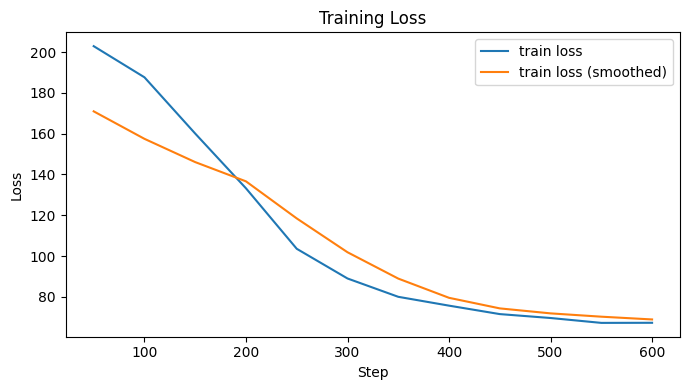

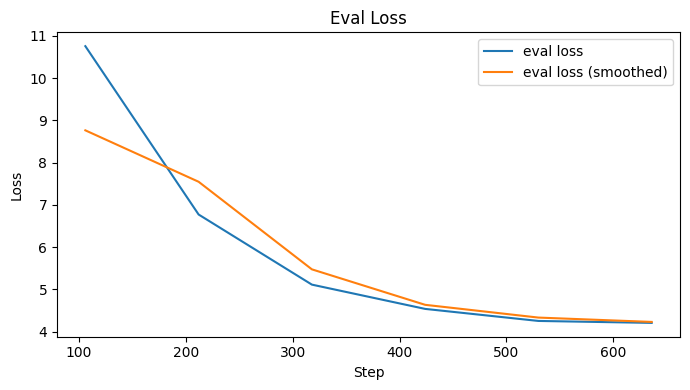

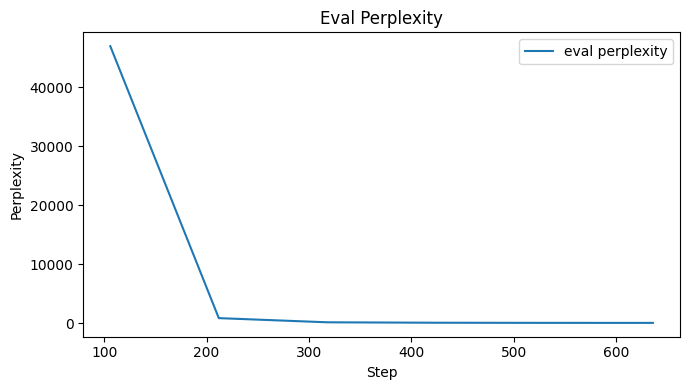

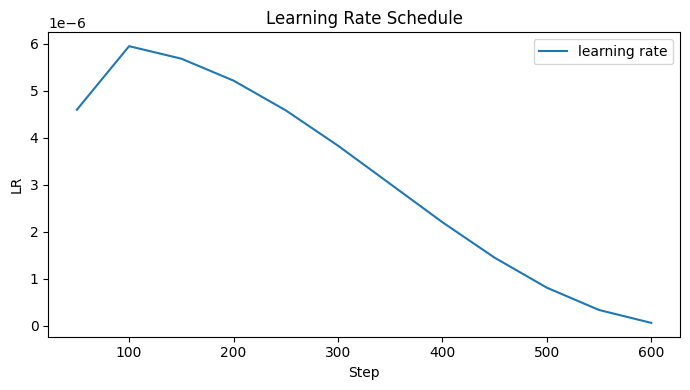

Best eval loss: 4.2080 at step 636 (perplexity ~ 67.22)
Final train loss: 67.2630 at step 600


In [ ]:
# ==== Example (fill your student base) ====
TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_135m-v3"

# TODO: Run KD on top-k only and on first epoch run CE only.
# -------- Trainer config --------
sft_cfg = SFTConfig(
    output_dir=out_dir,
    num_train_epochs=6,
    per_device_train_batch_size=4, #4
    gradient_accumulation_steps=16, #16    # eff batch ~64
    learning_rate=6e-6, # 2e-5
    lr_scheduler_type="cosine",
    warmup_ratio=0.1, # 0.08
    weight_decay=0.05,
    label_smoothing_factor=0.05,
    max_grad_norm=1.0,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss", # eval_loss
    greater_is_better=False,
    fp16=False, bf16=False,
    optim="adamw_bnb_8bit",
    packing=False,
    max_length=1024,
    gradient_checkpointing=False,
    remove_unused_columns=False,
    dataloader_num_workers=4,   # new
    dataloader_pin_memory=True,  # new
    report_to="none",
    seed=42,
)

try:
  trainer = train_kd_demo_qlora_student(
      STUDENT_ID="HuggingFaceTB/SmolLM2-135M",
      OUT_DIR=out_dir,
      DATASET_ID="zBotta/traffic-accidents-reports-5k", #800
      TEACHER_ID="zBotta/smollm2-accident-reporter-360m",
      KD_ALPHA=[0.85, 0.55],  # [start, end]
      KD_T=3.5, # increase T to smooth logit
      RANK=32, # lora rank = 16 for 135m distilled
      LORA_DROPOUT=0.1,
      sft_cfg=sft_cfg,
      MAX_LEN=1024,
      DEMO_PROB= 1.0, # 1.0
  )

  plot_training_results(out_dir, trainer)
except Exception as e:
  print(f"Error while training KD trainer: {e}")
  print("Desconnect Colab session")
  # from google.colab import runtime
  # runtime.unassign()

#### Diagnosis

In [ ]:
# %% DIAGNOSTICS: LoRA trainables, log tail, supervised-token fraction
import torch
from pprint import pprint

def kd_diagnostics(trainer, n_batches: int = 5):
    print("\n=== 1) LoRA / trainable parameters ===")
    trainable = [(n, p.numel()) for n, p in trainer.model.named_parameters() if p.requires_grad]
    total = sum(c for _, c in trainable)
    print(f"Total trainable params: {total:,}")
    print("First 20 trainables:")
    for name, cnt in trainable[:20]:
        print(f"  - {name}  ({cnt:,})")
    if total == 0:
        print("⚠️ No trainable params detected — LoRA may not be attached or target_modules don't match.")

    print("\n=== 2) Last ~20 log_history rows ===")
    logs = trainer.state.log_history
    tail = logs[-20:] if len(logs) >= 20 else logs
    for row in tail:
        pprint(row)

    print("\n=== 3) Supervised-token fraction over batches ===")
    dl = trainer.get_train_dataloader()
    fracs = []
    counts = 0
    for i, batch in enumerate(dl):
        if i >= n_batches: break
        labels = batch["labels"]
        mask = (labels != -100)
        frac = mask.float().mean().item()
        fracs.append(frac)
        counts += mask.numel()
        print(f"  batch {i:02d}: frac_supervised = {frac:.4f}  (batch_size={labels.size(0)}, seq_len={labels.size(1)})")
    if fracs:
        print(f"Average over {len(fracs)} batches: {sum(fracs)/len(fracs):.4f}")
    else:
        print("No batches read — check your train dataloader.")

# ---- run it (use your Trainer instance variable) ----
kd_diagnostics(trainer, n_batches=5)



=== 1) LoRA / trainable parameters ===
Total trainable params: 9,768,960
First 20 trainables:
  - base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight  (18,432)
  - base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight  (18,432)
  - base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight  (18,432)
  - base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight  (6,144)
  - base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight  (18,432)
  - base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight  (6,144)
  - base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight  (18,432)
  - base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight  (18,432)
  - base_model.model.model.layers.0.mlp.gate_proj.lora_A.default.weight  (18,432)
  - base_model.model.model.layers.0.mlp.gate_proj.lora_B.default.weight  (49,152)
  - base_model.model.model.layers.0.mlp.up_proj.lora_A.default.

### FInd best checkpoint (lowest loss)

In [ ]:
import os, json, glob

def find_best_ckpt(output_dir, metric="eval_loss", greater_is_better=False):
    state_path = os.path.join(output_dir, "trainer_state.json")
    if os.path.exists(state_path):
        st = json.load(open(state_path))
        return st.get("best_model_checkpoint"), st.get("best_metric")

    ckpts = sorted(glob.glob(os.path.join(output_dir, "checkpoint-*")))
    best, best_val = None, None
    for c in ckpts:
        sp = os.path.join(c, "trainer_state.json")
        if not os.path.exists(sp):
            continue
        hist = json.load(open(sp)).get("log_history", [])
        vals = [row[metric] for row in hist if metric in row]
        if not vals:
            continue
        v = vals[-1]  # last eval of that ckpt
        better = (v > best_val) if (greater_is_better and best_val is not None) else \
                 (v < best_val) if (not greater_is_better and best_val is not None) else True
        if better:
            best, best_val = c, v
    return best, best_val

best_dir, best_val = find_best_ckpt(OUT_DIR, metric="eval_loss", greater_is_better=False)
print("Best ckpt:", best_dir, "   eval_loss:", best_val)


### A/B testing

In [ ]:
!pip -q install rouge_score sacrebleu

# %% A/B capacity check with DEMO_PROB=1.0 (one-shot), deterministic decoding
import re, math, numpy as np, pandas as pd, torch
from datasets import load_dataset
from typing import Dict, Tuple, List
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import evaluate

TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_135m-v3"

# -----------------------
# CONFIG — edit these
# -----------------------
DATASET_ID   = "zBotta/traffic-accidents-reports-5k"   # has splits "train"/"eval" with keys: input, target
N_SAMPLES    = 200                                     # eval sample size
SEED         = 42
# Teacher (baseline) — can be merged or adapter
TEACHER_ID   = "zBotta/smollm2-accident-reporter-360m" # merged or repo id
# Student — EITHER adapter dir (+ base id) OR merged dir
STUDENT_BASE = "HuggingFaceTB/SmolLM2-135M"            # base for adapter case
STUDENT_PATH = out_dir + "/merged-fp16"                # e.g. "student_kd_output/adapter_best" OR "student_kd_output/merged-fp16"
IS_STUDENT_ADAPTER = False                              # True if STUDENT_PATH is an adapter dir; False if merged dir

MAX_LEN      = 1024
MAX_NEW      = 300     # ~350–400 chars
DEMO_PROB    = 1.0     # force 1-shot
DEMO_FROM    = "train" # pull demos from training split

# -----------------------
# Prompt builders
# -----------------------
INSTR = ("You are a reporting agent. Write ONE factual paragraph using ONLY the given facts "
         "(What, When, Where, Who, How, Why, ContingencyActions). Do not invent details.")
RESP_TMPL = "### Response:\n"

def one_line(s: str) -> str:
    return re.sub(r"\s+"," ", str(s).replace("\n"," ")).strip()

def build_prompt_with_demo(demo_in: str, demo_out: str, cur_in: str) -> str:
    return (
        "### Instruction:\n" + INSTR + "\n\n" +
        "### Input-example:\n" + one_line(demo_in) + "\n\n" +
        "### Output-example:\n" + one_line(demo_out) + "\n\n" +
        "### Input:\n" + one_line(cur_in) + "\n\n" +
        RESP_TMPL
    )

def build_prompt_no_demo(cur_in: str) -> str:
    return (
        "### Instruction:\n" + INSTR + "\n\n" +
        "### Input:\n" + one_line(cur_in) + "\n\n" +
        RESP_TMPL
    )

# -----------------------
# Light task metrics
# -----------------------
rouge = evaluate.load("rouge")
chrf  = evaluate.load("chrf")

GLUE_WORDS = set("""
a an and as at by for from in into near of on onto over to toward with without
the this that these those it its there their was were is are be been being
occurred happened caused due because following resulting then after before when while during around approximately about
no not minor major serious am pm km km/h mph minutes hours
""".split())

def parse_fields(inp: str) -> Dict[str, str]:
    # expects "What: ..., When: ..., Where: ..., Who: ..., How: ..., Why: ..., ContingencyActions: ..."
    fields = {}
    for key in ["What","When","Where","Who","How","Why","ContingencyActions"]:
        m = re.search(rf"{key}\s*:\s*(.*?)(?=(?:What|When|Where|Who|How|Why|ContingencyActions)\s*:|$)", inp, flags=re.I)
        fields[key.lower()] = one_line(m.group(1)) if m else ""
    return fields

def slot_coverage(pred: str, fields: Dict[str,str]) -> float:
    # crude: each non-empty field counts as 1 if any 6+ char substring or 2+ digit/time pattern appears in pred
    score, total = 0, 0
    for k, v in fields.items():
        if not v:
            continue
        total += 1
        v_l = v.lower()
        hit = False
        # try long substrings (words >= 6 chars) or numbers
        longs = [w for w in re.findall(r"[A-Za-z0-9:/._-]+", v_l) if (w.isdigit() or len(w) >= 6)]
        for token in longs[:6]:
            if token and token in pred.lower():
                hit = True; break
        # fallback: any overlap of 3+ distinct 3+char words
        if not hit:
            pred_w = set(w for w in re.findall(r"[A-Za-z0-9:/._-]+", pred.lower()) if len(w)>=3)
            v_w    = set(w for w in re.findall(r"[A-Za-z0-9:/._-]+", v_l) if len(w)>=3)
            if len((pred_w - GLUE_WORDS) & (v_w - GLUE_WORDS)) >= 3:
                hit = True
        score += 1 if hit else 0
    return score / max(1,total)

def hallucination_rate(pred: str, inp: str) -> float:
    # percent of content words (len>=4 or numbers) in pred that are NOT in the input
    pw = [w for w in re.findall(r"[A-Za-z0-9:/._-]+", pred.lower()) if (w.isdigit() or len(w)>=4)]
    if not pw: return 0.0
    iw = set(w for w in re.findall(r"[A-Za-z0-9:/._-]+", inp.lower()))
    extra = [w for w in pw if (w not in iw and w not in GLUE_WORDS)]
    return len(extra) / len(pw)

def repeat_3gram_ratio(pred: str) -> float:
    toks = re.findall(r"[A-Za-z0-9:/._-]+", pred.lower())
    if len(toks) < 6: return 0.0
    grams = [' '.join(toks[i:i+3]) for i in range(len(toks)-2)]
    total = len(grams)
    from collections import Counter
    c = Counter(grams)
    repeats = sum(v for v in c.values() if v>1)
    return repeats / total

# --- PAD/EOS repair + embedding resize + ban pad at decode ---
def ensure_distinct_pad(tok: AutoTokenizer, model: AutoModelForCausalLM | None = None):
    """Guarantee pad_token exists and != eos_token; if we add one, resize embeddings safely."""
    if tok.pad_token_id is None or tok.pad_token_id == tok.eos_token_id:
        tok.add_special_tokens({"pad_token": "<|pad|>"})
        if model is not None and hasattr(model, "get_input_embeddings"):
            if model.get_input_embeddings().num_embeddings != len(tok):
                model.resize_token_embeddings(len(tok))
    return tok

def det_generate(model, tok, prompt: str) -> str:
    enc = tok(prompt, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
    enc = {k: v.to(model.device) for k,v in enc.items()}
    # ban PAD token to avoid early stop/garbage
    bad_words_ids = [[tok.pad_token_id]] if tok.pad_token_id is not None else None
    with torch.inference_mode():
        out = model.generate(
            input_ids=enc["input_ids"], attention_mask=enc["attention_mask"],
            do_sample=False, max_new_tokens=MAX_NEW,
            no_repeat_ngram_size=4, repetition_penalty=1.20,
            eos_token_id=tok.eos_token_id, pad_token_id=tok.pad_token_id,
            bad_words_ids=bad_words_ids,
            renormalize_logits=True,
        )
    text = tok.decode(out[0], skip_special_tokens=True)
    return text.split(RESP_TMPL, 1)[-1].strip()

# -----------------------
# Load data + demo pool
# -----------------------
raw = load_dataset(DATASET_ID)
eval_full = raw["eval"]
train_full = raw["train"]
eval_idx = list(range(len(eval_full)))
rng = np.random.RandomState(SEED)
rng.shuffle(eval_idx)
eval_sel = [eval_full[i] for i in eval_idx[:N_SAMPLES]]

demo_pool = [(one_line(r["input"]), one_line(r["target"])) for r in train_full]

def make_prompt(example, i) -> Tuple[str, Dict[str,str]]:
    cur_in, cur_out = one_line(example["input"]), one_line(example["target"])
    if DEMO_PROB >= 1.0 and len(demo_pool) > 1:
        d_in, d_out = demo_pool[(i+1) % len(demo_pool)]
        p = build_prompt_with_demo(d_in, d_out, cur_in)
    else:
        p = build_prompt_no_demo(cur_in)
    return p, parse_fields(cur_in)

# -----------------------
# Load teacher (merged or adapter both OK)
# -----------------------
tok_t = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
model_t = AutoModelForCausalLM.from_pretrained(TEACHER_ID, torch_dtype=torch.float16, device_map="auto").eval()
tok_t = ensure_distinct_pad(tok_t, model_t)

# -----------------------
# Load student
# -----------------------
if IS_STUDENT_ADAPTER:
    tok_s = AutoTokenizer.from_pretrained(STUDENT_PATH, use_fast=True)
    base_s = AutoModelForCausalLM.from_pretrained(STUDENT_BASE, torch_dtype=torch.float16, device_map="auto")
    tok_s = ensure_distinct_pad(tok_s, base_s)   # ensure base embeds resized if we add PAD
    model_s = PeftModel.from_pretrained(base_s, STUDENT_PATH).eval()
else:
    tok_s = AutoTokenizer.from_pretrained(STUDENT_PATH, use_fast=True)
    model_s = AutoModelForCausalLM.from_pretrained(STUDENT_PATH, torch_dtype=torch.float16, device_map="auto").eval()
    tok_s = ensure_distinct_pad(tok_s, model_s)

# -----------------------
# Evaluate
# -----------------------
rows = []
refs_360, preds_360 = [], []
refs_135, preds_135 = [], []

for i, ex in enumerate(eval_sel):
    prompt, slots = make_prompt(ex, i)
    ref = one_line(ex["target"])

    # TEACHER
    pred_t = det_generate(model_t, tok_t, prompt)
    refs_360.append(ref); preds_360.append(pred_t)
    rows.append({
        "model": "teacher_360M",
        "slot_cov": slot_coverage(pred_t, slots),
        "halluc": hallucination_rate(pred_t, ex["input"]),
        "repeat3": repeat_3gram_ratio(pred_t),
        "len": len(pred_t),
    })

    # STUDENT
    pred_s = det_generate(model_s, tok_s, prompt)
    refs_135.append(ref); preds_135.append(pred_s)
    rows.append({
        "model": "student_135M",
        "slot_cov": slot_coverage(pred_s, slots),
        "halluc": hallucination_rate(pred_s, ex["input"]),
        "repeat3": repeat_3gram_ratio(pred_s),
        "len": len(pred_s),
    })

# corpus metrics
def corpus_metrics(refs, preds):
    r = rouge.compute(references=refs, predictions=preds, use_stemmer=True)
    c = chrf.compute(references=refs, predictions=preds)
    return {"rougeL": r["rougeL"], "chrf": c["score"]}

corp_360 = corpus_metrics(refs_360, preds_360)
corp_135 = corpus_metrics(refs_135, preds_135)

df = pd.DataFrame(rows).groupby("model").agg(
    slot_cov=("slot_cov","mean"),
    halluc=("halluc","mean"),
    repeat3=("repeat3","mean"),
    len=("len","mean"),
).reset_index()

for k,v in corp_360.items(): df.loc[df["model"]=="teacher_360M", k] = v
for k,v in corp_135.items():  df.loc[df["model"]=="student_135M", k] = v

print("\n=== A/B — DEMO_PROB=1.0, deterministic decoding (PAD≠EOS, PAD banned) ===")
print(df.to_string(index=False))


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`



=== A/B — DEMO_PROB=1.0, deterministic decoding (PAD≠EOS, PAD banned) ===
       model  slot_cov   halluc  repeat3    len   rougeL      chrf
student_135M  0.000714 0.427365 0.004073 212.19 0.006943  7.363948
teacher_360M  0.772857 0.709367 0.000889 676.23 0.226017 38.400659


In [ ]:
!pip install rouge_score sacrebleu
# %% A/B capacity check with DEMO_PROB=1.0 (one-shot), deterministic decoding
import re, math, numpy as np, pandas as pd, torch
from datasets import load_dataset
from typing import Dict, Tuple, List
from transformers import AutoTokenizer, AutoModelForCausalLM, LogitsProcessorList
from peft import PeftModel
import evaluate

TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_135m-v3"
# -----------------------
# CONFIG — edit these
# -----------------------
DATASET_ID   = "zBotta/traffic-accidents-reports-5k"   # has splits "train"/"eval" with keys: input, target
N_SAMPLES    = 200                                     # eval sample size
SEED         = 42
# Teacher (baseline) — can be merged or adapter
TEACHER_ID   = "zBotta/smollm2-accident-reporter-360m" # merged or repo id
# Student — EITHER adapter dir (+ base id) OR merged dir
STUDENT_BASE = "HuggingFaceTB/SmolLM2-135M"            # base for adapter case
STUDENT_PATH = out_dir + "/merged-fp16"   # e.g. "student_kd_output/adapter_best" OR "student_kd_output/merged-fp16"
IS_STUDENT_ADAPTER = False                               # True if STUDENT_PATH is an adapter dir; False if merged dir

MAX_LEN      = 1024
MAX_NEW      = 300     # ~350–400 chars
DEMO_PROB    = 1.0     # force 1-shot
DEMO_FROM    = "train" # pull demos from training split

# -----------------------
# Prompt builders
# -----------------------
INSTR = ("You are a reporting agent. Write ONE factual paragraph using ONLY the given facts "
         "(What, When, Where, Who, How, Why, ContingencyActions). Do not invent details.")
RESP_TMPL = "### Response:\n"

def one_line(s: str) -> str:
    return re.sub(r"\s+"," ", str(s).replace("\n"," ")).strip()

def build_prompt_with_demo(demo_in: str, demo_out: str, cur_in: str) -> str:
    return (
        "### Instruction:\n" + INSTR + "\n\n" +
        "### Input-example:\n" + one_line(demo_in) + "\n\n" +
        "### Output-example:\n" + one_line(demo_out) + "\n\n" +
        "### Input:\n" + one_line(cur_in) + "\n\n" +
        RESP_TMPL
    )

def build_prompt_no_demo(cur_in: str) -> str:
    return (
        "### Instruction:\n" + INSTR + "\n\n" +
        "### Input:\n" + one_line(cur_in) + "\n\n" +
        RESP_TMPL
    )

# -----------------------
# Light task metrics
# -----------------------
rouge = evaluate.load("rouge")
chrf  = evaluate.load("chrf")

GLUE_WORDS = set("""
a an and as at by for from in into near of on onto over to toward with without
the this that these those it its there their was were is are be been being
occurred happened caused due because following resulting then after before when while during around approximately about
no not minor major serious am pm km km/h mph minutes hours
""".split())

def parse_fields(inp: str) -> Dict[str, str]:
    # expects "What: ..., When: ..., Where: ..., Who: ..., How: ..., Why: ..., ContingencyActions: ..."
    fields = {}
    for key in ["What","When","Where","Who","How","Why","ContingencyActions"]:
        m = re.search(rf"{key}\s*:\s*(.*?)(?=(?:What|When|Where|Who|How|Why|ContingencyActions)\s*:|$)", inp, flags=re.I)
        fields[key.lower()] = one_line(m.group(1)) if m else ""
    return fields

def slot_coverage(pred: str, fields: Dict[str,str]) -> float:
    # crude: each non-empty field counts as 1 if any 6+ char substring or 2+ digit/time pattern appears in pred
    score, total = 0, 0
    for k, v in fields.items():
        if not v:
            continue
        total += 1
        v_l = v.lower()
        hit = False
        # try long substrings (words >= 6 chars) or numbers
        longs = [w for w in re.findall(r"[A-Za-z0-9:/._-]+", v_l) if (w.isdigit() or len(w) >= 6)]
        for token in longs[:6]:
            if token and token in pred.lower():
                hit = True; break
        # fallback: any overlap of 3+ distinct 3+char words
        if not hit:
            pred_w = set(w for w in re.findall(r"[A-Za-z0-9:/._-]+", pred.lower()) if len(w)>=3)
            v_w    = set(w for w in re.findall(r"[A-Za-z0-9:/._-]+", v_l) if len(w)>=3)
            if len((pred_w - GLUE_WORDS) & (v_w - GLUE_WORDS)) >= 3:
                hit = True
        score += 1 if hit else 0
    return score / max(1,total)

def hallucination_rate(pred: str, inp: str) -> float:
    # percent of content words (len>=4 or numbers) in pred that are NOT in the input
    pw = [w for w in re.findall(r"[A-Za-z0-9:/._-]+", pred.lower()) if (w.isdigit() or len(w)>=4)]
    if not pw: return 0.0
    iw = set(w for w in re.findall(r"[A-Za-z0-9:/._-]+", inp.lower()))
    extra = [w for w in pw if (w not in iw and w not in GLUE_WORDS)]
    return len(extra) / len(pw)

def repeat_3gram_ratio(pred: str) -> float:
    toks = re.findall(r"[A-Za-z0-9:/._-]+", pred.lower())
    if len(toks) < 6: return 0.0
    grams = [' '.join(toks[i:i+3]) for i in range(len(toks)-2)]
    total = len(grams)
    from collections import Counter
    c = Counter(grams)
    repeats = sum(v for v in c.values() if v>1)
    return repeats / total

def det_generate(model, tok, prompt: str) -> str:
    enc = tok(prompt, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
    enc = {k: v.to(model.device) for k,v in enc.items()}
    with torch.inference_mode():
        out = model.generate(
            input_ids=enc["input_ids"], attention_mask=enc["attention_mask"],
            do_sample=False, max_new_tokens=MAX_NEW,
            no_repeat_ngram_size=4, repetition_penalty=1.20,
            eos_token_id=tok.eos_token_id, pad_token_id=tok.pad_token_id,
            renormalize_logits=True,
        )
    text = tok.decode(out[0], skip_special_tokens=True)
    return text.split(RESP_TMPL, 1)[-1].strip()

# -----------------------
# Load data + demo pool
# -----------------------
raw = load_dataset(DATASET_ID)
eval_full = raw["eval"]
train_full = raw["train"]
eval_idx = list(range(len(eval_full)))
rng = np.random.RandomState(SEED)
rng.shuffle(eval_idx)
eval_sel = [eval_full[i] for i in eval_idx[:N_SAMPLES]]

demo_pool = [(one_line(r["input"]), one_line(r["target"])) for r in train_full]

def make_prompt(example, i) -> Tuple[str, Dict[str,str]]:
    cur_in, cur_out = one_line(example["input"]), one_line(example["target"])
    if DEMO_PROB >= 1.0 and len(demo_pool) > 1:
        d_in, d_out = demo_pool[(i+1) % len(demo_pool)]
        p = build_prompt_with_demo(d_in, d_out, cur_in)
    else:
        p = build_prompt_no_demo(cur_in)
    return p, parse_fields(cur_in)

# -----------------------
# Load teacher (merged or adapter both OK)
# -----------------------
tok_t = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
if tok_t.pad_token_id is None: tok_t.pad_token = tok_t.eos_token
model_t = AutoModelForCausalLM.from_pretrained(TEACHER_ID, torch_dtype=torch.float16, device_map="auto").eval()

# -----------------------
# Load student
# -----------------------
if IS_STUDENT_ADAPTER:
    tok_s = AutoTokenizer.from_pretrained(STUDENT_PATH, use_fast=True)
    if tok_s.pad_token_id is None: tok_s.pad_token = tok_s.eos_token
    base_s = AutoModelForCausalLM.from_pretrained(STUDENT_BASE, torch_dtype=torch.float16, device_map="auto")
    model_s = PeftModel.from_pretrained(base_s, STUDENT_PATH).eval()
else:
    tok_s = AutoTokenizer.from_pretrained(STUDENT_PATH, use_fast=True)
    if tok_s.pad_token_id is None: tok_s.pad_token = tok_s.eos_token
    model_s = AutoModelForCausalLM.from_pretrained(STUDENT_PATH, torch_dtype=torch.float16, device_map="auto").eval()

# -----------------------
# Evaluate
# -----------------------
rows = []
refs_360, preds_360 = [], []
refs_135, preds_135 = [], []

for i, ex in enumerate(eval_sel):
    prompt, slots = make_prompt(ex, i)
    ref = one_line(ex["target"])

    # TEACHER
    pred_t = det_generate(model_t, tok_t, prompt)
    refs_360.append(ref); preds_360.append(pred_t)
    rows.append({
        "model": "teacher_360M",
        "slot_cov": slot_coverage(pred_t, slots),
        "halluc": hallucination_rate(pred_t, ex["input"]),
        "repeat3": repeat_3gram_ratio(pred_t),
        "len": len(pred_t),
    })

    # STUDENT
    pred_s = det_generate(model_s, tok_s, prompt)
    refs_135.append(ref); preds_135.append(pred_s)
    rows.append({
        "model": "student_135M",
        "slot_cov": slot_coverage(pred_s, slots),
        "halluc": hallucination_rate(pred_s, ex["input"]),
        "repeat3": repeat_3gram_ratio(pred_s),
        "len": len(pred_s),
    })

# corpus metrics
def corpus_metrics(refs, preds):
    r = rouge.compute(references=refs, predictions=preds, use_stemmer=True)
    c = chrf.compute(references=refs, predictions=preds)
    return {"rougeL": r["rougeL"], "chrf": c["score"]}

corp_360 = corpus_metrics(refs_360, preds_360)
corp_135 = corpus_metrics(refs_135, preds_135)

df = pd.DataFrame(rows).groupby("model").agg(
    slot_cov=("slot_cov","mean"),
    halluc=("halluc","mean"),
    repeat3=("repeat3","mean"),
    len=("len","mean"),
).reset_index()

for k,v in corp_360.items(): df.loc[df["model"]=="teacher_360M", k] = v
for k,v in corp_135.items():  df.loc[df["model"]=="student_135M", k] = v

print("\n=== A/B — DEMO_PROB=1.0, deterministic decoding ===")
print(df.to_string(index=False))



=== A/B — DEMO_PROB=1.0, deterministic decoding ===
       model  slot_cov   halluc  repeat3     len   rougeL      chrf
student_135M  0.000000 0.422536 0.001756 117.585 0.007801  6.212200
teacher_360M  0.772857 0.708340 0.000794 604.885 0.227983 39.552555


#### Conclusion

- student_135M: slot_cov ≈ 0.0007, ROUGE-L ≈ 0.007, length ≈ 212 → it’s still not grounding in the facts even after the PAD≠EOS fix.

- teacher_360M: slot_cov ≈ 0.77, strong relative quality.

So, with DEMO_PROB=1.0 the 135M is too small in its current setup.

Here’s the least-pain path forward depending on your constraint:

If you must keep 1-shot demos

**Use the 360M**. It already meets your slot coverage target and behaves with the same prompt. This is the pragmatic choice.

### Push Distilled model to HF

In [ ]:
repo_id = "zBotta/smollm2-135m-accident-reporting-distilled-kd360m-v3"

from huggingface_hub import HfApi, create_repo, upload_folder, login
merged_dir = f"{out_dir}/merged-fp16" # we should push the adapter model
from google.colab import userdata
hf_token = userdata.get('hf_token')

login(token=hf_token)

api = HfApi(token=hf_token)
try:
  api.create_repo(repo_id, private=False, repo_type="model")
except Exception as e:
  print(f"Repo model {repo_id} already created")
upload_folder(folder_path=merged_dir, repo_id=repo_id, repo_type="model")
print("Pushed:", repo_id)

Repo model zBotta/smollm2-135m-accident-reporting-distilled-kd360m-v3 already created


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...5m-v3/merged-fp16/model.safetensors:  12%|#2        | 33.5MB /  269MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Pushed: zBotta/smollm2-135m-accident-reporting-distilled-kd360m-v3


 ### Testing Student before and after merge

In [ ]:
# %% Sanity test: deterministic generation with soft constraints + meta blockers
import re, torch
from typing import Set, List
from transformers import AutoTokenizer, AutoModelForCausalLM, LogitsProcessor, LogitsProcessorList
from peft import PeftModel

# --- paths ---
ADAPTER_DIR = f"{out_dir}/adapter"            # e.g., f"{OUT_DIR}/adapter_best"
BASE_ID     = "HuggingFaceTB/SmolLM2-135M"        # your student base

# --- prompt (match your training style exactly) ---
INSTR = (
  "You are a reporting agent. Write ONE factual paragraph using ONLY the given facts "
  "(What, When, Where, Who, How, Why, ContingencyActions). Do not invent details."
)
facts = (
  "What: Rear-end collision involving two cars; "
  "When: 2025-08-18 08:25; "
  "Where: A86 Nanterre exit 6; "
  "Who: Driver A, Driver B; "
  "How: Sudden braking in slow traffic; "
  "Why: Following distance insufficient; "
  "ContingencyActions: Police notified, no injuries, vehicles moved to shoulder."
)
def make_prompt(f): return f"### Instruction:\n{INSTR}\n\n### Input:\n{f}\n\n### Response:\n"

# --- load tokenizer from the ADAPTER directory (important!) ---
tok = AutoTokenizer.from_pretrained(ADAPTER_DIR, use_fast=True)
if tok.pad_token_id is None: tok.pad_token = tok.eos_token

# --- load model: base + adapter (eval) ---
base  = AutoModelForCausalLM.from_pretrained(BASE_ID, torch_dtype=torch.float16, device_map="auto")
stud  = PeftModel.from_pretrained(base, ADAPTER_DIR).eval()
if hasattr(stud, "tie_weights"): stud.tie_weights()

# ---------- helpers for soft restriction ----------
SAFE_GLUE = {
    "a","an","and","as","at","by","for","from","in","into","near","of","on","onto","over","to","toward","with","without",
    "the","this","that","these","those","it","its","there","their",
    "was","were","is","are","be","been","being","occurred","happened","caused","due","because","following","resulting",
    "then","after","before","when","while","during","around","approximately","about",
    "no","not","minor","major","serious",
    "police","emergency","traffic","response","arrived","secured","redirected","moved","shoulder","lane","exit","road",
    "vehicle","vehicles","driver","drivers","injury","injuries","damage","collision","crash","incident","report",
    "am","pm","km","km/h","mph","minutes","hours", ",",".",";","-","—",":","/"
}
def normalize_words(text: str) -> List[str]:
    t = re.sub(r"[\n\t]+", " ", text)
    return re.findall(r"[A-Za-z0-9:/._-]+", t)

def build_allowed_token_ids(tok, facts_text: str) -> Set[int]:
    words = set(w.lower() for w in normalize_words(facts_text)) | SAFE_GLUE
    words |= {w.capitalize() for w in list(words) if w and w[0].isalpha()}
    allowed: Set[int] = set()
    for w in words:
        allowed.update(tok(w, add_special_tokens=False).input_ids)
    allowed.update(tok(facts_text, add_special_tokens=False).input_ids)
    if tok.eos_token_id is not None: allowed.add(tok.eos_token_id)
    if tok.pad_token_id is not None: allowed.add(tok.pad_token_id)
    return allowed

class SoftRestrictedVocab(LogitsProcessor):
    """Softly penalize tokens outside allowed set; warmup + ramp to avoid choking openers."""
    def __init__(self, allowed_ids: Set[int], penalty: float = 2.0, warmup: int = 8, ramp: int = 16):
        self.allowed = torch.tensor(sorted(list(allowed_ids)), dtype=torch.long)
        self.penalty, self.warmup, self.ramp = float(penalty), int(warmup), int(ramp)
    def __call__(self, input_ids, scores):
        step_after_prompt = input_ids.size(1)
        if step_after_prompt <= self.warmup: cur_pen = 0.0
        elif step_after_prompt <= self.warmup + self.ramp:
            cur_pen = self.penalty * (step_after_prompt - self.warmup) / max(1, self.ramp)
        else:
            cur_pen = self.penalty
        if cur_pen <= 1e-8: return scores
        if self.allowed.device != scores.device:
            self.allowed = self.allowed.to(scores.device)
        B, V = scores.shape
        keep = torch.zeros((B, V), dtype=torch.bool, device=scores.device)
        keep.scatter_(1, self.allowed.unsqueeze(0).expand(B, -1), True)
        scores = scores - (cur_pen * (~keep).to(scores.dtype))
        return scores

# --- build bad-words list to block meta/section drift ---
block_phrases = ["###", "Question", "Answer", "Explanation", "example", "following", "subject", "topic"]
bad_words_ids = [tok(p, add_special_tokens=False).input_ids for p in block_phrases if tok(p, add_special_tokens=False).input_ids]

# --- encode & generate deterministically with guards ---
prompt = make_prompt(facts)
enc = tok(prompt, return_tensors="pt", padding=True, truncation=True, max_length=1024)
enc = {k: v.to(stud.device) for k,v in enc.items()}

allowed_ids = build_allowed_token_ids(tok, facts)
processors = LogitsProcessorList([SoftRestrictedVocab(allowed_ids, penalty=2.0, warmup=8, ramp=16)])

with torch.inference_mode():
    out = stud.generate(
        input_ids=enc["input_ids"], attention_mask=enc["attention_mask"],
        do_sample=False, max_new_tokens=140,
        no_repeat_ngram_size=4, repetition_penalty=1.20,
        logits_processor=processors,
        bad_words_ids=bad_words_ids,          # <-- block meta headers/QA words
        eos_token_id=tok.eos_token_id, pad_token_id=tok.pad_token_id,
        renormalize_logits=True,
    )

text = tok.decode(out[0], skip_special_tokens=True)
resp = text.split("### Response:\n", 1)[-1].strip()
resp = re.sub(r"\s+", " ", resp)
print("\n=== CLEAN ONE-PARAGRAPH REPORT ===")
print(resp)



=== CLEAN ONE-PARAGRAPH REPORT ===
The following is an example of response from student.


In [ ]:
# [Test cell] Teacher vs Student (adapter) vs Merged — side-by-side generation check
# Fills the three cases:
# 1) Teacher (must look clean)
# 2) Student BEFORE merge (base + LoRA adapter)
# 3) Freshly merged FP16 checkpoint (after tie-weights)
#
# Edit the IDs/paths and the prompt facts below, then run.

import torch, re, os, json
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_135m-v3"

# ========= EDIT THESE =========
TEACHER_ID   = "zBotta/smollm2-accident-reporter-360m"   # your trained teacher
STUDENT_ID   = "HuggingFaceTB/SmolLM2-135M"              # base student architecture
ADAPTER_DIR  = out_dir + "/adapter"               # path to your distilled LoRA adapter (checkpoint with adapter_config.json)
MERGED_DIR   = out_dir + "/merged-fp16"           # path to your merged FP16 checkpoint (config.json + model.safetensors)


INSTR = ("You are a reporting agent. Write ONE factual paragraph using ONLY the given facts "
         "(What, When, Where, Who, How, Why, ContingencyActions). Do not invent details.")
facts = ("What: Rear-end collision involving two cars; When: 2025-08-18 08:25; "
         "Where: A86 Nanterre exit 6; Who: Driver A, Driver B; "
         "How: Sudden braking in slow traffic; Why: Following distance insufficient; "
         "ContingencyActions: Police notified, no injuries, vehicles moved to shoulder.")

def make_prompt(facts: str) -> str:
    return f"### Instruction:\n{INSTR}\n\n### Input:\n{facts}\n\n### Response:\n"

GEN_KW = dict(
    do_sample=False,
    max_new_tokens=180,
    no_repeat_ngram_size=4,
    repetition_penalty=1.20,
    renormalize_logits=True,
)

def ensure_pad(tok):
    """If tokenizer has no PAD, set PAD=EOS to allow padding. No vocab resize needed."""
    if tok.pad_token_id is None:
        tok.pad_token = tok.eos_token
    return tok

def _decode_after_response(text: str) -> str:
    part = text.split("### Response:\n", 1)
    return (part[1] if len(part) > 1 else text).strip()

def _gen_once(model, tok, prompt: str) -> str:
    tok = ensure_pad(tok)  # <-- FIX: make sure PAD exists before padding=True
    enc = tok(prompt, return_tensors="pt", padding=True, truncation=True, max_length=1024)
    enc = {k: v.to(model.device) for k, v in enc.items()}
    pad_id = tok.pad_token_id if tok.pad_token_id is not None else tok.eos_token_id
    with torch.inference_mode():
        out = model.generate(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],  # critical when PAD==EOS
            eos_token_id=tok.eos_token_id,
         º   pad_token_id=pad_id,
            **GEN_KW,
        )
    txt = tok.decode(out[0], skip_special_tokens=True)
    return re.sub(r"\s+", " ", _decode_after_response(txt))

def _tie(model):
    if hasattr(model, "tie_weights"):
        model.tie_weights()

# 1) Teacher
print("\n=== 1) TEACHER ===")
tok_t = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
mdl_t = AutoModelForCausalLM.from_pretrained(TEACHER_ID, torch_dtype=torch.float16, device_map="auto")
_tie(mdl_t)
print(_gen_once(mdl_t, tok_t, make_prompt(facts)))

# 2) Student BEFORE merge (base + adapter)
print("\n=== 2) STUDENT (base + adapter) ===")
assert os.path.isdir(ADAPTER_DIR), f"Adapter path not found: {ADAPTER_DIR}"
tok_s = AutoTokenizer.from_pretrained(STUDENT_ID, use_fast=True)
base   = AutoModelForCausalLM.from_pretrained(STUDENT_ID, torch_dtype=torch.float16, device_map="auto")
student_adapter = PeftModel.from_pretrained(base, ADAPTER_DIR)
student_adapter.eval(); _tie(student_adapter)
print(_gen_once(student_adapter, tok_s, make_prompt(facts)))

# 3) MERGED FP16
print("\n=== 3) MERGED FP16 ===")
assert os.path.isdir(MERGED_DIR), f"Merged dir not found: {MERGED_DIR}"
tok_m = AutoTokenizer.from_pretrained(MERGED_DIR, use_fast=True)  # load tokenizer saved with merged
mdl_m = AutoModelForCausalLM.from_pretrained(MERGED_DIR, torch_dtype=torch.float16, device_map="auto")
_tie(mdl_m)
print(_gen_once(mdl_m, tok_m, make_prompt(facts)))



=== 1) TEACHER ===
On August 18, 20xx at 0825 on Exit 6 of Nanterre's A86 exit, Vehicle A rear-ended Vehicle B due to sudden stop and lack of space. No serious injuries reported. Both drivers were informed by police and both vehicles driven offside. Minor damage was noted but minor. The accident occurred during heavy morning rush hour traffic. No other involved parties or vehicle descriptions known. Police arrived promptly with assistance. Traffic flow resumed shortly after removal of affected vehicles from the road.

=== 2) STUDENT (base + adapter) ===
The following is an example of response from student’s responses for this question type questions on the same topic area and subject matter areas as above mentioned below : Question Type Answer Explanation Question No. 3479 What was the reason why the car accident happened? The driver had been driving too fast while he got into his vehicle which caused crash accidents between both drivers. It also cause that there were some other peopl

## Distillation v4.0 - SmolLM2-1.7B (teacher) KD to SmolLM2-360M (student)

In [ ]:
# ==== ONE-CELL: KD + QLoRA (student), optional KD gen from gold, eval & latency ====
!pip -q install -U "transformers>=4.43" "accelerate>=0.33" "datasets>=2.20" peft bitsandbytes trl evaluate sacrebleu rouge_score

import os, re, json, math, time, random
import numpy as np, torch
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import evaluate
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets, load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, EarlyStoppingCallback, GenerationConfig
from peft import LoraConfig, PeftModel
from trl import SFTConfig, SFTTrainer
from huggingface_hub import login
from transformers import TrainerCallback
import gc

from google.colab import userdata
hf_token = userdata.get('hf_token')
login(token=hf_token)

# speed & stability on T4 with bnbkl_topk
torch.backends.cuda.matmul.allow_tf32 = True
os.environ["ACCELERATE_MIXED_PRECISION"] = "no"

def train_kd_demo_qlora_student(
    STUDENT_ID: str = "motionlabs/AMD-Llama-350M-Upgraded",      # Llama-style tiny student
    TEACHER_ID: str = "meta-llama/Llama-3.2-3B-Instruct",        # Teacher
    OUT_DIR: str = "student_kd_output",
    GOLD_DATASET_ID: str = "zBotta/traffic-accidents-reports-5k", # 5k
    KD_DATASET_REPO: Optional[str] = "zBotta/traffic-accidents-reports-kd-smollm2-360M-7k",  # try first
    USE_KD_DATASET: bool = False,
    DEMO_PROB: float = 0.8,
    KD_ALPHA: list = [0.85, 0.65],     # [start, end]  # CE weight (KL gets 1-KD_ALPHA)
    KD_T: float = 2.0,                 # temperature for KD
    KD_TOP_K: int = 128,
    SOFT_KD_WMIN: float = 0.05,
    SOFT_KD_GAMMA = 2.0,
    BETA_UL=0.1,
    RANK: int = 8,
    LORA_DROPOUT: float = 0.05,
    sft_cfg: Optional[SFTConfig] = None,
    MAX_LEN: int = 1024,
    EVAL_N: int = 5,                   # number of evaluation examples for metrics & latency
    GEN_MAX_NEW: int = 256,            # generation budget for eval/latency
):
    """
    Distill Llama-3.2-3B-Instruct into a ~350M student with logit KD (+ CE).
    - Loads KD dataset if available; otherwise generates teacher targets from GOLD.
    - Trains student with response-only labels (always appends EOS).
    - Saves LoRA and merged FP16.
    - Evaluates teacher & student on 5 samples (ROUGE-Lsum, SacreBLEU) + latency test.
    Returns: trainer
    """
    os.makedirs(OUT_DIR, exist_ok=True)

    RESP_TMPL = "### Response:\n"
    # INSTR = ("You are a reporting agent. Write ONE factual paragraph using ONLY the given facts "
    #          "(What, When, Where, Who, How, Why, ContingencyActions). Do not invent details.")
    INSTR = (
    """
    You are a reporting agent.
    You task is to create a report when provided the what, when, why, who, how and where questions about the events.
    You are also given information about the contingency actions regarding the event.

    Guidelines:
    - Generate only one report given the informations about the event
    - Generate the report as text in one paragraph
    - It is important to focus on accuracy and coherence when generating the report so that the description content matches the information provided (what, when, where, who, how , why, contingency actions).
      If an information is not provided in (what, when, where, who, how , why, contingency actions), it must not be part of the generated text description.
    """
    )

    def one_line(s: str) -> str:
        return re.sub(r"\s+", " ", str(s).replace("\n", " ")).strip()

    def prompt_with_demo(demo_in: str, demo_out: str, current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input-example:\n" + demo_in + "\n\n" +
            "### Output-example:\n" + one_line(demo_out) + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

    def prompt_no_demo(current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

    # -------- Load GOLD dataset (needed for demos & fallback) --------
    raw_gold = load_dataset(GOLD_DATASET_ID)  # expects splits "train"/"eval" with 'input' and 'target'
    assert "train" in raw_gold and "eval" in raw_gold, "Gold dataset must have 'train' and 'eval'."
    def ok(r): return bool(str(r.get("input","")).strip()) and bool(str(r.get("target","")).strip())
    ds_gold = DatasetDict(train=raw_gold["train"].filter(ok), eval=raw_gold["eval"].filter(ok))
    demo_pool: List[Tuple[str,str]] = [(one_line(r["input"]), one_line(r["target"])) for r in ds_gold["train"]]

    # -------- Tokenizers (keep separate; require equality for logit KD) --------
    tok_student = AutoTokenizer.from_pretrained(STUDENT_ID, use_fast=True)
    tok_teacher = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
    if tok_student.pad_token_id is None: tok_student.pad_token = tok_student.eos_token
    if tok_teacher.pad_token_id is None: tok_teacher.pad_token = tok_teacher.eos_token

    # Hard requirement for logit KD: tokenizer vocabularies must match exactly.
    if tok_student.get_vocab() != tok_teacher.get_vocab():
        raise RuntimeError(
            "Tokenizer mismatch: student and teacher must share IDENTICAL vocab for logit KD.\n"
            f"Student vocab size={len(tok_student)}, Teacher vocab size={len(tok_teacher)}.\n"
            "Pick a student with the exact same tokenizer as the teacher, or disable logit KD."
        )

    # -------- 4-bit quant config --------
    bnb4 = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.float16
    )

    # -------- Try to load KD dataset; if missing -> generate teacher outputs from GOLD --------
    def try_load_kd_repo(repo_id: Optional[str]) -> Optional[DatasetDict]:
        if not repo_id: return None
        try:
            ds = load_dataset(repo_id)
            if "train" in ds and "eval" in ds and all(k in ds["train"].column_names for k in ("input","target")):
                print(f"✅ KD dataset loaded from: {repo_id}")
                return DatasetDict(train=ds["train"], eval=ds["eval"])
            else:
                print(f"⚠️ KD repo {repo_id} missing expected splits/columns; will generate from GOLD.")
                return None
        except Exception as e:
            print(f"⚠️ Could not load KD repo {repo_id}: {e}\nWill generate teacher outputs from GOLD.")
            return None

    if USE_KD_DATASET:
      ds_base = try_load_kd_repo(KD_DATASET_REPO)
      need_kd_from_gold = ds_base is None
    else:
      ds_base = ds_gold
      need_kd_from_gold = False

     # -------- Teacher model for logits & optional text gen --------
    teacher_for_logits = AutoModelForCausalLM.from_pretrained(
        TEACHER_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto"
    ).eval()
    for p in teacher_for_logits.parameters(): p.requires_grad_(False)

    def gen_teacher_texts(ds: Dataset, batch_size: int = 4, max_new: int = 256) -> List[str]:
        """Generate teacher texts for ds['input'] with the same prompting scheme (no demo)."""
        outs = []
        for i in range(0, len(ds), batch_size):
            batch = ds[i:i+batch_size]
            prompts = [prompt_no_demo(one_line(x)) for x in batch["input"]]
            enc = tok_teacher(prompts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(teacher_for_logits.device)
            gen = teacher_for_logits.generate(
                **enc, do_sample=False, temperature=1.0, max_new_tokens=max_new,
                eos_token_id=tok_teacher.eos_token_id, pad_token_id=tok_teacher.pad_token_id
            )
            for j in range(len(prompts)):
                text = tok_teacher.decode(gen[j][enc["input_ids"].shape[1]:], skip_special_tokens=True)
                outs.append(one_line(text))
        return outs

    if need_kd_from_gold:
        print("🛠 Generating teacher outputs from GOLD for KD...")
        # Use teacher outputs as targets (pure distillation fallback)
        kd_train_out = gen_teacher_texts(ds_gold["train"])
        kd_eval_out  = gen_teacher_texts(ds_gold["eval"])
        ds_base = DatasetDict(
            train = ds_gold["train"].add_column("target", kd_train_out),
            eval  = ds_gold["eval"].add_column("target",  kd_eval_out),
        )

    # -------- Tokenize (response-only labels) --------
    def add_demo_and_tokenize(example, idx):
        cur_in, cur_out = one_line(example["input"]), one_line(example["target"])
        use_demo = (np.random.rand() < DEMO_PROB) and (len(demo_pool) > 1)
        if use_demo:
            d_in, d_out = demo_pool[(idx+1) % len(demo_pool)]
            prompt = prompt_with_demo(d_in, d_out, cur_in)
        else:
            prompt = prompt_no_demo(cur_in)

        prom = tok_student(prompt, add_special_tokens=True, truncation=True, max_length=MAX_LEN)
        prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        # fallback to no-demo if too tight
        if len(prompt_ids) >= MAX_LEN - 4:
            prom = tok_student(prompt_no_demo(cur_in), add_special_tokens=True, truncation=True, max_length=MAX_LEN)
            prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        eos = tok_student.eos_token_id
        if eos is None:
            tok_student.pad_token = tok_student.eos_token
            eos = tok_student.eos_token_id

        budget = MAX_LEN - len(prompt_ids)
        if budget <= 0:
            prompt_ids = prompt_ids[:-1]
            attn_prompt = attn_prompt[:-1]
            budget = 1

        allow = max(0, budget - 1)
        targ_ids = tok_student(cur_out, add_special_tokens=False, truncation=True, max_length=max(1, allow)).input_ids
        targ_ids = targ_ids[:allow]

        target_with_eos = targ_ids + [eos]
        input_ids      = prompt_ids + target_with_eos
        attention_mask = attn_prompt + [1] * len(target_with_eos)
        labels         = [-100] * len(prompt_ids) + target_with_eos
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

    # Build tokenized training/eval sets from ds_base (KD or GOLD+teacher)
    ds_tok = DatasetDict(
        train = ds_base["train"].map(add_demo_and_tokenize, with_indices=True, remove_columns=ds_base["train"].column_names, desc="Tokenizing train"),
        eval  = ds_base["eval"].map(add_demo_and_tokenize,  with_indices=True, remove_columns=ds_base["eval"].column_names,  desc="Tokenizing eval"),
    )

    # -------- Student model (4-bit) + LoRA --------
    student = AutoModelForCausalLM.from_pretrained(
        STUDENT_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto"
    )
    student.config.use_cache = False

    lora_cfg = LoraConfig(
        r=RANK, lora_alpha=2*RANK, lora_dropout=LORA_DROPOUT,
        target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
        task_type="CAUSAL_LM"
    )

    # -------- Collator --------
    @dataclass
    class Coll:
        pad_id: int
        def __call__(self, feats):
            L = max(len(f["input_ids"]) for f in feats)
            def pad(x, v): return x + [v]*(L-len(x))
            batch = {
                "input_ids": torch.tensor([pad(f["input_ids"], self.pad_id) for f in feats]),
                "attention_mask": torch.tensor([pad(f["attention_mask"], 0) for f in feats]),
                "labels": torch.tensor([pad(f["labels"], -100) for f in feats]),
            }
            if not (batch["labels"] != -100).any():
                raise RuntimeError("Batch has no supervised tokens.")
            return batch
    collator = Coll(tok_student.pad_token_id)

    # -------- KD-enabled Trainer (logit KD branch active) --------
    class DistillSFTTrainer(SFTTrainer):
      def __init__(self, *args,
                 teacher_model=None,
                 kd_alpha_ce_start=0.85,
                 kd_alpha_ce_end=0.65,
                 kd_warmup_epochs=2,
                 kd_ramp_epochs=2,
                 kd_temp=3.0,
                 kd_top_K=128,
                 beta_ul=0.1,
                 ce_smoothing=0.05,
                 soft_kd_gamma=2.0,
                 soft_kd_wmin=0.05,
                 **kwargs):
        super().__init__(*args, **kwargs)
        assert teacher_model is not None
        self.teacher = teacher_model.eval()
        for p in self.teacher.parameters(): p.requires_grad_(False)
        self.kd_alpha_ce_start = float(kd_alpha_ce_start)
        self.kd_alpha_ce_end   = float(kd_alpha_ce_end)
        self.kd_warmup_epochs  = int(kd_warmup_epochs)
        self.kd_ramp_epochs    = int(kd_ramp_epochs)
        self.kd_temp           = float(kd_temp)
        self.kd_top_K          = int(kd_top_K)
        self.beta_ul           = float(beta_ul)
        self.ce_smoothing      = float(ce_smoothing)
        self.soft_kd_gamma     = float(soft_kd_gamma)
        self.soft_kd_wmin      = float(soft_kd_wmin)

      def _ce_weight(self):
        e = float(self.state.epoch or 0.0)
        if e < self.kd_warmup_epochs: return 1.0
        if e < self.kd_warmup_epochs + self.kd_ramp_epochs:
            t = (e - self.kd_warmup_epochs) / max(1.0, self.kd_ramp_epochs)
            return self.kd_alpha_ce_start + (self.kd_alpha_ce_end - self.kd_alpha_ce_start) * t
        return self.kd_alpha_ce_end

      def _smoothed_ce(self, logp, labels, mask, eps=0.05):
          gather = torch.gather(logp, -1, labels.clamp_min(0).unsqueeze(-1)).squeeze(-1)
          nll = -(gather[mask]).mean()
          H   = -(logp[mask]).mean()
          return (1 - eps) * nll + eps * H

      def compute_loss(self, model, inputs, return_outputs=False, **kw):
          labels = inputs.pop("labels")
          out_s = model(**inputs, use_cache=False)
          logits_s = out_s.logits
          B, L, V = logits_s.shape
          mask = (labels != -100)

          # CE (smoothed)
          logp_s = torch.log_softmax(logits_s, dim=-1)
          ce = self._smoothed_ce(logp_s, labels, mask, eps=self.ce_smoothing)

          ce_w = self._ce_weight()
          if ce_w >= 0.999:
              loss = ce
              return (loss, out_s) if return_outputs else loss

          # Teacher forward
          with torch.inference_mode():
              out_t = self.teacher(**inputs, use_cache=False)
              logits_t = out_t.logits

          # Top-K KD with SOFT confidence weights
          T = self.kd_temp; K = min(self.kd_top_K, V)
          topk_val, topk_idx = torch.topk(logits_t / T, k=K, dim=-1)   # [B,L,K]
          p_t_topk = torch.softmax(topk_val, dim=-1)                   # [B,L,K]
          conf = p_t_topk[..., 0]                                      # [B,L]
          w = torch.clamp(conf ** self.soft_kd_gamma, min=self.soft_kd_wmin)
          w = w * mask.float()
          has_kd = w.sum() > 0

          if has_kd:
              logp_s_T = torch.log_softmax(logits_s / T, dim=-1)
              gather_logp_s = torch.gather(logp_s_T, -1, topk_idx)
              kl_pos = torch.sum(p_t_topk * (torch.log(p_t_topk + 1e-9) - gather_logp_s), dim=-1)
              kd = (w * kl_pos).sum() / (w.sum() + 1e-6)
          else:
              kd = torch.zeros((), device=logits_s.device)

          # Tiny anti-repeat
          beta_ul = self.beta_ul
          if beta_ul > 0:
              prev_tok = inputs["input_ids"][:, :-1]
              logp_next = torch.log_softmax(logits_s[:, :-1, :], dim=-1)
              p_repeat  = torch.gather(logp_next.exp(), -1, prev_tok.unsqueeze(-1)).squeeze(-1)
              ul_mask   = mask[:, 1:]
              ul = -torch.log(1.0 - p_repeat + 1e-6)
              ul = (ul[ul_mask]).mean() if ul_mask.any() else torch.zeros((), device=logits_s.device)
          else:
              ul = torch.zeros((), device=logits_s.device)

          kd_w = 1.0 - ce_w
          loss = ce_w * ce + kd_w * kd + beta_ul * ul

          if self.state.global_step % 50 == 0:
              self.log({
                  "train/ce": float(ce.detach()),
                  "train/kd": float(kd.detach()),
                  "train/ul": float(ul.detach()),
                  "train/ce_weight": float(ce_w),
                  "train/kd_weight": float(kd_w),
              })
          return (loss, out_s) if return_outputs else loss

    # -------- Training config (safe defaults) --------
    if sft_cfg is None:
        sft_cfg = SFTConfig(
            output_dir=OUT_DIR,
            overwrite_output_dir=True,
            num_train_epochs=3,
            per_device_train_batch_size=2,
            per_device_eval_batch_size=2,
            gradient_accumulation_steps=8,
            learning_rate=6e-6,
            lr_scheduler_type="cosine",
            warmup_ratio=0.1,
            logging_steps=25,
            save_strategy="epoch",
            evaluation_strategy="epoch",
            fp16=False,
            bf16=False,
            gradient_checkpointing=True,
            report_to=[],
        )

    trainer = DistillSFTTrainer(
        model=student,
        args=sft_cfg,
        peft_config=lora_cfg,
        train_dataset=ds_tok["train"],
        eval_dataset=ds_tok["eval"],
        data_collator=collator,
        teacher_model=teacher_for_logits,
        kd_alpha_ce_start=KD_ALPHA[0],
        kd_alpha_ce_end=KD_ALPHA[1],
        kd_warmup_epochs=2,
        kd_ramp_epochs=2,
        kd_temp=KD_T,
        kd_top_K=128,
        beta_ul=BETA_UL,
        ce_smoothing=0.05,
        soft_kd_gamma=SOFT_KD_GAMMA,
        soft_kd_wmin=SOFT_KD_WMIN,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=1e-3)],
    )

    print("Accelerate mixed precision:", trainer.accelerator.mixed_precision)
    trainables = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)
    print("Trainable params:", trainables)

    # ---- Train ----
    trainer.train()

    # ---- Save LoRA adapter (best) ----
    adapter_dir = f"{OUT_DIR}/adapter"
    os.makedirs(adapter_dir, exist_ok=True)
    trainer.model.save_pretrained(adapter_dir)
    tok_student.save_pretrained(adapter_dir)
    print("✅ Saved LoRA adapter to:", adapter_dir)

    # ---- Build merged FP16 checkpoint (ready to push) ----
    best_dir = trainer.state.best_model_checkpoint or adapter_dir
    merged_dir = f"{OUT_DIR}/merged-fp16"
    os.makedirs(merged_dir, exist_ok=True)

    base_fp16 = AutoModelForCausalLM.from_pretrained(
        STUDENT_ID, torch_dtype=torch.float16, device_map="cpu"
    )
    peft_best = PeftModel.from_pretrained(base_fp16, best_dir)
    merged = peft_best.merge_and_unload().eval()

    if tok_student.pad_token_id is None:
        tok_student.pad_token = tok_student.eos_token
    merged.save_pretrained(merged_dir, safe_serialization=True)
    tok_student.save_pretrained(merged_dir)

    with open(os.path.join(merged_dir, "generation_config.json"), "w") as f:
        json.dump({
            "max_new_tokens": 300,
            "do_sample": True,
            "eos_token_id": tok_student.eos_token_id,
            "pad_token_id": tok_student.pad_token_id
        }, f)

    print("✅ Merged FP16 model saved to:", merged_dir)

    # =========================
    # Evaluation & Latency (5)
    # =========================
    rouge = evaluate.load("rouge")
    bleu  = evaluate.load("sacrebleu")

    # Prepare 5 eval samples (from GOLD eval to compare to true targets)
    rng = np.random.default_rng(42)
    idxs = rng.choice(len(ds_gold["eval"]), size=min(EVAL_N, len(ds_gold["eval"])), replace=False)
    eval_subset = ds_gold["eval"].select(list(idxs))

    def make_eval_prompt(x): return prompt_no_demo(one_line(x))

    def gen_text(model, tok, prompts, max_new=GEN_MAX_NEW, do_sample=False, temperature=1.0):
        enc = tok(prompts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
        device = next(model.parameters()).device
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.inference_mode():
            gen = model.generate(
                **enc,
                do_sample=do_sample, temperature=temperature,
                max_new_tokens=max_new,
                eos_token_id=tok.eos_token_id, pad_token_id=tok.pad_token_id
            )
        texts = []
        for i in range(len(prompts)):
            out_ids = gen[i][enc["input_ids"].shape[1]:]
            texts.append(one_line(tok.decode(out_ids, skip_special_tokens=True)))
        return texts, gen, enc

    # Load eval models (teacher 4-bit already loaded; student merged FP16 on GPU if possible)
    student_eval = AutoModelForCausalLM.from_pretrained(merged_dir, torch_dtype=torch.float16, device_map="auto").eval()
    teacher_eval = teacher_for_logits  # already on device

    prompts = [make_eval_prompt(x["input"]) for x in eval_subset]
    refs    = [[one_line(x["target"])] for x in eval_subset]  # sacrebleu expects list of list

    # ---- Accuracy: Teacher ----
    print("\n=== Accuracy on 5 samples (Teacher) ===")
    pred_teacher, gen_teacher, enc_teacher = gen_text(teacher_eval, tok_teacher, prompts, do_sample=False, temperature=1.0)
    rouge_teacher = rouge.compute(predictions=pred_teacher, references=[r[0] for r in refs], use_stemmer=True)
    bleu_teacher  = bleu.compute(predictions=pred_teacher, references=refs)
    print("ROUGE-Lsum:", round(rouge_teacher["rougeLsum"], 4), " | SacreBLEU:", round(bleu_teacher["score"], 2))

    # ---- Accuracy: Student ----
    print("\n=== Accuracy on 5 samples (Student) ===")
    pred_student, gen_student, enc_student = gen_text(student_eval, tok_student, prompts, do_sample=False, temperature=1.0)
    rouge_student = rouge.compute(predictions=pred_student, references=[r[0] for r in refs], use_stemmer=True)
    bleu_student  = bleu.compute(predictions=pred_student, references=refs)
    print("ROUGE-Lsum:", round(rouge_student["rougeLsum"], 4), " | SacreBLEU:", round(bleu_student["score"], 2))

    # ---- Show per-example quick view
    for i,(p,ref,ts,ss) in enumerate(zip(prompts, [r[0] for r in refs], pred_teacher, pred_student)):
        print(f"\n--- Sample {i+1} ---")
        print("Ref :", ref[:200] + ("..." if len(ref)>200 else ""))
        print("Teach:", ts[:200] + ("..." if len(ts)>200 else ""))
        print("Stud :", ss[:200] + ("..." if len(ss)>200 else ""))

    # ---- Latency: helper (tokens/sec and latency per example)
    def latency_test(model, tok, prompts, max_new=GEN_MAX_NEW, warmup=True, label="model"):
        device = next(model.parameters()).device
        # warmup
        if warmup:
            _ = gen_text(model, tok, prompts[:1], max_new=32, do_sample=False, temperature=1.0)
            if device.type == "cuda":
                torch.cuda.synchronize()
        times = []
        toks  = []
        for prompt in prompts:
            enc = tok([prompt], return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
            enc = {k: v.to(device) for k, v in enc.items()}
            if device.type == "cuda": torch.cuda.synchronize()
            t0 = time.perf_counter()
            with torch.inference_mode():
                gen = model.generate(
                    **enc, do_sample=False, temperature=1.0, max_new_tokens=max_new,
                    eos_token_id=tok.eos_token_id, pad_token_id=tok.pad_token_id
                )
            if device.type == "cuda": torch.cuda.synchronize()
            dt = time.perf_counter() - t0
            out_len = int(gen.shape[1] - enc["input_ids"].shape[1])
            times.append(dt); toks.append(out_len)
        avg_lat = sum(times)/len(times)
        avg_toks = sum(toks)/len(toks)
        tps = (sum(toks)/sum(times)) if sum(times)>0 else 0.0
        print(f"\n=== Latency ({label}) ===")
        for i,(dt,tk) in enumerate(zip(times,toks)):
            print(f"ex{i+1}: {dt:.3f}s, gen_tokens={tk}, tok/s={tk/dt if dt>0 else 0.0:.1f}")
        print(f"AVG: {avg_lat:.3f}s per sample | {tps:.1f} tok/s | avg_gen_tokens={avg_toks:.1f}")

    latency_test(teacher_eval, tok_teacher, prompts, max_new=GEN_MAX_NEW, label="Teacher")
    latency_test(student_eval, tok_student, prompts, max_new=GEN_MAX_NEW, label="Student")

    print("\nDone.")
    return trainer




import matplotlib.pyplot as plt
import pandas as pd

# =========================
# Post-training: PNG GRAPHS + CSV
# =========================

def plot_training_results(out_dir, _trainer):
  """ loads trainer log history and plots results and exports images """
  logs = pd.DataFrame(_trainer.state.log_history)
  if logs.empty:
      print("No logs recorded. Did logging_steps/eval_steps run?")
  else:
      os.makedirs(out_dir, exist_ok=True)
      log_csv = os.path.join(out_dir, "training_logs.csv")
      logs.to_csv(log_csv, index=False)
      print("Saved raw logs to:", log_csv)

      def safe_exp(x):
          try: return float(np.exp(x))
          except Exception: return np.nan

      train_df = logs[logs["loss"].notna()][["step","loss"]].copy()
      eval_df  = logs[logs["eval_loss"].notna()][["step","eval_loss"]].copy()
      lr_df    = logs[logs["learning_rate"].notna()][["step","learning_rate"]].copy()

      if not eval_df.empty: eval_df["eval_perplexity"] = eval_df["eval_loss"].map(safe_exp)
      if not train_df.empty: train_df["perplexity"] = train_df["loss"].map(safe_exp)

      def smooth(y, k=5):
          s = pd.Series(y); return s.rolling(k, min_periods=1, center=True).mean().values

      if not train_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(train_df["step"], train_df["loss"], label="train loss")
          plt.plot(train_df["step"], smooth(train_df["loss"], 7), label="train loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Training Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "train_loss.png")); plt.show()

      if not eval_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_loss"], label="eval loss")
          plt.plot(eval_df["step"], smooth(eval_df["eval_loss"], 3), label="eval loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Eval Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_loss.png")); plt.show()

          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_perplexity"], label="eval perplexity")
          plt.xlabel("Step"); plt.ylabel("Perplexity"); plt.title("Eval Perplexity")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_perplexity.png")); plt.show()

      if not lr_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(lr_df["step"], lr_df["learning_rate"], label="learning rate")
          plt.xlabel("Step"); plt.ylabel("LR"); plt.title("Learning Rate Schedule")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "learning_rate.png")); plt.show()

      if not eval_df.empty:
          best_row = eval_df.loc[eval_df["eval_loss"].idxmin()]
          print(f"Best eval loss: {best_row['eval_loss']:.4f} at step {int(best_row['step'])} "
                f"(perplexity ~ {best_row['eval_perplexity']:.2f})")
      if not train_df.empty:
          print(f"Final train loss: {train_df['loss'].iloc[-1]:.4f} at step {int(train_df['step'].iloc[-1])}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.9 MB/s eta 0:00:00


### Run Distillation v4.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import userdata
github_token = userdata.get('zbotta_token')

token = github_token
username = "zbotta"
repo = 'reportingAgent'
!git config --global user.name "zbotta"
!git config --global user.email "zbotta@proton.me"
%cd /content/drive/MyDrive/GitHub/{repo}

Mounted at /content/drive
/content/drive/MyDrive/GitHub/reportingAgent


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.53M [00:00<?, ?B/s]

data/eval-00000-of-00001.parquet:   0%|          | 0.00/172k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/40.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4499 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/101 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Tokenizing train:   0%|          | 0/4499 [00:00<?, ? examples/s]

Tokenizing eval:   0%|          | 0/500 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Truncating train dataset:   0%|          | 0/4499 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Accelerate mixed precision: no
Trainable params: 4341760


✅ Saved LoRA adapter to: app/datasets/training/student_kd_smol_360m-v5/adapter
✅ Merged FP16 model saved to: app/datasets/training/student_kd_smol_360m-v5/merged-fp16


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



=== Accuracy on 5 samples (Teacher) ===


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


ROUGE-Lsum: 0.3599  | SacreBLEU: 18.64

=== Accuracy on 5 samples (Student) ===
ROUGE-Lsum: 0.0  | SacreBLEU: 0.17

--- Sample 1 ---
Ref : On March 10, 2024, at 08:15, Mr. John Smith driving a sedan rear-ended Ms. Laura Green’s SUV at the intersection of Main St and Elm St in Springfield. The SUV had braked suddenly, but Mr. Smith was di...
Teach: "On March 10, 2024, at 08:15, a rear-end collision occurred between Vehicle A (sedan) and Vehicle B (SUV) at the intersection of Main St and Elm St, Springfield. Mr. John Smith, the driver of Vehicle ...
Stud : ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...

--- Sample 2 ---
Ref : At 11:20 on April 18, 2024, on 5th Avenue & Elm Street, Vehicle A, driven by Mr. Lucas Romero, turned left in front of oncoming Vehicle B, an SUV driven by Ms. Hana Yilmaz, causing a crash. Ms. Yilmaz...
Teach: 

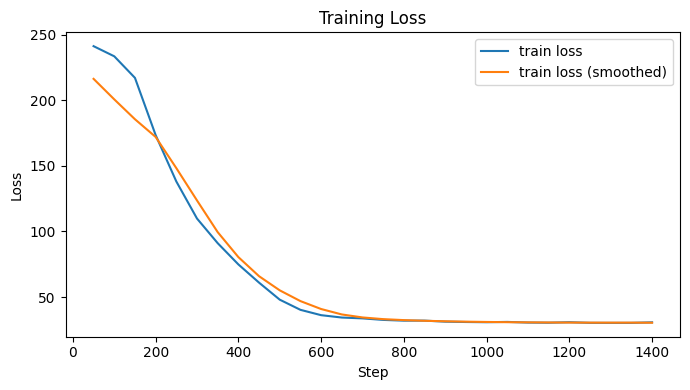

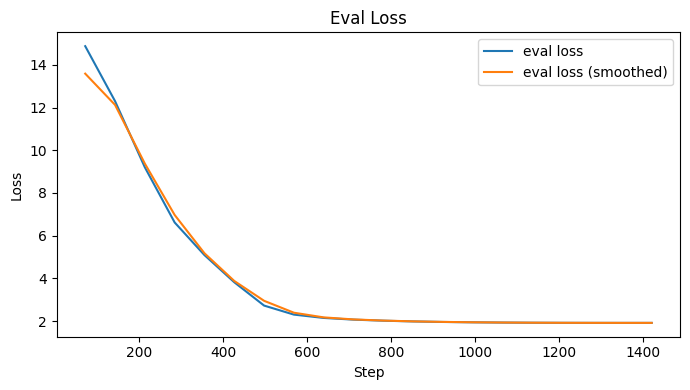

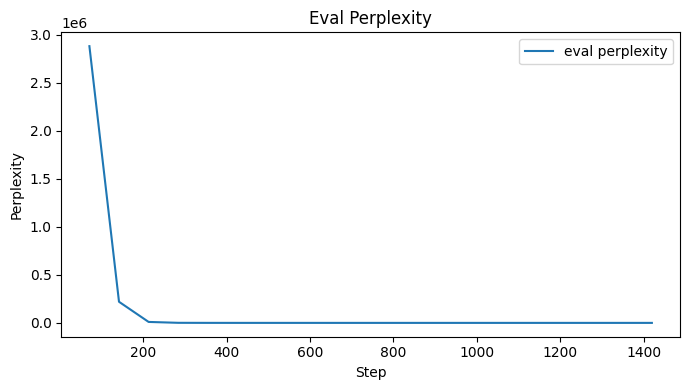

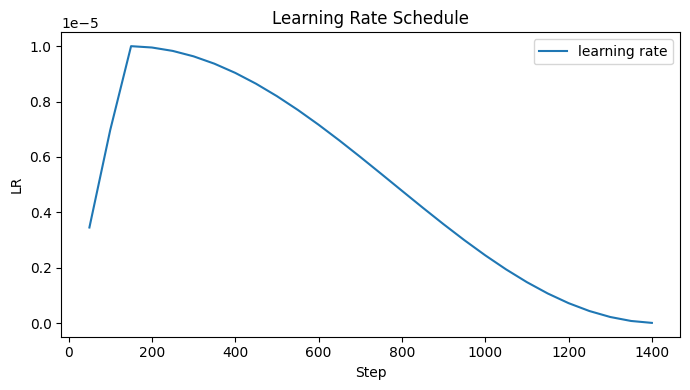

Best eval loss: 1.9175 at step 1420 (perplexity ~ 6.80)
Final train loss: 30.7047 at step 1400


In [ ]:
# ==== Example (fill your student base) ====
TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_smol_360m-v5"

# TODO: Run KD on top-k only and on first epoch run CE only.
# -------- Trainer config --------
sft_cfg = SFTConfig(
    output_dir=out_dir,
    num_train_epochs=20,
    per_device_train_batch_size=4, #4
    gradient_accumulation_steps=16, #16    # eff batch ~64
    learning_rate=1e-5, # 2e-5
    lr_scheduler_type="cosine",
    warmup_ratio=0.1, # 0.08
    weight_decay=0.05,
    label_smoothing_factor=0.05,
    max_grad_norm=0.5, # 1.0
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss", # eval_loss
    greater_is_better=False,
    fp16=False, bf16=False,
    optim="adamw_bnb_8bit",
    packing=False,
    max_length=1024,
    gradient_checkpointing=True,       # ON
    gradient_checkpointing_kwargs={"use_reentrant": False},
    remove_unused_columns=False,
    dataloader_num_workers=4,   # new
    dataloader_pin_memory=True,  # new
    report_to="none",
    seed=42,
)

try:
  trainer = train_kd_demo_qlora_student(
      TEACHER_ID="HuggingFaceTB/SmolLM2-1.7B-Instruct", #"meta-llama/Llama-3.2-3B-Instruct",        # Teacher
      STUDENT_ID="HuggingFaceTB/SmolLM2-360M-Instruct", #"motionlabs/AMD-Llama-350M-Upgraded",      # Llama-style tiny student
      OUT_DIR=out_dir,
      GOLD_DATASET_ID="zBotta/traffic-accidents-reports-5k", # 5k
      USE_KD_DATASET = False,            # Keep it false as we do not need to regenerate targets with teacher
      DEMO_PROB = 1,
      KD_ALPHA= [0.9, 0.75],     # [start, end]  # CE weight (KL gets 1-KD_ALPHA)
      KD_T= 2.7,                 # temperature for KD
      KD_TOP_K= 32,
      SOFT_KD_GAMMA=1.5,
      SOFT_KD_WMIN=0.20,
      BETA_UL=0.1,
      RANK= 8,
      LORA_DROPOUT = 0.05,
      sft_cfg = sft_cfg,
      MAX_LEN = 1024,
      EVAL_N = 5,                   # number of evaluation examples for metrics & latency
      GEN_MAX_NEW = 256,            # generation budget for eval/latency
  )

  plot_training_results(out_dir, trainer)
except Exception as e:
  print(f"Error while training KD trainer: {e}")
  print("Desconnect Colab session")
  # from google.colab import runtime
  # runtime.unassign()

### Diagnosis

In [ ]:
# %% DIAGNOSTICS: LoRA trainables, log tail, supervised-token fraction
import torch
from pprint import pprint

def kd_diagnostics(trainer, n_batches: int = 5):
    print("\n=== 1) LoRA / trainable parameters ===")
    trainable = [(n, p.numel()) for n, p in trainer.model.named_parameters() if p.requires_grad]
    total = sum(c for _, c in trainable)
    print(f"Total trainable params: {total:,}")
    print("First 20 trainables:")
    for name, cnt in trainable[:20]:
        print(f"  - {name}  ({cnt:,})")
    if total == 0:
        print("⚠️ No trainable params detected — LoRA may not be attached or target_modules don't match.")

    print("\n=== 2) Last ~20 log_history rows ===")
    logs = trainer.state.log_history
    tail = logs[-20:] if len(logs) >= 20 else logs
    for row in tail:
        pprint(row)

    print("\n=== 3) Supervised-token fraction over batches ===")
    dl = trainer.get_train_dataloader()
    fracs = []
    counts = 0
    for i, batch in enumerate(dl):
        if i >= n_batches: break
        labels = batch["labels"]
        mask = (labels != -100)
        frac = mask.float().mean().item()
        fracs.append(frac)
        counts += mask.numel()
        print(f"  batch {i:02d}: frac_supervised = {frac:.4f}  (batch_size={labels.size(0)}, seq_len={labels.size(1)})")
    if fracs:
        print(f"Average over {len(fracs)} batches: {sum(fracs)/len(fracs):.4f}")
    else:
        print("No batches read — check your train dataloader.")

# ---- run it (use your Trainer instance variable) ----
kd_diagnostics(trainer, n_batches=5)



=== 1) LoRA / trainable parameters ===
Total trainable params: 4,341,760
First 20 trainables:
  - base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight  (2,560)
  - base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight  (2,560)
  - base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight  (7,680)
  - base_model.model.model.layers.0.mlp.gate_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.mlp.gate_proj.lora_B.default.weight  (20,480)
  - base_model.model.model.layers.0.mlp.up_proj.lora_A.default.weight 

### A/B testing

In [ ]:
!pip -q install rouge_score sacrebleu

# %% A/B capacity check with DEMO_PROB=1.0 (one-shot), deterministic decoding
import re, math, numpy as np, pandas as pd, torch
from datasets import load_dataset
from typing import Dict, Tuple, List
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import evaluate

TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_smol_360m-v3"

# -----------------------
# CONFIG — edit these
# -----------------------
DATASET_ID   = "zBotta/traffic-accidents-reports-5k"   # has splits "train"/"eval" with keys: input, target
N_SAMPLES    = 200                                     # eval sample size
SEED         = 42
# Teacher (baseline) — can be merged or adapter
TEACHER_ID="HuggingFaceTB/SmolLM2-1.7B-Instruct" #"meta-llama/Llama-3.2-3B-Instruct",        # Teacher

# Student — EITHER adapter dir (+ base id) OR merged dir
STUDENT_BASE = "HuggingFaceTB/SmolLM2-360M-Instruct"            # base for adapter case
STUDENT_PATH = out_dir + "/merged-fp16"                # e.g. "student_kd_output/adapter_best" OR "student_kd_output/merged-fp16"
IS_STUDENT_ADAPTER = False                              # True if STUDENT_PATH is an adapter dir; False if merged dir

MAX_LEN      = 1024
MAX_NEW      = 300     # ~350–400 chars
DEMO_PROB    = 1.0     # force 1-shot
DEMO_FROM    = "train" # pull demos from training split

# -----------------------
# Prompt builders
# -----------------------
INSTR = ("You are a reporting agent. Write ONE factual paragraph using ONLY the given facts "
         "(What, When, Where, Who, How, Why, ContingencyActions). Do not invent details.")
RESP_TMPL = "### Response:\n"

def one_line(s: str) -> str:
    return re.sub(r"\s+"," ", str(s).replace("\n"," ")).strip()

def build_prompt_with_demo(demo_in: str, demo_out: str, cur_in: str) -> str:
    return (
        "### Instruction:\n" + INSTR + "\n\n" +
        "### Input-example:\n" + one_line(demo_in) + "\n\n" +
        "### Output-example:\n" + one_line(demo_out) + "\n\n" +
        "### Input:\n" + one_line(cur_in) + "\n\n" +
        RESP_TMPL
    )

def build_prompt_no_demo(cur_in: str) -> str:
    return (
        "### Instruction:\n" + INSTR + "\n\n" +
        "### Input:\n" + one_line(cur_in) + "\n\n" +
        RESP_TMPL
    )

# -----------------------
# Light task metrics
# -----------------------
rouge = evaluate.load("rouge")
chrf  = evaluate.load("chrf")

GLUE_WORDS = set("""
a an and as at by for from in into near of on onto over to toward with without
the this that these those it its there their was were is are be been being
occurred happened caused due because following resulting then after before when while during around approximately about
no not minor major serious am pm km km/h mph minutes hours
""".split())

def parse_fields(inp: str) -> Dict[str, str]:
    # expects "What: ..., When: ..., Where: ..., Who: ..., How: ..., Why: ..., ContingencyActions: ..."
    fields = {}
    for key in ["What","When","Where","Who","How","Why","ContingencyActions"]:
        m = re.search(rf"{key}\s*:\s*(.*?)(?=(?:What|When|Where|Who|How|Why|ContingencyActions)\s*:|$)", inp, flags=re.I)
        fields[key.lower()] = one_line(m.group(1)) if m else ""
    return fields

def slot_coverage(pred: str, fields: Dict[str,str]) -> float:
    # crude: each non-empty field counts as 1 if any 6+ char substring or 2+ digit/time pattern appears in pred
    score, total = 0, 0
    for k, v in fields.items():
        if not v:
            continue
        total += 1
        v_l = v.lower()
        hit = False
        # try long substrings (words >= 6 chars) or numbers
        longs = [w for w in re.findall(r"[A-Za-z0-9:/._-]+", v_l) if (w.isdigit() or len(w) >= 6)]
        for token in longs[:6]:
            if token and token in pred.lower():
                hit = True; break
        # fallback: any overlap of 3+ distinct 3+char words
        if not hit:
            pred_w = set(w for w in re.findall(r"[A-Za-z0-9:/._-]+", pred.lower()) if len(w)>=3)
            v_w    = set(w for w in re.findall(r"[A-Za-z0-9:/._-]+", v_l) if len(w)>=3)
            if len((pred_w - GLUE_WORDS) & (v_w - GLUE_WORDS)) >= 3:
                hit = True
        score += 1 if hit else 0
    return score / max(1,total)

def hallucination_rate(pred: str, inp: str) -> float:
    # percent of content words (len>=4 or numbers) in pred that are NOT in the input
    pw = [w for w in re.findall(r"[A-Za-z0-9:/._-]+", pred.lower()) if (w.isdigit() or len(w)>=4)]
    if not pw: return 0.0
    iw = set(w for w in re.findall(r"[A-Za-z0-9:/._-]+", inp.lower()))
    extra = [w for w in pw if (w not in iw and w not in GLUE_WORDS)]
    return len(extra) / len(pw)

def repeat_3gram_ratio(pred: str) -> float:
    toks = re.findall(r"[A-Za-z0-9:/._-]+", pred.lower())
    if len(toks) < 6: return 0.0
    grams = [' '.join(toks[i:i+3]) for i in range(len(toks)-2)]
    total = len(grams)
    from collections import Counter
    c = Counter(grams)
    repeats = sum(v for v in c.values() if v>1)
    return repeats / total

# --- PAD/EOS repair + embedding resize + ban pad at decode ---
def ensure_distinct_pad(tok: AutoTokenizer, model: AutoModelForCausalLM | None = None):
    """Guarantee pad_token exists and != eos_token; if we add one, resize embeddings safely."""
    if tok.pad_token_id is None or tok.pad_token_id == tok.eos_token_id:
        tok.add_special_tokens({"pad_token": "<|pad|>"})
        if model is not None and hasattr(model, "get_input_embeddings"):
            if model.get_input_embeddings().num_embeddings != len(tok):
                model.resize_token_embeddings(len(tok))
    return tok

def det_generate(model, tok, prompt: str) -> str:
    enc = tok(prompt, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
    enc = {k: v.to(model.device) for k,v in enc.items()}
    # ban PAD token to avoid early stop/garbage
    bad_words_ids = [[tok.pad_token_id]] if tok.pad_token_id is not None else None
    with torch.inference_mode():
        out = model.generate(
            input_ids=enc["input_ids"], attention_mask=enc["attention_mask"],
            do_sample=False, max_new_tokens=MAX_NEW,
            no_repeat_ngram_size=4, repetition_penalty=1.20,
            eos_token_id=tok.eos_token_id, pad_token_id=tok.pad_token_id,
            bad_words_ids=bad_words_ids,
            renormalize_logits=True,
        )
    text = tok.decode(out[0], skip_special_tokens=True)
    return text.split(RESP_TMPL, 1)[-1].strip()

# -----------------------
# Load data + demo pool
# -----------------------
raw = load_dataset(DATASET_ID)
eval_full = raw["eval"]
train_full = raw["train"]
eval_idx = list(range(len(eval_full)))
rng = np.random.RandomState(SEED)
rng.shuffle(eval_idx)
eval_sel = [eval_full[i] for i in eval_idx[:N_SAMPLES]]

demo_pool = [(one_line(r["input"]), one_line(r["target"])) for r in train_full]

def make_prompt(example, i) -> Tuple[str, Dict[str,str]]:
    cur_in, cur_out = one_line(example["input"]), one_line(example["target"])
    if DEMO_PROB >= 1.0 and len(demo_pool) > 1:
        d_in, d_out = demo_pool[(i+1) % len(demo_pool)]
        p = build_prompt_with_demo(d_in, d_out, cur_in)
    else:
        p = build_prompt_no_demo(cur_in)
    return p, parse_fields(cur_in)

# -----------------------
# Load teacher (merged or adapter both OK)
# -----------------------
tok_t = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
model_t = AutoModelForCausalLM.from_pretrained(TEACHER_ID, torch_dtype=torch.float16, device_map="auto").eval()
tok_t = ensure_distinct_pad(tok_t, model_t)

# -----------------------
# Load student
# -----------------------
if IS_STUDENT_ADAPTER:
    tok_s = AutoTokenizer.from_pretrained(STUDENT_PATH, use_fast=True)
    base_s = AutoModelForCausalLM.from_pretrained(STUDENT_BASE, torch_dtype=torch.float16, device_map="auto")
    tok_s = ensure_distinct_pad(tok_s, base_s)   # ensure base embeds resized if we add PAD
    model_s = PeftModel.from_pretrained(base_s, STUDENT_PATH).eval()
else:
    tok_s = AutoTokenizer.from_pretrained(STUDENT_PATH, use_fast=True)
    model_s = AutoModelForCausalLM.from_pretrained(STUDENT_PATH, torch_dtype=torch.float16, device_map="auto").eval()
    tok_s = ensure_distinct_pad(tok_s, model_s)

# -----------------------
# Evaluate
# -----------------------
rows = []
refs_360, preds_360 = [], []
refs_135, preds_135 = [], []

for i, ex in enumerate(eval_sel):
    prompt, slots = make_prompt(ex, i)
    ref = one_line(ex["target"])

    # TEACHER
    pred_t = det_generate(model_t, tok_t, prompt)
    refs_360.append(ref); preds_360.append(pred_t)
    rows.append({
        "model": "teacher_360M",
        "slot_cov": slot_coverage(pred_t, slots),
        "halluc": hallucination_rate(pred_t, ex["input"]),
        "repeat3": repeat_3gram_ratio(pred_t),
        "len": len(pred_t),
    })

    # STUDENT
    pred_s = det_generate(model_s, tok_s, prompt)
    refs_135.append(ref); preds_135.append(pred_s)
    rows.append({
        "model": "student_135M",
        "slot_cov": slot_coverage(pred_s, slots),
        "halluc": hallucination_rate(pred_s, ex["input"]),
        "repeat3": repeat_3gram_ratio(pred_s),
        "len": len(pred_s),
    })

# corpus metrics
def corpus_metrics(refs, preds):
    r = rouge.compute(references=refs, predictions=preds, use_stemmer=True)
    c = chrf.compute(references=refs, predictions=preds)
    return {"rougeL": r["rougeL"], "chrf": c["score"]}

corp_360 = corpus_metrics(refs_360, preds_360)
corp_135 = corpus_metrics(refs_135, preds_135)

df = pd.DataFrame(rows).groupby("model").agg(
    slot_cov=("slot_cov","mean"),
    halluc=("halluc","mean"),
    repeat3=("repeat3","mean"),
    len=("len","mean"),
).reset_index()

for k,v in corp_360.items(): df.loc[df["model"]=="teacher_360M", k] = v
for k,v in corp_135.items():  df.loc[df["model"]=="student_135M", k] = v

print("\n=== A/B — DEMO_PROB=1.0, deterministic decoding (PAD≠EOS, PAD banned) ===")
print(df.to_string(index=False))


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 362, in run
    resolver = self.make_resolver(
               ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 177, in make_resolver
    return pip._internal.resolution.resolvelib.resolver.Resolver(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 58, in __init__
    self.factory = Factory(
                   ^^^^^^^^
  File "/usr/local/lib/py

KeyboardInterrupt: 

### Push Distilled model to HF

In [ ]:
repo_id = "zBotta/SmolLM2-360M-AccidentReports-distilled-kd1.7B-v5"

from huggingface_hub import HfApi, create_repo, upload_folder, login
merged_dir = f"{out_dir}/merged-fp16" # we should push the adapter model
from google.colab import userdata
hf_token = userdata.get('hf_token')

login(token=hf_token)

api = HfApi(token=hf_token)
try:
  api.create_repo(repo_id, private=True, repo_type="model")
except Exception as e:
  print(f"Repo model {repo_id} already created")
upload_folder(folder_path=merged_dir, repo_id=repo_id, repo_type="model")
print("Pushed:", repo_id)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...0m-v5/merged-fp16/model.safetensors:   5%|4         | 33.5MB /  724MB            

Pushed: zBotta/SmolLM2-360M-AccidentReports-distilled-kd1.7B-v5


### Manual test on one sample

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

model_id = "zBotta/SmolLM2-360M-AccidentReports-distilled-kd1.7B-v3"


INSTR = (
"""
You are a reporting agent.
You task is to create a report when provided the what, when, why, who, how and where questions about the events.
You are also given information about the contingency actions regarding the event.

Guidelines:
- Generate only one report given the informations about the event
- Generate the report as text in one paragraph
- It is important to focus on accuracy and coherence when generating the report so that the description content matches the information provided (what, when, where, who, how , why, contingency actions).
  If an information is not provided in (what, when, where, who, how , why, contingency actions), it must not be part of the generated text description.
"""
)

# INSTR = ("""
# You are a reporting agent. Write ONE factual paragraph using ONLY the given facts (What, When, Where, Who, How, Why, ContingencyActions). Do not invent details.
# """)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch_dtype = torch.float32 if torch.cuda.is_available() else torch.float32
tokenizer = AutoTokenizer.from_pretrained(model_id, device_map="auto", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", trust_remote_code=True)


ds = load_dataset("zBotta/traffic-accidents-reports-5k")
ds_test = ds['test']

current_in = ds_test[37]['input']
demo_in = ds_test[22]["input"]
demo_out = ds_test[22]["target"]
RESP_TMPL = "### Response:\n"

prompt = (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input-example:\n" + demo_in + "\n\n" +
            "### Output-example:\n" + demo_out + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

enc = tokenizer(prompt, return_tensors="pt", padding=False, truncation=True, max_length=1024)
enc = {k: v.to(model.device) for k, v in enc.items()}
# print(enc)
out =  model.generate(input_ids=enc["input_ids"],
    attention_mask=enc["attention_mask"],     # <-- fixes pad/eos ambiguity
    do_sample=False,                          # deterministic
    max_new_tokens=180,
    no_repeat_ngram_size=2,
    repetition_penalty=1.20,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    renormalize_logits=True,
)
resp = tokenizer.decode(out[0], skip_special_tokens=True)
resp.split(RESP_TMPL)[1]

tokenizer_config.json:   0%|          | 0.00/3.40k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/368 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

'Car struck pedestrians at street corner at intersection with crosswalks. Pedestrian suffered injury from impact while walking across cross walk area. Ambulance call dispatched emergency service personnel including paramedics and officers were immediately available upon arrival. Police officer recorded incident details.'

# Distillation v5 - SmolLM2-1.7B -> smolLM2-360M (BUG CORRECTION)

You fixed the decode offset, but the training loss is still mis-aligned in the KD cell. In your custom compute_loss, CE/KD are computed at the same positions as the labels, but for causal LM the logits at position t predict the token at t+1.

In other words, you must shift logits left (or labels right) before computing CE and KD. The CE-only cell works because TRL/HF do this shift internally; your KD override skips it, so the model learns the wrong alignment → degenerate greedy outputs like TheThe… or . . ..

At position t, the model predicts the next token yₜ given the prefix up to position t−1.
So the loss at time t must compare:

- logits from position t−1 (what the model produced before seeing yₜ),

- label yₜ (the token that actually comes next).

This is why we shift logits left (or labels right) by 1.



#### Explain the BUG with Tiny Example

Tokens after the prompt are A B C <eos>:
```
time index:    0   1   2    3    4
labels:      [ -100, A,  B,  C, <eos> ]
logits:         ^    ^   ^    ^    ^    (predict next token at each step)
                |    |   |    |
should predict: A    B   C   <eos>

```
- Keep logits at 0..3 (drop 4): logits[:, :-1, :]

- Keep labels at 1..4 (drop 0): labels[:, 1:]

Now each logit row predicts the label right next to it.

## Load v5 function and plots

In [ ]:
# ==== ONE-CELL: KD + QLoRA (student), optional KD gen from gold, eval & latency ====
!pip -q install -U "transformers>=4.43" "accelerate>=0.33" "datasets>=2.20" peft bitsandbytes trl evaluate sacrebleu rouge_score

import os, re, json, math, time, random, gc
import numpy as np, torch
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import evaluate
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,
    EarlyStoppingCallback, GenerationConfig, TrainerCallback
)
from peft import LoraConfig, PeftModel
from trl import SFTConfig, SFTTrainer
from huggingface_hub import login

# (Colab) login if you store your token in user data
try:
    from google.colab import userdata
    hf_token = userdata.get('hf_token')
    if hf_token: login(token=hf_token)
except Exception:
    pass

# speed & stability on T4 with bnbkl_topk
torch.backends.cuda.matmul.allow_tf32 = True
os.environ["ACCELERATE_MIXED_PRECISION"] = "no"

def train_kd_demo_qlora_student(
    STUDENT_ID: str = "HuggingFaceTB/SmolLM2-360M-Instruct",      # tiny student
    TEACHER_ID: str = "HuggingFaceTB/SmolLM2-1.7B-Instruct",      # teacher (same tokenizer family!)
    OUT_DIR: str = "student_kd_output",
    GOLD_DATASET_ID: str = "zBotta/traffic-accidents-reports-5k",
    KD_DATASET_REPO: Optional[str] = None,     # optional ready-made KD set; else we use GOLD
    USE_KD_DATASET: bool = False,
    DEMO_PROB: float = 0.8,
    KD_ALPHA: list = [0.85, 0.65],            # CE weight (KL gets 1-KD_ALPHA)
    KD_T: float = 2.0,                        # KD temperature
    KD_TOP_K: int = 128,
    SOFT_KD_WMIN: float = 0.05,
    SOFT_KD_GAMMA: float = 2.0,
    BETA_UL: float = 0.1,
    RANK: int = 8,
    LORA_DROPOUT: float = 0.05,
    sft_cfg: Optional[SFTConfig] = None,
    MAX_LEN: int = 1024,
    EVAL_N: int = 5,                          # eval examples for metrics & latency
    GEN_MAX_NEW: int = 256,                   # generation budget for eval/latency
):
    """
    KD (logit) + CE distillation with QLoRA student.
    """
    os.makedirs(OUT_DIR, exist_ok=True)

    RESP_TMPL = "### Response:\n"
    # INSTR = ("You are a reporting agent. Write ONE factual paragraph using ONLY the given facts "
    #          "(What, When, Where, Who, How, Why, ContingencyActions). Do not invent details.")
    INSTR = (
    """
    You are a reporting agent.
    You task is to create a report when provided the what, when, why, who, how and where questions about the events.
    You are also given information about the contingency actions regarding the event.

    Guidelines:
    - Generate only one report given the informations about the event
    - Generate the report as text in one paragraph
    - It is important to focus on accuracy and coherence when generating the report so that the description content matches the information provided (what, when, where, who, how , why, contingency actions).
      If an information is not provided in (what, when, where, who, how , why, contingency actions), it must not be part of the generated text description.
    """
    )

    def one_line(s: str) -> str:
        return re.sub(r"\s+", " ", str(s).replace("\n", " ")).strip()

    def prompt_with_demo(demo_in: str, demo_out: str, current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input-example:\n" + demo_in + "\n\n" +
            "### Output-example:\n" + one_line(demo_out) + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

    def prompt_no_demo(current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

    # -------- Load GOLD dataset --------
    raw_gold = load_dataset(GOLD_DATASET_ID)  # expects splits "train"/"eval" with 'input' and 'target'
    assert "train" in raw_gold and "eval" in raw_gold, "Gold dataset must have 'train' and 'eval'."
    def ok(r): return bool(str(r.get("input","")).strip()) and bool(str(r.get("target","")).strip())
    ds_gold = DatasetDict(train=raw_gold["train"].filter(ok), eval=raw_gold["eval"].filter(ok))
    demo_pool: List[Tuple[str,str]] = [(one_line(r["input"]), one_line(r["target"])) for r in ds_gold["train"]]

    # -------- Tokenizers --------
    tok_student = AutoTokenizer.from_pretrained(STUDENT_ID, use_fast=True)
    tok_teacher = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
    if tok_student.pad_token_id is None: tok_student.pad_token = tok_student.eos_token
    if tok_teacher.pad_token_id is None: tok_teacher.pad_token = tok_teacher.eos_token

    # Required for logit KD
    if tok_student.get_vocab() != tok_teacher.get_vocab():
        raise RuntimeError(
            "Tokenizer mismatch: student and teacher must share IDENTICAL vocab for logit KD.\n"
            f"Student vocab size={len(tok_student)}, Teacher vocab size={len(tok_teacher)}.\n"
            "Pick a student with the exact same tokenizer as the teacher, or disable logit KD."
        )

    # -------- 4-bit config --------
    bnb4 = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.float16
    )

    # -------- KD dataset load / fallback --------
    def try_load_kd_repo(repo_id: Optional[str]) -> Optional[DatasetDict]:
        if not repo_id: return None
        try:
            ds = load_dataset(repo_id)
            if "train" in ds and "eval" in ds and all(k in ds["train"].column_names for k in ("input","target")):
                print(f"✅ KD dataset loaded from: {repo_id}")
                return DatasetDict(train=ds["train"], eval=ds["eval"])
            else:
                print(f"⚠️ KD repo {repo_id} missing expected splits/columns; will generate from GOLD.")
                return None
        except Exception as e:
            print(f"⚠️ Could not load KD repo {repo_id}: {e}\nWill generate teacher outputs from GOLD.")
            return None

    if USE_KD_DATASET:
        ds_base = try_load_kd_repo(KD_DATASET_REPO)
        need_kd_from_gold = ds_base is None
    else:
        ds_base = ds_gold
        need_kd_from_gold = False

    # -------- Teacher model (for logits & optional text gen) --------
    teacher_for_logits = AutoModelForCausalLM.from_pretrained(
        TEACHER_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto"
    ).eval()
    for p in teacher_for_logits.parameters(): p.requires_grad_(False)

    # ----- FIXED per-row decode slicing for teacher gens -----
    def gen_teacher_texts(ds: Dataset, batch_size: int = 4, max_new: int = 256) -> List[str]:
        """Generate teacher texts for ds['input'] with the same prompting scheme (no demo)."""
        outs = []
        device = next(teacher_for_logits.parameters()).device
        for i in range(0, len(ds), batch_size):
            batch = ds[i:i+batch_size]
            prompts = [prompt_no_demo(one_line(x)) for x in batch["input"]]
            enc = tok_teacher(prompts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
            enc = {k: v.to(device) for k, v in enc.items()}
            with torch.inference_mode():
                gen = teacher_for_logits.generate(
                    **enc, do_sample=False, temperature=1.0, max_new_tokens=max_new,
                    eos_token_id=tok_teacher.eos_token_id, pad_token_id=tok_teacher.pad_token_id
                )
            input_lens = enc["attention_mask"].sum(dim=1).tolist()
            for j in range(len(prompts)):
                new_ids = gen[j, input_lens[j]:]
                text = tok_teacher.decode(new_ids, skip_special_tokens=True)
                outs.append(one_line(text))
        return outs

    if need_kd_from_gold:
        print("🛠 Generating teacher outputs from GOLD for KD...")
        kd_train_out = gen_teacher_texts(ds_gold["train"])
        kd_eval_out  = gen_teacher_texts(ds_gold["eval"])
        ds_base = DatasetDict(
            train = ds_gold["train"].add_column("target", kd_train_out),
            eval  = ds_gold["eval"].add_column("target",  kd_eval_out),
        )

    # -------- Tokenize (response-only labels) --------
    def add_demo_and_tokenize(example, idx):
        cur_in, cur_out = one_line(example["input"]), one_line(example["target"])
        use_demo = (np.random.rand() < DEMO_PROB) and (len(demo_pool) > 1)
        if use_demo:
            d_in, d_out = demo_pool[(idx+1) % len(demo_pool)]
            prompt = prompt_with_demo(d_in, d_out, cur_in)
        else:
            prompt = prompt_no_demo(cur_in)

        prom = tok_student(prompt, add_special_tokens=True, truncation=True, max_length=MAX_LEN)
        prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        # fallback to no-demo if too tight
        if len(prompt_ids) >= MAX_LEN - 4:
            prom = tok_student(prompt_no_demo(cur_in), add_special_tokens=True, truncation=True, max_length=MAX_LEN)
            prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        eos = tok_student.eos_token_id
        if eos is None:
            tok_student.pad_token = tok_student.eos_token
            eos = tok_student.eos_token_id

        budget = MAX_LEN - len(prompt_ids)
        if budget <= 0:
            prompt_ids = prompt_ids[:-1]; attn_prompt = attn_prompt[:-1]
            budget = 1

        allow = max(0, budget - 1)
        targ_ids = tok_student(cur_out, add_special_tokens=False, truncation=True, max_length=max(1, allow)).input_ids
        targ_ids = targ_ids[:allow]

        target_with_eos = targ_ids + [eos]
        input_ids      = prompt_ids + target_with_eos
        attention_mask = attn_prompt + [1] * len(target_with_eos)
        labels         = [-100] * len(prompt_ids) + target_with_eos
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

    ds_tok = DatasetDict(
        train = ds_base["train"].map(add_demo_and_tokenize, with_indices=True, remove_columns=ds_base["train"].column_names, desc="Tokenizing train"),
        eval  = ds_base["eval"].map(add_demo_and_tokenize,  with_indices=True, remove_columns=ds_base["eval"].column_names,  desc="Tokenizing eval"),
    )

    # -------- Student model (4-bit) + LoRA --------
    student = AutoModelForCausalLM.from_pretrained(
        STUDENT_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto"
    )
    student.config.use_cache = False

    lora_cfg = LoraConfig(
        r=RANK, lora_alpha=2*RANK, lora_dropout=LORA_DROPOUT,
        target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
        task_type="CAUSAL_LM"
    )

    # -------- Collator --------
    @dataclass
    class Coll:
        pad_id: int
        def __call__(self, feats):
            L = max(len(f["input_ids"]) for f in feats)
            def pad(x, v): return x + [v]*(L-len(x))
            batch = {
                "input_ids": torch.tensor([pad(f["input_ids"], self.pad_id) for f in feats]),
                "attention_mask": torch.tensor([pad(f["attention_mask"], 0) for f in feats]),
                "labels": torch.tensor([pad(f["labels"], -100) for f in feats]),
            }
            if not (batch["labels"] != -100).any():
                raise RuntimeError("Batch has no supervised tokens.")
            return batch
    collator = Coll(tok_student.pad_token_id)

    # -------- KD-enabled Trainer (with alignment fix) --------
    class DistillSFTTrainer(SFTTrainer):
      def __init__(self, *args,
                 teacher_model=None,
                 kd_alpha_ce_start=0.85,
                 kd_alpha_ce_end=0.65,
                 kd_warmup_epochs=2,
                 kd_ramp_epochs=2,
                 kd_temp=3.0,
                 kd_top_K=128,
                 beta_ul=0.1,
                 ce_smoothing=0.05,
                 soft_kd_gamma=2.0,
                 soft_kd_wmin=0.05,
                 **kwargs):
        super().__init__(*args, **kwargs)
        assert teacher_model is not None
        self.teacher = teacher_model.eval()
        for p in self.teacher.parameters(): p.requires_grad_(False)
        self.kd_alpha_ce_start = float(kd_alpha_ce_start)
        self.kd_alpha_ce_end   = float(kd_alpha_ce_end)
        self.kd_warmup_epochs  = int(kd_warmup_epochs)
        self.kd_ramp_epochs    = int(kd_ramp_epochs)
        self.kd_temp           = float(kd_temp)
        self.kd_top_K          = int(kd_top_K)
        self.beta_ul           = float(beta_ul)
        self.ce_smoothing      = float(ce_smoothing)
        self.soft_kd_gamma     = float(soft_kd_gamma)
        self.soft_kd_wmin      = float(soft_kd_wmin)

      def _ce_weight(self):
        e = float(self.state.epoch or 0.0)
        if e < self.kd_warmup_epochs: return 1.0
        if e < self.kd_warmup_epochs + self.kd_ramp_epochs:
            t = (e - self.kd_warmup_epochs) / max(1.0, self.kd_ramp_epochs)
            return self.kd_alpha_ce_start + (self.kd_alpha_ce_end - self.kd_alpha_ce_start) * t
        return self.kd_alpha_ce_end

      def _smoothed_ce(self, logp, labels, mask, eps=0.05):
          # logp: [B,L,V] aligned with labels [B,L]
          gather = torch.gather(logp, -1, labels.clamp_min(0).unsqueeze(-1)).squeeze(-1)  # [B,L]
          nll = -(gather[mask]).mean()
          H   = -(logp[mask]).mean()
          return (1 - eps) * nll + eps * H

      def compute_loss(self, model, inputs, return_outputs=False, **kw):
          labels = inputs.pop("labels")                   # [B, L]
          out_s = model(**inputs, use_cache=False)
          logits_s = out_s.logits                         # [B, L, V]

          # ===== ALIGN BY ONE STEP =====
          logits_s_shift = logits_s[:, :-1, :]            # predict next token
          labels_shift   = labels[:, 1:]
          mask_shift     = (labels_shift != -100)

          # CE (smoothed) on shifted tensors
          logp_s_shift = torch.log_softmax(logits_s_shift, dim=-1)
          ce = self._smoothed_ce(logp_s_shift, labels_shift, mask_shift, eps=self.ce_smoothing)

          ce_w = self._ce_weight()
          if ce_w >= 0.999:
              return (ce, out_s) if return_outputs else ce

          # Teacher forward + shift
          with torch.inference_mode():
              out_t = self.teacher(**inputs, use_cache=False)
              logits_t_shift = out_t.logits[:, :-1, :]

          # KD (top-K partial KL) on shifted tensors
          T = self.kd_temp
          V = logits_s_shift.shape[-1]
          K = min(self.kd_top_K, V)
          topk_val, topk_idx = torch.topk(logits_t_shift / T, k=K, dim=-1)  # [B,L-1,K]
          p_t_topk = torch.softmax(topk_val, dim=-1)                         # [B,L-1,K]
          conf = p_t_topk[..., 0]                                            # [B,L-1]
          w = torch.clamp(conf ** self.soft_kd_gamma, min=self.soft_kd_wmin) * mask_shift.float()
          has_kd = (w.sum() > 0)

          if has_kd:
              logp_s_T_shift = torch.log_softmax(logits_s_shift / T, dim=-1)
              gather_logp_s  = torch.gather(logp_s_T_shift, -1, topk_idx)  # [B,L-1,K]
              kl_pos = torch.sum(p_t_topk * (torch.log(p_t_topk + 1e-9) - gather_logp_s), dim=-1)  # [B,L-1]
              kd = (w * kl_pos).sum() / (w.sum() + 1e-6)
          else:
              kd = torch.zeros((), device=logits_s.device)

          # tiny anti-repeat on next-token probs (aligned)
          beta_ul = self.beta_ul
          if beta_ul > 0:
              prev_tok = inputs["input_ids"][:, :-1]     # token at t
              p_next   = torch.softmax(logits_s_shift, dim=-1)
              p_repeat = torch.gather(p_next, -1, prev_tok.unsqueeze(-1)).squeeze(-1)  # P(x_{t+1}=x_t)
              ul = -torch.log(1.0 - p_repeat + 1e-6)
              ul = (ul[mask_shift]).mean() if mask_shift.any() else torch.zeros((), device=logits_s.device)
          else:
              ul = torch.zeros((), device=logits_s.device)

          kd_w = 1.0 - ce_w
          loss = ce_w * ce + kd_w * kd + beta_ul * ul

          if self.state.global_step % 50 == 0:
              self.log({
                  "train/ce": float(ce.detach()),
                  "train/kd": float(kd.detach()),
                  "train/ul": float(ul.detach()),
                  "train/ce_weight": float(ce_w),
                  "train/kd_weight": float(kd_w),
              })
          return (loss, out_s) if return_outputs else loss

    # ===== Callback to print a sample generation at each epoch end =====
    class SampleGenerateCallback(TrainerCallback):
      def __init__(self, tok, make_prompt_fn, eval_ds, max_new=180, resp_marker="### Response:\n"):
          self.tok = tok
          self.make_prompt_fn = make_prompt_fn
          self.eval_ds = eval_ds
          self.max_new = max_new
          self.resp_marker = resp_marker
          self.rng = np.random.default_rng(123)

      def _extract_report(self, decoded_full: str, decoded_new: str) -> str:
          """
          Prefer slicing from RESP_TMPL inside the full decoded text.
          Fall back to the already-sliced new text if the marker isn't found.
          Also stop at the next '###' section header if present.
          """
          marker = self.resp_marker.strip()  # "### Response:"
          idx = decoded_full.find(marker)
          if idx != -1:
              start = idx + len(marker)
              out = decoded_full[start:]
          else:
              out = decoded_new

          # If the model echoed a new section header, cut before it
          out = out.split("###", 1)[0]

          # Clean common boilerplate/echoes
          out = re.sub(r'^\s*(#+\s*Response:)?\s*', '', out)                     # drop echoed "### Response:"
          out = re.sub(r'^\s*(Factual\s+(paragraph|report)\s*:)\s*', '', out, flags=re.I)

          return one_line(out)

      def _gen(self, model, prompt: str) -> str:
          device = next(model.parameters()).device
          enc = self.tok([prompt], return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
          enc = {k: v.to(device) for k, v in enc.items()}
          with torch.inference_mode():
              out = model.generate(
                  **enc,
                  do_sample=False,                 # deterministic
                  max_new_tokens=self.max_new,
                  no_repeat_ngram_size=4,          # mild guard
                  repetition_penalty=1.05,
                  renormalize_logits=True,
                  eos_token_id=self.tok.eos_token_id,
                  pad_token_id=self.tok.pad_token_id
              )

          # Decode both (full and new-only) so we can robustly slice from the marker
          input_len = int(enc["attention_mask"].sum().item())
          decoded_full = self.tok.decode(out[0], skip_special_tokens=True)
          decoded_new  = self.tok.decode(out[0, input_len:], skip_special_tokens=True)
          return self._extract_report(decoded_full, decoded_new)

      def on_epoch_end(self, args, state, control, **kwargs):
          model = kwargs["model"]
          was_training = model.training
          model.eval()
          try:
              idx = int(self.rng.integers(0, len(self.eval_ds)))
              cur_in = one_line(self.eval_ds[idx]["input"])
              prompt = self.make_prompt_fn(cur_in)
              text = self._gen(model, prompt)

              # Print only the report (trimmed)
              print(f"\n[epoch {int(state.epoch)}] sample report (post-RESP_TMPL)")
              print("Report:", (text[:300] + ("..." if len(text) > 300 else "")))
          finally:
              if was_training: model.train()
          gc.collect()
          if torch.cuda.is_available():
              torch.cuda.empty_cache()


    def make_eval_prompt(x): return prompt_no_demo(one_line(x))
    sample_cb = SampleGenerateCallback(
        tok_student,
        make_eval_prompt,
        ds_gold["eval"],
        max_new=300,
        resp_marker=RESP_TMPL)

    trainer = DistillSFTTrainer(
        model=student,
        args=sft_cfg,
        peft_config=lora_cfg,
        train_dataset=ds_tok["train"],
        eval_dataset=ds_tok["eval"],
        data_collator=collator,
        teacher_model=teacher_for_logits,
        kd_alpha_ce_start=KD_ALPHA[0],
        kd_alpha_ce_end=KD_ALPHA[1],
        kd_warmup_epochs=2,
        kd_ramp_epochs=2,
        kd_temp=KD_T,
        kd_top_K=KD_TOP_K,
        beta_ul=BETA_UL,
        ce_smoothing=0.05,
        soft_kd_gamma=SOFT_KD_GAMMA,
        soft_kd_wmin=SOFT_KD_WMIN,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=1e-3),
            sample_cb,  # <-- prints a quick report each epoch
        ],
    )

    print("Accelerate mixed precision:", trainer.accelerator.mixed_precision)
    trainables = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)
    print("Trainable params:", trainables)

    # ---- Train ----
    trainer.train()

    # ---- Save LoRA adapter (best) ----
    adapter_dir = f"{OUT_DIR}/adapter"
    os.makedirs(adapter_dir, exist_ok=True)
    trainer.model.save_pretrained(adapter_dir)
    tok_student.save_pretrained(adapter_dir)
    print("✅ Saved LoRA adapter to:", adapter_dir)

    # ---- Build merged FP16 checkpoint (ready to push) ----
    best_dir = trainer.state.best_model_checkpoint or adapter_dir
    merged_dir = f"{OUT_DIR}/merged-fp16"
    os.makedirs(merged_dir, exist_ok=True)

    base_fp16 = AutoModelForCausalLM.from_pretrained(STUDENT_ID, torch_dtype=torch.float16, device_map="cpu")
    peft_best = PeftModel.from_pretrained(base_fp16, best_dir)
    merged = peft_best.merge_and_unload().eval()

    if tok_student.pad_token_id is None:
        tok_student.pad_token = tok_student.eos_token
    merged.save_pretrained(merged_dir, safe_serialization=True)
    tok_student.save_pretrained(merged_dir)

    with open(os.path.join(merged_dir, "generation_config.json"), "w") as f:
        json.dump({
            "max_new_tokens": 300,
            "do_sample": True,
            "eos_token_id": tok_student.eos_token_id,
            "pad_token_id": tok_student.pad_token_id
        }, f)

    print("✅ Merged FP16 model saved to:", merged_dir)

    # =========================
    # Evaluation & Latency (5)
    # =========================
    rouge = evaluate.load("rouge")
    bleu  = evaluate.load("sacrebleu")

    rng = np.random.default_rng(42)
    idxs = rng.choice(len(ds_gold["eval"]), size=min(EVAL_N, len(ds_gold["eval"])), replace=False)
    eval_subset = ds_gold["eval"].select(list(idxs))
    prompts = [make_eval_prompt(x["input"]) for x in eval_subset]
    refs    = [[one_line(x["target"])] for x in eval_subset]  # sacrebleu expects list of list

    def gen_text(model, tok, prompts, max_new=GEN_MAX_NEW, do_sample=False, temperature=1.0):
        device = next(model.parameters()).device
        enc = tok(prompts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.inference_mode():
            gen = model.generate(
                **enc,
                do_sample=do_sample, temperature=temperature,
                max_new_tokens=max_new,
                eos_token_id=tok.eos_token_id, pad_token_id=tok.pad_token_id
            )
        input_lens = enc["attention_mask"].sum(dim=1).tolist()
        texts = []
        for i in range(len(prompts)):
            out_ids = gen[i, input_lens[i]:]
            texts.append(one_line(tok.decode(out_ids, skip_special_tokens=True)))
        return texts, gen, enc

    student_eval = AutoModelForCausalLM.from_pretrained(merged_dir, torch_dtype=torch.float16, device_map="auto").eval()
    teacher_eval = teacher_for_logits  # same instance

    print("\n=== Accuracy on 5 samples (Teacher) ===")
    pred_teacher, _, _ = gen_text(teacher_eval, tok_teacher, prompts, do_sample=False, temperature=1.0)
    rouge_teacher = rouge.compute(predictions=pred_teacher, references=[r[0] for r in refs], use_stemmer=True)
    bleu_teacher  = bleu.compute(predictions=pred_teacher, references=refs)
    print("ROUGE-Lsum:", round(rouge_teacher["rougeLsum"], 4), " | SacreBLEU:", round(bleu_teacher["score"], 2))

    print("\n=== Accuracy on 5 samples (Student) ===")
    pred_student, _, _ = gen_text(student_eval, tok_student, prompts, do_sample=False, temperature=1.0)
    rouge_student = rouge.compute(predictions=pred_student, references=[r[0] for r in refs], use_stemmer=True)
    bleu_student  = bleu.compute(predictions=pred_student, references=refs)
    print("ROUGE-Lsum:", round(rouge_student["rougeLsum"], 4), " | SacreBLEU:", round(bleu_student["score"], 2))

    for i,(p,ref,ts,ss) in enumerate(zip(prompts, [r[0] for r in refs], pred_teacher, pred_student)):
        print(f"\n--- Sample {i+1} ---")
        print("Ref :", ref[:200] + ("..." if len(ref)>200 else ""))
        print("Teach:", ts[:200] + ("..." if len(ts)>200 else ""))
        print("Stud :", ss[:200] + ("..." if len(ss)>200 else ""))

    def latency_test(model, tok, prompts, max_new=GEN_MAX_NEW, warmup=True, label="model"):
        device = next(model.parameters()).device
        if warmup:
            _ = gen_text(model, tok, prompts[:1], max_new=32, do_sample=False, temperature=1.0)
            if device.type == "cuda":
                torch.cuda.synchronize()
        times, toks = [], []
        for prompt in prompts:
            enc = tok([prompt], return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
            enc = {k: v.to(device) for k, v in enc.items()}
            if device.type == "cuda": torch.cuda.synchronize()
            t0 = time.perf_counter()
            with torch.inference_mode():
                gen = model.generate(
                    **enc, do_sample=False, temperature=1.0, max_new_tokens=max_new,
                    eos_token_id=tok.eos_token_id, pad_token_id=tok.pad_token_id
                )
            if device.type == "cuda": torch.cuda.synchronize()
            input_len = int(enc["attention_mask"].sum().item())
            out_len = int(gen.shape[1] - input_len)
            times.append(time.perf_counter() - t0)
            toks.append(out_len)
        avg_lat = sum(times)/len(times)
        avg_toks = sum(toks)/len(toks)
        tps = (sum(toks)/sum(times)) if sum(times)>0 else 0.0
        print(f"\n=== Latency ({label}) ===")
        for i,(dt,tk) in enumerate(zip(times,toks)):
            print(f"ex{i+1}: {dt:.3f}s, gen_tokens={tk}, tok/s={tk/dt if dt>0 else 0.0:.1f}")
        print(f"AVG: {avg_lat:.3f}s per sample | {tps:.1f} tok/s | avg_gen_tokens={avg_toks:.1f}")

    latency_test(teacher_eval, tok_teacher, prompts, max_new=GEN_MAX_NEW, label="Teacher")
    latency_test(student_eval, tok_student, prompts, max_new=GEN_MAX_NEW, label="Student")

    print("\nDone.")
    return trainer




import matplotlib.pyplot as plt
import pandas as pd

# =========================
# Post-training: PNG GRAPHS + CSV
# =========================

def plot_training_results(out_dir, _trainer):
  """ loads trainer log history and plots results and exports images """
  logs = pd.DataFrame(_trainer.state.log_history)
  if logs.empty:
      print("No logs recorded. Did logging_steps/eval_steps run?")
  else:
      os.makedirs(out_dir, exist_ok=True)
      log_csv = os.path.join(out_dir, "training_logs.csv")
      logs.to_csv(log_csv, index=False)
      print("Saved raw logs to:", log_csv)

      def safe_exp(x):
          try: return float(np.exp(x))
          except Exception: return np.nan

      train_df = logs[logs["loss"].notna()][["step","loss"]].copy()
      eval_df  = logs[logs["eval_loss"].notna()][["step","eval_loss"]].copy()
      lr_df    = logs[logs["learning_rate"].notna()][["step","learning_rate"]].copy()

      if not eval_df.empty: eval_df["eval_perplexity"] = eval_df["eval_loss"].map(safe_exp)
      if not train_df.empty: train_df["perplexity"] = train_df["loss"].map(safe_exp)

      def smooth(y, k=5):
          s = pd.Series(y); return s.rolling(k, min_periods=1, center=True).mean().values

      if not train_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(train_df["step"], train_df["loss"], label="train loss")
          plt.plot(train_df["step"], smooth(train_df["loss"], 7), label="train loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Training Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "train_loss.png")); plt.show()

      if not eval_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_loss"], label="eval loss")
          plt.plot(eval_df["step"], smooth(eval_df["eval_loss"], 3), label="eval loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Eval Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_loss.png")); plt.show()

          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_perplexity"], label="eval perplexity")
          plt.xlabel("Step"); plt.ylabel("Perplexity"); plt.title("Eval Perplexity")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_perplexity.png")); plt.show()

      if not lr_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(lr_df["step"], lr_df["learning_rate"], label="learning rate")
          plt.xlabel("Step"); plt.ylabel("LR"); plt.title("Learning Rate Schedule")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "learning_rate.png")); plt.show()

      if not eval_df.empty:
          best_row = eval_df.loc[eval_df["eval_loss"].idxmin()]
          print(f"Best eval loss: {best_row['eval_loss']:.4f} at step {int(best_row['step'])} "
                f"(perplexity ~ {best_row['eval_perplexity']:.2f})")
      if not train_df.empty:
          print(f"Final train loss: {train_df['loss'].iloc[-1]:.4f} at step {int(train_df['step'].iloc[-1])}")


### Run Distillation v5.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import userdata
github_token = userdata.get('zbotta_token')

token = github_token
username = "zbotta"
repo = 'reportingAgent'
!git config --global user.name "zbotta"
!git config --global user.email "zbotta@proton.me"
%cd /content/drive/MyDrive/GitHub/{repo}

Mounted at /content/drive
/content/drive/MyDrive/GitHub/reportingAgent


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Filter:   0%|          | 0/4499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Tokenizing train:   0%|          | 0/4499 [00:00<?, ? examples/s]

Tokenizing eval:   0%|          | 0/500 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/4499 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Accelerate mixed precision: no
Trainable params: 4341760



[epoch 1] sample report (post-RESP_TMPL)
Report: The report should include the following information: - The date, time, and location of the collision. - The names of the drivers involved. - Any relevant details about the vehicle involved. The document should also contain the following information about the event: * The type of accident (collision)...

[epoch 2] sample report (post-RESP_TMPL)
Report: ``` Report: February 14th, 23:59:00 AM Vehicle A was parked at the Supermarket parking area, near the Pine Plaza store. Vehicles B and A were driving towards each other. Vehicle B was turning right while Vehicle A was turning left. The collision occurred at the intersection of Main Street and Pine A...

[epoch 3] sample report (post-RESP_TMPL)
Report: On November 14, 25, at 1530, a collision occurred between a sedan driven by Ms. Julia Miller and a bicycle riding on the crosswalk at Lincoln Elementary School. Ms. Miller was struck by a bicycle rider who was injured. The incident occurred a


[epoch 15] sample report (post-RESP_TMPL)
Report: On April 29, 22:30, at 1335 hours, a sideswipe occurred on the eastbound lane of the Valley Tunnel, causing minor damage to the adjacent sedan driven by Mr. Owen. The driver of Vehicle A, a delivery van driven by Mr Julian Fox, changed lanes without signaling, colliding with the sedan driven in the ...

[epoch 16] sample report (post-RESP_TMPL)
Report: On March 15, 2015 at 0830, a frontal collision occurred at the intersection of Main St and Fifth Ave involving a sedan (Vehicle A) driven by Mr. John L. Lee and a truck (Vehicle B) driven by Ms. Maria M. Gomez. The incident was discovered at 0735. Both drivers were injured but no serious injuries we...

[epoch 17] sample report (post-RESP_TMPL)
Report: On July 7th, 21:00 at 0600 hours, a multi-vehicle pileup occurred on I-90 northbound near Exit 15. Vehicle A, a freight truck driven by Mr Alan Smith, braked suddenly due to dense fog and collided with Vehicle B, a sedan driven and stopped

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



=== Accuracy on 5 samples (Teacher) ===


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


ROUGE-Lsum: 0.331  | SacreBLEU: 19.31

=== Accuracy on 5 samples (Student) ===
ROUGE-Lsum: 0.5073  | SacreBLEU: 35.49

--- Sample 1 ---
Ref : On March 10, 2024, at 08:15, Mr. John Smith driving a sedan rear-ended Ms. Laura Green’s SUV at the intersection of Main St and Elm St in Springfield. The SUV had braked suddenly, but Mr. Smith was di...
Teach: Rear-end collision between Vehicle A (sedan) and Vehicle B (SUV) occurred at the intersection of Main St and Elm St, Springfield, on March 10, 2024, at 08:15. The collision was discovered at 08:17, an...
Stud : On March 10, 2024, at 08:15, a rear-end collision occurred at the intersection of Main St and Elm St in Springfield. Vehicle A, a sedan driven by Mr. John Smith, failed to stop in time and collided wi...

--- Sample 2 ---
Ref : At 11:20 on April 18, 2024, on 5th Avenue & Elm Street, Vehicle A, driven by Mr. Lucas Romero, turned left in front of oncoming Vehicle B, an SUV driven by Ms. Hana Yilmaz, causing a crash. Ms. Yilmaz...
Teac

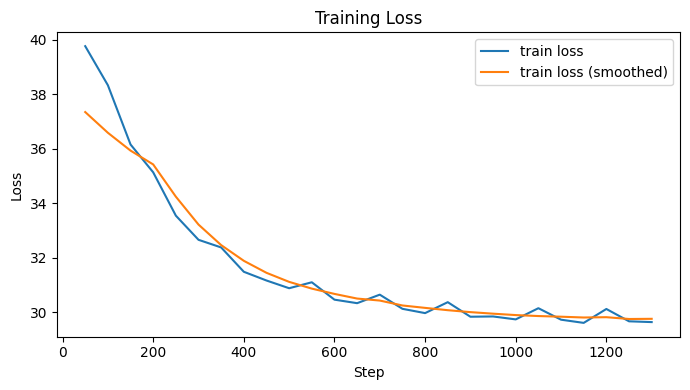

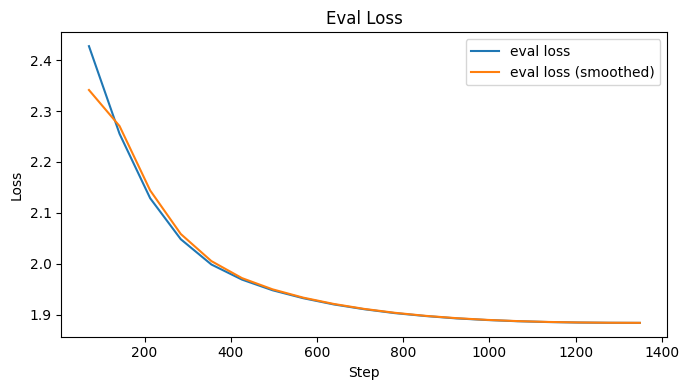

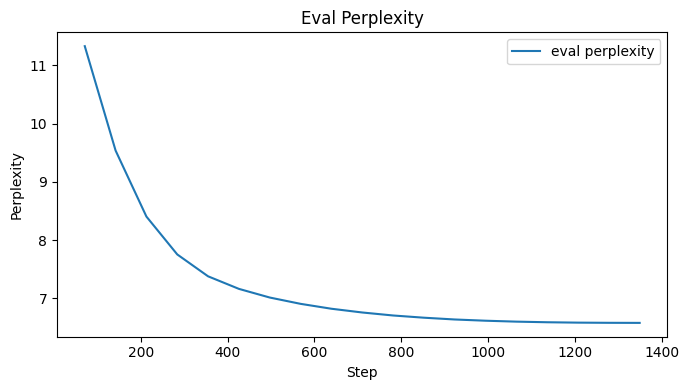

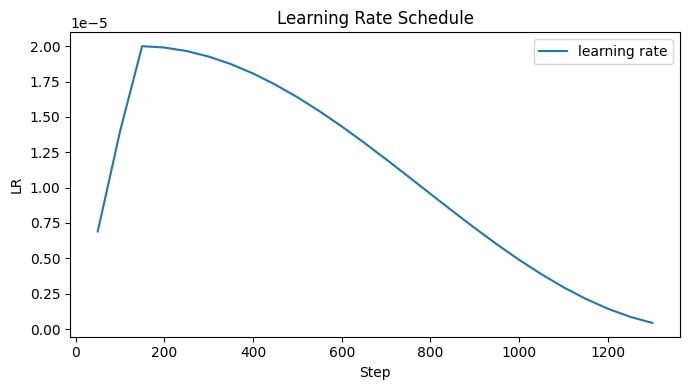

Best eval loss: 1.8836 at step 1349 (perplexity ~ 6.58)
Final train loss: 29.6357 at step 1300


In [ ]:
# ==== Example (fill your student base) ====
TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_smol_360m-v5"

# -------- Trainer config --------
sft_cfg = SFTConfig(
    output_dir=out_dir,
    num_train_epochs=20,
    per_device_train_batch_size=4, #4
    gradient_accumulation_steps=16, #16    # eff batch ~64
    learning_rate=2e-5, # 2e-5
    lr_scheduler_type="cosine",
    warmup_ratio=0.1, # 0.08
    weight_decay=0.05,
    label_smoothing_factor=0.05,
    max_grad_norm=0.5, # 1.0
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss", # eval_loss
    greater_is_better=False,
    fp16=False, bf16=False,
    optim="adamw_bnb_8bit",
    packing=False,
    max_length=1024,
    gradient_checkpointing=True,       # ON
    gradient_checkpointing_kwargs={"use_reentrant": False},
    remove_unused_columns=False,
    dataloader_num_workers=4,   # new
    dataloader_pin_memory=True,  # new
    report_to="none",
    seed=42,
)

try:
  trainer = train_kd_demo_qlora_student(
      TEACHER_ID="HuggingFaceTB/SmolLM2-1.7B-Instruct", #"meta-llama/Llama-3.2-3B-Instruct",        # Teacher
      STUDENT_ID="HuggingFaceTB/SmolLM2-360M-Instruct", #"motionlabs/AMD-Llama-350M-Upgraded",      # Llama-style tiny student
      OUT_DIR=out_dir,
      GOLD_DATASET_ID="zBotta/traffic-accidents-reports-5k", # 5k
      USE_KD_DATASET = False,            # Keep it false as we do not need to regenerate targets with teacher
      DEMO_PROB = 1,
      KD_ALPHA= [0.9, 0.75],     # [start, end]  # CE weight (KL gets 1-KD_ALPHA)
      KD_T= 2.7,                 # temperature for KD
      KD_TOP_K= 32,
      SOFT_KD_GAMMA=1.5,
      SOFT_KD_WMIN=0.20,
      BETA_UL=0.1,
      RANK= 8,
      LORA_DROPOUT = 0.05,
      sft_cfg = sft_cfg,
      MAX_LEN = 1024,
      EVAL_N = 5,                   # number of evaluation examples for metrics & latency
      GEN_MAX_NEW = 256,            # generation budget for eval/latency
  )

  plot_training_results(out_dir, trainer)
except Exception as e:
  print(f"Error while training KD trainer: {e}")
  print("Desconnect Colab session")
  # from google.colab import runtime
  # runtime.unassign()

### Diagnosis

In [ ]:
# %% DIAGNOSTICS: LoRA trainables, log tail, supervised-token fraction
import torch
from pprint import pprint

def kd_diagnostics(trainer, n_batches: int = 5):
    print("\n=== 1) LoRA / trainable parameters ===")
    trainable = [(n, p.numel()) for n, p in trainer.model.named_parameters() if p.requires_grad]
    total = sum(c for _, c in trainable)
    print(f"Total trainable params: {total:,}")
    print("First 20 trainables:")
    for name, cnt in trainable[:20]:
        print(f"  - {name}  ({cnt:,})")
    if total == 0:
        print("⚠️ No trainable params detected — LoRA may not be attached or target_modules don't match.")

    print("\n=== 2) Last ~20 log_history rows ===")
    logs = trainer.state.log_history
    tail = logs[-20:] if len(logs) >= 20 else logs
    for row in tail:
        pprint(row)

    print("\n=== 3) Supervised-token fraction over batches ===")
    dl = trainer.get_train_dataloader()
    fracs = []
    counts = 0
    for i, batch in enumerate(dl):
        if i >= n_batches: break
        labels = batch["labels"]
        mask = (labels != -100)
        frac = mask.float().mean().item()
        fracs.append(frac)
        counts += mask.numel()
        print(f"  batch {i:02d}: frac_supervised = {frac:.4f}  (batch_size={labels.size(0)}, seq_len={labels.size(1)})")
    if fracs:
        print(f"Average over {len(fracs)} batches: {sum(fracs)/len(fracs):.4f}")
    else:
        print("No batches read — check your train dataloader.")

# ---- run it (use your Trainer instance variable) ----
kd_diagnostics(trainer, n_batches=5)



=== 1) LoRA / trainable parameters ===
Total trainable params: 4,341,760
First 20 trainables:
  - base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight  (2,560)
  - base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight  (2,560)
  - base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight  (7,680)
  - base_model.model.model.layers.0.mlp.gate_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.mlp.gate_proj.lora_B.default.weight  (20,480)
  - base_model.model.model.layers.0.mlp.up_proj.lora_A.default.weight 

### Push Distilled model to HF

In [ ]:
# ==== Example (fill your student base) ====
TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_smol_360m-v5"
repo_id = "zBotta/SmolLM2-360M-AccidentReports-distilled-kd1.7B-v5"

from huggingface_hub import HfApi, create_repo, upload_folder, login
merged_dir = f"{out_dir}/merged-fp16" # we should push the adapter model
from google.colab import userdata
hf_token = userdata.get('hf_token')

login(token=hf_token)

api = HfApi(token=hf_token)
try:
  api.create_repo(repo_id, private=True, repo_type="model")
except Exception as e:
  print(f"Repo model {repo_id} already created")
upload_folder(folder_path=merged_dir, repo_id=repo_id, repo_type="model")
print("Pushed:", repo_id)

Repo model zBotta/SmolLM2-360M-AccidentReports-distilled-kd1.7B-v5 already created


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...0m-v5/merged-fp16/model.safetensors:   5%|4         | 33.5MB /  724MB            

Pushed: zBotta/SmolLM2-360M-AccidentReports-distilled-kd1.7B-v5


# More KD! (v6)
Increase the influence of the KL divergence on KD logits

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

Tokenizing train:   0%|          | 0/4499 [00:00<?, ? examples/s]

Tokenizing eval:   0%|          | 0/500 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Truncating train dataset:   0%|          | 0/4499 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Accelerate mixed precision: no
Trainable params: 4341760



[epoch 1] sample report (post-RESP_TMPL)
Report: The report should include the following information: - The date, time, and location of the collision. - The names of the drivers involved. - Any relevant details about the vehicle involved. The document should also contain the following information about the event: * The type of accident (collision)...

[epoch 2] sample report (post-RESP_TMPL)
Report: ``` Report: February 14th, 23:59:00 AM Vehicle A was parked at the Supermarket parking area, near the Pine Plaza store. Vehicles B and A were driving towards each other. Vehicle B was turning right while Vehicle A was turning left. The collision occurred at the intersection of Main Street and Pine A...

[epoch 3] sample report (post-RESP_TMPL)
Report: On November 14, 25, at 1530, a collision occurred between Vehicle A, a sedan driven by Ms. Julia, and a bicycle ridden by Mr. Eric. The incident took place near Lincoln Elementary School, approximately 15 miles south of downtown. Ms. Julia wa

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



=== Accuracy on 5 samples (Teacher) ===


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


ROUGE-Lsum: 0.331  | SacreBLEU: 19.31

=== Accuracy on 5 samples (Student) ===
ROUGE-Lsum: 0.4865  | SacreBLEU: 32.46

--- Sample 1 ---
Ref : On March 10, 2024, at 08:15, Mr. John Smith driving a sedan rear-ended Ms. Laura Green’s SUV at the intersection of Main St and Elm St in Springfield. The SUV had braked suddenly, but Mr. Smith was di...
Teach: Rear-end collision between Vehicle A (sedan) and Vehicle B (SUV) occurred at the intersection of Main St and Elm St, Springfield, on March 10, 2024, at 08:15. The collision was discovered at 08:17, an...
Stud : On March 10, 2024, at 08:15, a rear-end collision occurred at the intersection of Main St and Elm St in Springfield when Vehicle A, a sedan driven by Mr. John Smith, failed to stop in time. Ms. Laura ...

--- Sample 2 ---
Ref : At 11:20 on April 18, 2024, on 5th Avenue & Elm Street, Vehicle A, driven by Mr. Lucas Romero, turned left in front of oncoming Vehicle B, an SUV driven by Ms. Hana Yilmaz, causing a crash. Ms. Yilmaz...
Teac

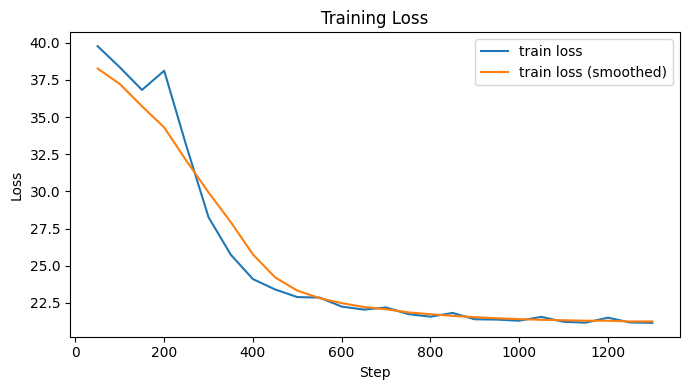

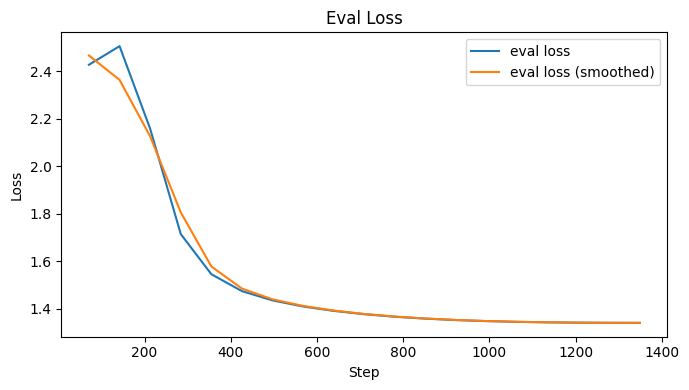

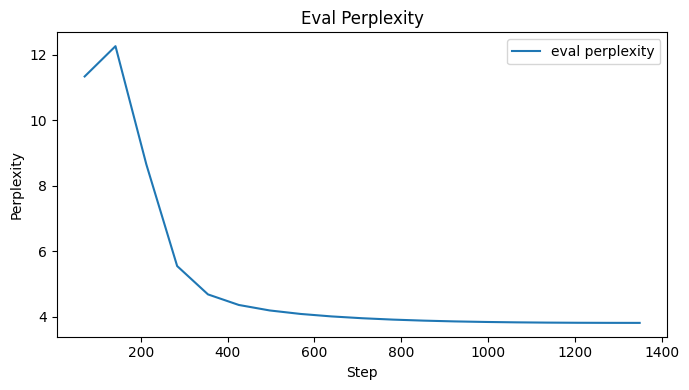

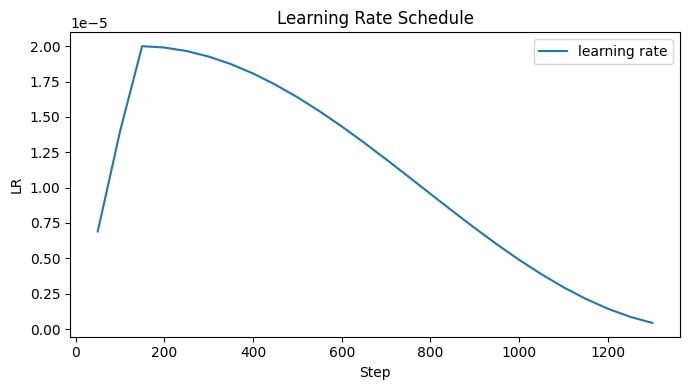

Best eval loss: 1.3401 at step 1349 (perplexity ~ 3.82)
Final train loss: 21.1618 at step 1300

=== 1) LoRA / trainable parameters ===
Total trainable params: 4,341,760
First 20 trainables:
  - base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight  (2,560)
  - base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight  (2,560)
  - base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight  (7,680)
  - base_model.model.model.layers.0.mlp.gate_proj.lora_A.default.weight  (7,680)
  - base_model.model.model.layers.0.mlp.gate_proj.lora_B.

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...0m-v6/merged-fp16/model.safetensors:   3%|3         | 25.2MB /  724MB            

Pushed: zBotta/SmolLM2-360M-AccidentReports-distilled-kd1.7B-v6


In [6]:
# ==== Example (fill your student base) ====
TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_smol_360m-v6"

# -------- Trainer config --------
sft_cfg = SFTConfig(
    output_dir=out_dir,
    num_train_epochs=20,
    per_device_train_batch_size=4, #4
    gradient_accumulation_steps=16, #16    # eff batch ~64
    learning_rate=2e-5, # 2e-5
    lr_scheduler_type="cosine",
    warmup_ratio=0.1, # 0.08
    weight_decay=0.05,
    label_smoothing_factor=0.05,
    max_grad_norm=0.5, # 1.0
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss", # eval_loss
    greater_is_better=False,
    fp16=False, bf16=False,
    optim="adamw_bnb_8bit",
    packing=False,
    max_length=1024,
    gradient_checkpointing=True,       # ON
    gradient_checkpointing_kwargs={"use_reentrant": False},
    remove_unused_columns=False,
    dataloader_num_workers=4,   # new
    dataloader_pin_memory=True,  # new
    report_to="none",
    seed=42,
)

try:
  trainer = train_kd_demo_qlora_student(
      TEACHER_ID="HuggingFaceTB/SmolLM2-1.7B-Instruct", #"meta-llama/Llama-3.2-3B-Instruct",        # Teacher
      STUDENT_ID="HuggingFaceTB/SmolLM2-360M-Instruct", #"motionlabs/AMD-Llama-350M-Upgraded",      # Llama-style tiny student
      OUT_DIR=out_dir,
      GOLD_DATASET_ID="zBotta/traffic-accidents-reports-5k", # 5k
      USE_KD_DATASET = False,            # Keep it false as we do not need to regenerate targets with teacher
      DEMO_PROB = 1,
      KD_ALPHA= [0.6, 0.3],     # [start, end]  # CE weight (KL gets 1-KD_ALPHA)
      KD_T= 3,                 # temperature for KD
      KD_TOP_K= 64,
      SOFT_KD_GAMMA=1.0,
      SOFT_KD_WMIN=0.15,
      BETA_UL=0.05,
      RANK= 8,
      LORA_DROPOUT = 0.05,
      sft_cfg = sft_cfg,
      MAX_LEN = 1024,
      EVAL_N = 5,                   # number of evaluation examples for metrics & latency
      GEN_MAX_NEW = 256,            # generation budget for eval/latency
  )

  plot_training_results(out_dir, trainer)
except Exception as e:
  print(f"Error while training KD trainer: {e}")
  print("Desconnect Colab session")
  # from google.colab import runtime
  # runtime.unassign()

# %% DIAGNOSTICS: LoRA trainables, log tail, supervised-token fraction
import torch
from pprint import pprint

def kd_diagnostics(trainer, n_batches: int = 5):
    print("\n=== 1) LoRA / trainable parameters ===")
    trainable = [(n, p.numel()) for n, p in trainer.model.named_parameters() if p.requires_grad]
    total = sum(c for _, c in trainable)
    print(f"Total trainable params: {total:,}")
    print("First 20 trainables:")
    for name, cnt in trainable[:20]:
        print(f"  - {name}  ({cnt:,})")
    if total == 0:
        print("⚠️ No trainable params detected — LoRA may not be attached or target_modules don't match.")

    print("\n=== 2) Last ~20 log_history rows ===")
    logs = trainer.state.log_history
    tail = logs[-20:] if len(logs) >= 20 else logs
    for row in tail:
        pprint(row)

    print("\n=== 3) Supervised-token fraction over batches ===")
    dl = trainer.get_train_dataloader()
    fracs = []
    counts = 0
    for i, batch in enumerate(dl):
        if i >= n_batches: break
        labels = batch["labels"]
        mask = (labels != -100)
        frac = mask.float().mean().item()
        fracs.append(frac)
        counts += mask.numel()
        print(f"  batch {i:02d}: frac_supervised = {frac:.4f}  (batch_size={labels.size(0)}, seq_len={labels.size(1)})")
    if fracs:
        print(f"Average over {len(fracs)} batches: {sum(fracs)/len(fracs):.4f}")
    else:
        print("No batches read — check your train dataloader.")

# ---- run it (use your Trainer instance variable) ----
kd_diagnostics(trainer, n_batches=5)

# ==== Example (fill your student base) ====
TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/student_kd_smol_360m-v6"
repo_id = "zBotta/SmolLM2-360M-AccidentReports-distilled-kd1.7B-v6"

from huggingface_hub import HfApi, create_repo, upload_folder, login
merged_dir = f"{out_dir}/merged-fp16" # we should push the adapter model
from google.colab import userdata
hf_token = userdata.get('hf_token')

login(token=hf_token)

api = HfApi(token=hf_token)
try:
  api.create_repo(repo_id, private=True, repo_type="model")
except Exception as e:
  print(f"Repo model {repo_id} already created")
upload_folder(folder_path=merged_dir, repo_id=repo_id, repo_type="model")
print("Pushed:", repo_id)

# Kill session

In [ ]:
# KILL SESSION TO AVOID LEAVING SESSION ON AND CONSUME GPU UNITS

from google.colab import runtime
runtime.unassign()

[texto del enlace](https://)

# Compact class

Unified Trainer manager that provides:
- demo SFT with QLoRA (train_demo_qlora)
- KD+QLoRA student training (basic) (train_kd_basic)
- KD+QLoRA student training (advanced with top-K KD, UL, CE schedule, eval/latency) (train_kd_advanced)

In [ ]:
# ==========================================
# TrainerManager: QLoRA SFT + KD Distillation (basic & advanced)
# ==========================================
import os, re, json, math, time, gc, random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,
    EarlyStoppingCallback, GenerationConfig, TrainerCallback
)
from peft import LoraConfig, get_peft_model, PeftModel
from trl import SFTConfig, SFTTrainer

# Speed & stability on T4 with 4-bit bnb
torch.backends.cuda.matmul.allow_tf32 = True
os.environ.setdefault("ACCELERATE_MIXED_PRECISION", "no")


class TrainerManager:
    """
    Unified manager that provides:
      - demo SFT with QLoRA (train_demo_qlora)
      - KD+QLoRA student training (basic) (train_kd_basic)
      - KD+QLoRA student training (advanced with top-K KD, UL, CE schedule, eval/latency) (train_kd_advanced)
    It also includes plotting and artifact saving helpers.
    """

    # --------- Prompt templates (shared) ---------
    RESP_TMPL = "### Response:\n"
    INSTR = """
You are a reporting agent.
You task is to create a report when provided the what, when, why, who, how and where questions about the events.
You are also given information about the contingency actions regarding the event.

Guidelines:
- Generate only one report given the informations about the event
- Generate the report as text in one paragraph
- It is important to focus on accuracy and coherence when generating the report so that the description content matches the information provided (what, when, where, who, how , why, contingency actions).
  If an information is not provided in (what, when, where, who, how , why, contingency actions), it must not be part of the generated text description.
""".strip()

    # --------- Universal helpers ---------
    @staticmethod
    def one_line(s: str) -> str:
        return re.sub(r"\s+", " ", str(s).replace("\n", " ")).strip()

    @classmethod
    def prompt_with_demo(cls, demo_in: str, demo_out: str, current_in: str) -> str:
        return (
            "### Instruction:\n" + cls.INSTR + "\n\n" +
            "### Input-example:\n" + demo_in + "\n\n" +
            "### Output-example:\n" + cls.one_line(demo_out) + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            cls.RESP_TMPL
        )

    @classmethod
    def prompt_no_demo(cls, current_in: str) -> str:
        return (
            "### Instruction:\n" + cls.INSTR + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            cls.RESP_TMPL
        )

    @staticmethod
    def guess_lora_targets(model) -> List[str]:
        """Heuristic to select LoRA target modules across llama/mistral-ish stacks."""
        names = set()
        for n, mod in model.named_modules():
            if isinstance(mod, torch.nn.Linear):
                names.add(n.split(".")[-1])
        preferred = [x for x in ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj",
                                 "wi","wo","wq","wk","wv","out_proj","fc_in","fc_out"] if x in names]
        if preferred:
            return preferred
        return sorted(list({n for n in names if n != "lm_head"}))

    @staticmethod
    def make_4bit_config() -> BitsAndBytesConfig:
        return BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16
        )

    @dataclass
    class CausalLMPadCollator:
        pad_id: int
        def __call__(self, feats: List[Dict]):
            L = max(len(f["input_ids"]) for f in feats)
            def pad(x, v): return x + [v]*(L - len(x))
            batch = {
                "input_ids": torch.tensor([pad(f["input_ids"], self.pad_id) for f in feats]),
                "attention_mask": torch.tensor([pad(f["attention_mask"], 0) for f in feats]),
                "labels": torch.tensor([pad(f["labels"], -100) for f in feats]),
            }
            if not (batch["labels"] != -100).any():
                raise RuntimeError("Batch has no supervised tokens.")
            return batch

    # --------- Plotting (deduplicated) ---------
    @staticmethod
    def plot_training_results(out_dir: str, trainer: SFTTrainer):
        logs = pd.DataFrame(trainer.state.log_history)
        if logs.empty:
            print("No logs recorded. Did logging_steps/eval_steps run?")
            return

        os.makedirs(out_dir, exist_ok=True)
        csv_path = os.path.join(out_dir, "training_logs.csv")
        logs.to_csv(csv_path, index=False)
        print("Saved raw logs to:", csv_path)

        def safe_exp(x):
            try: return float(np.exp(x))
            except Exception: return np.nan

        train_df = logs[logs["loss"].notna()][["step","loss"]].copy()
        eval_df  = logs[logs["eval_loss"].notna()][["step","eval_loss"]].copy()
        lr_df    = logs[logs["learning_rate"].notna()][["step","learning_rate"]].copy()

        if not eval_df.empty:  eval_df["eval_perplexity"] = eval_df["eval_loss"].map(safe_exp)
        if not train_df.empty: train_df["perplexity"] = train_df["loss"].map(safe_exp)

        def smooth(y, k=5):
            s = pd.Series(y)
            return s.rolling(k, min_periods=1, center=True).mean().values

        if not train_df.empty:
            plt.figure(figsize=(7,4))
            plt.plot(train_df["step"], train_df["loss"], label="train loss")
            plt.plot(train_df["step"], smooth(train_df["loss"], 7), label="train loss (smoothed)")
            plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Training Loss")
            plt.legend(); plt.tight_layout()
            plt.savefig(os.path.join(out_dir, "train_loss.png")); plt.show()

        if not eval_df.empty:
            plt.figure(figsize=(7,4))
            plt.plot(eval_df["step"], eval_df["eval_loss"], label="eval loss")
            plt.plot(eval_df["step"], smooth(eval_df["eval_loss"], 3), label="eval loss (smoothed)")
            plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Eval Loss")
            plt.legend(); plt.tight_layout()
            plt.savefig(os.path.join(out_dir, "eval_loss.png")); plt.show()

            plt.figure(figsize=(7,4))
            plt.plot(eval_df["step"], eval_df["eval_perplexity"], label="eval perplexity")
            plt.xlabel("Step"); plt.ylabel("Perplexity"); plt.title("Eval Perplexity")
            plt.legend(); plt.tight_layout()
            plt.savefig(os.path.join(out_dir, "eval_perplexity.png")); plt.show()

        if not lr_df.empty:
            plt.figure(figsize=(7,4))
            plt.plot(lr_df["step"], lr_df["learning_rate"], label="learning rate")
            plt.xlabel("Step"); plt.ylabel("LR"); plt.title("Learning Rate Schedule")
            plt.legend(); plt.tight_layout()
            plt.savefig(os.path.join(out_dir, "learning_rate.png")); plt.show()

        if not eval_df.empty:
            best_row = eval_df.loc[eval_df["eval_loss"].idxmin()]
            print(f"Best eval loss: {best_row['eval_loss']:.4f} at step {int(best_row['step'])} "
                  f"(perplexity ~ {best_row['eval_perplexity']:.2f})")
        if not train_df.empty:
            print(f"Final train loss: {train_df['loss'].iloc[-1]:.4f} at step {int(train_df['step'].iloc[-1])}")

    # --------- Artifact saving (deduplicated) ---------
    @staticmethod
    def save_adapter_and_merged_fp16(
        trainer: SFTTrainer,
        tokenizer: AutoTokenizer,
        base_model_id: str,
        out_dir: str
    ) -> Tuple[str, str]:
        """
        Saves:
          - LoRA adapter to {out_dir}/adapter
          - merged FP16 checkpoint to {out_dir}/merged-fp16
        Returns: (adapter_dir, merged_dir)
        """
        from transformers import AutoModelForCausalLM

        adapter_dir = os.path.join(out_dir, "adapter")
        os.makedirs(adapter_dir, exist_ok=True)
        trainer.model.save_pretrained(adapter_dir)
        tokenizer.save_pretrained(adapter_dir)
        print("✅ Saved LoRA adapter to:", adapter_dir)

        merged_dir = os.path.join(out_dir, "merged-fp16")
        os.makedirs(merged_dir, exist_ok=True)

        base_fp16 = AutoModelForCausalLM.from_pretrained(
            base_model_id, torch_dtype=torch.float16, device_map="cpu"
        )
        peft_best = PeftModel.from_pretrained(base_fp16, trainer.state.best_model_checkpoint or adapter_dir)
        merged = peft_best.merge_and_unload().eval()

        if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
            tokenizer.pad_token = tokenizer.eos_token

        merged.save_pretrained(merged_dir, safe_serialization=True)
        tokenizer.save_pretrained(merged_dir)

        gen_cfg = {
            "max_new_tokens": 300,
            "do_sample": True,
            "eos_token_id": tokenizer.eos_token_id,
            "pad_token_id": tokenizer.pad_token_id
        }
        with open(os.path.join(merged_dir, "generation_config.json"), "w") as f:
            json.dump(gen_cfg, f)

        print("✅ Merged FP16 model saved to:", merged_dir)
        return adapter_dir, merged_dir

    # ==========================================
    # 1) DEMO SFT with QLoRA  (from training function 1)
    # ==========================================
    def train_demo_qlora(
        self,
        sft_cfg: SFTConfig,
        MODEL_ID: str = "HuggingFaceTB/SmolLM2-360M-Instruct",
        OUT_DIR: str = "smollm2_demo_qlora",
        DEMO_PROB: float = 1.0,
        DATASET_ID: str = "zBotta/traffic-accidents-reports-800",
        MAX_LEN: int = 1024
    ) -> SFTTrainer:
        from transformers import AutoModelForCausalLM

        raw_any = load_dataset(DATASET_ID)
        assert "train" in raw_any and "eval" in raw_any, "Dataset must have 'train' and 'eval' splits."

        def ok(rec: Dict) -> bool:
            return bool(str(rec.get("input","")).strip()) and bool(str(rec.get("target","")).strip())

        ds_raw = DatasetDict(
            train=raw_any["train"].filter(ok),
            eval=raw_any["eval"].filter(ok)
        )

        demo_pool: List[Tuple[str,str]] = [(self.one_line(ex["input"]), self.one_line(ex["target"])) for ex in ds_raw["train"]]

        tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
        if tok.pad_token_id is None: tok.pad_token = tok.eos_token

        def add_demo_and_tokenize(example, idx):
            cur_in  = self.one_line(example["input"])
            cur_out = self.one_line(example["target"])
            use_demo = (np.random.rand() < DEMO_PROB) and (len(demo_pool) > 1)
            if use_demo:
                d_in, d_out = demo_pool[(idx+1) % len(demo_pool)]
                prompt = self.prompt_with_demo(d_in, d_out, cur_in)
            else:
                prompt = self.prompt_no_demo(cur_in)

            prom = tok(prompt, add_special_tokens=True, truncation=True, max_length=MAX_LEN, padding=False)
            prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

            if len(prompt_ids) >= MAX_LEN - 4:
                prom = tok(self.prompt_no_demo(cur_in), add_special_tokens=True, truncation=True, max_length=MAX_LEN, padding=False)
                prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

            budget = MAX_LEN - len(prompt_ids)
            targ = tok(cur_out, add_special_tokens=False, truncation=True, max_length=max(1,budget), padding=False)
            target_ids = targ["input_ids"][:max(0,budget)]

            input_ids      = prompt_ids + target_ids
            attention_mask = attn_prompt + [1]*len(target_ids)
            labels         = [-100]*len(prompt_ids) + target_ids
            if not target_ids:
                eos = tok.eos_token_id
                input_ids += [eos]; attention_mask += [1]; labels += [eos]
            return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

        ds_tok = DatasetDict(
            train=ds_raw["train"].map(add_demo_and_tokenize, with_indices=True, remove_columns=ds_raw["train"].column_names, desc="Build+tokenize train"),
            eval =ds_raw["eval"].map(add_demo_and_tokenize,  with_indices=True, remove_columns=ds_raw["eval"].column_names,  desc="Build+tokenize eval")
        ).remove_columns([c for c in ds_raw["train"].column_names if c not in ("input_ids","attention_mask","labels")])
        ds_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

        bnb4 = self.make_4bit_config()
        model = AutoModelForCausalLM.from_pretrained(MODEL_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto")
        model.config.use_cache = False

        # prefer explicit targets; fallback to heuristic guesser if needed
        target_modules = ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"]
        if not any(any(t in n for n,_ in model.named_modules()) for t in target_modules):
            target_modules = self.guess_lora_targets(model)

        lora_cfg = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.05, target_modules=target_modules, task_type="CAUSAL_LM")
        collator = self.CausalLMPadCollator(tok.pad_token_id)

        trainer = SFTTrainer(
            model=model,
            args=sft_cfg,
            peft_config=lora_cfg,
            train_dataset=ds_tok["train"],
            eval_dataset=ds_tok["eval"],
            data_collator=collator,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=1e-3)],
        )
        trainer.train()

        # Save artifacts (adapter + merged FP16)
        self.save_adapter_and_merged_fp16(trainer, tok, MODEL_ID, OUT_DIR)
        return trainer

    # ==========================================
    # 2) KD + QLoRA student (BASIC)  (from training function 2)
    #    Renamed trainer to avoid collision: DistillSFTTrainerBasic
    # ==========================================
    class DistillSFTTrainerBasic(SFTTrainer):
        def __init__(self, *args, teacher_model=None, kd_alpha=0.5, kd_temp=2.0, **kwargs):
            super().__init__(*args, **kwargs)
            assert teacher_model is not None
            self.teacher = teacher_model.eval()
            for p in self.teacher.parameters(): p.requires_grad_(False)
            self.kd_alpha = float(kd_alpha)
            self.kd_temp = float(kd_temp)

        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
            labels = inputs.pop("labels")
            out_s = model(**inputs, use_cache=False)
            logits_s = out_s.logits
            with torch.inference_mode():
                out_t = self.teacher(**inputs, use_cache=False)
                logits_t = out_t.logits

            # next-token alignment
            ls = logits_s[:, :-1, :].contiguous()
            lt = logits_t[:, :-1, :].contiguous()
            y  = labels[:, 1:].contiguous()
            m  = (y != -100)

            if not m.any():
                loss = torch.zeros((), device=logits_s.device, dtype=logits_s.dtype)
                return (loss, out_s) if return_outputs else loss

            logp_s = torch.log_softmax(ls, dim=-1)
            ce = torch.nn.functional.nll_loss(logp_s[m], y[m], reduction="mean")

            T = self.kd_temp
            logp_s_T = torch.log_softmax(ls / T, dim=-1)
            p_t_T    = torch.softmax(lt / T, dim=-1)
            kl_tok   = torch.nn.functional.kl_div(logp_s_T, p_t_T, reduction="none").sum(dim=-1)
            kd = (kl_tok[m]).mean() * (T * T)

            loss = self.kd_alpha * ce + (1.0 - self.kd_alpha) * kd
            return (loss, out_s) if return_outputs else loss

    def train_kd_basic(
        self,
        STUDENT_ID: str,
        TEACHER_ID: str,
        sft_cfg: SFTConfig,
        OUT_DIR: str = "student_kd_output",
        KD_DATASET_REPO: str = "zBotta/traffic-accidents-reports-kd-smollm2-360M-7k",
        DEMO_PROB: float = 0.8,
        KD_ALPHA: float = 0.5,
        KD_T: float = 2.0,
        RANK: int = 8,
        MAX_LEN: int = 1024
    ) -> SFTTrainer:
        raw_kd = load_dataset(KD_DATASET_REPO)
        assert "train" in raw_kd and "eval" in raw_kd

        # tokenizers MUST match for logit KD
        tok_student = AutoTokenizer.from_pretrained(STUDENT_ID, use_fast=True)
        tok_teacher = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
        if tok_student.pad_token_id is None: tok_student.pad_token = tok_student.eos_token
        if tok_teacher.pad_token_id is None: tok_teacher.pad_token = tok_teacher.eos_token
        assert tok_student.get_vocab() == tok_teacher.get_vocab(), \
            "Tokenizer mismatch: choose student & teacher with identical tokenizers for logit KD."

        # Build a small demo pool from train (use KD dataset inputs/targets)
        def ok(r): return bool(str(r.get("input","")).strip()) and bool(str(r.get("target","")).strip())
        ds_raw = DatasetDict(train=raw_kd["train"].filter(ok), eval=raw_kd["eval"].filter(ok))
        demo_pool = [(self.one_line(r["input"]), self.one_line(r["target"])) for r in ds_raw["train"]]

        def add_demo_and_tokenize(example, idx):
            cur_in, cur_out = self.one_line(example["input"]), self.one_line(example["target"])
            use_demo = (np.random.rand() < DEMO_PROB) and (len(demo_pool) > 1)
            if use_demo:
                d_in, d_out = demo_pool[(idx+1) % len(demo_pool)]
                prompt = self.prompt_with_demo(d_in, d_out, cur_in)
            else:
                prompt = self.prompt_no_demo(cur_in)

            prom = tok_student(prompt, add_special_tokens=True, truncation=True, max_length=MAX_LEN)
            prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

            if len(prompt_ids) >= MAX_LEN - 4:
                prom = tok_student(self.prompt_no_demo(cur_in), add_special_tokens=True, truncation=True, max_length=MAX_LEN)
                prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

            eos = tok_student.eos_token_id
            if eos is None:
                tok_student.pad_token = tok_student.eos_token
                eos = tok_student.eos_token_id

            budget = MAX_LEN - len(prompt_ids)
            if budget <= 0:
                prompt_ids = prompt_ids[:-1]; attn_prompt = attn_prompt[:-1]
                budget = 1

            allow = max(0, budget - 1)
            targ_ids = tok_student(cur_out, add_special_tokens=False, truncation=True, max_length=max(1, allow)).input_ids
            targ_ids = targ_ids[:allow]
            target_with_eos = targ_ids + [eos]

            input_ids      = prompt_ids + target_with_eos
            attention_mask = attn_prompt + [1]*len(target_with_eos)
            labels         = [-100]*len(prompt_ids) + target_with_eos
            return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

        ds_tok = DatasetDict(
            train = ds_raw["train"].map(add_demo_and_tokenize, with_indices=True, remove_columns=ds_raw["train"].column_names, desc="Tokenize train"),
            eval  = ds_raw["eval"].map(add_demo_and_tokenize,  with_indices=True, remove_columns=ds_raw["eval"].column_names,  desc="Tokenize eval"),
        )

        bnb4 = self.make_4bit_config()
        student = AutoModelForCausalLM.from_pretrained(STUDENT_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto")
        student.config.use_cache = False
        teacher = AutoModelForCausalLM.from_pretrained(TEACHER_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto").eval()
        for p in teacher.parameters(): p.requires_grad_(False)

        lora_cfg = LoraConfig(
            r=RANK, lora_alpha=2*RANK, lora_dropout=0.05,
            target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
            task_type="CAUSAL_LM"
        )
        collator = self.CausalLMPadCollator(tok_student.pad_token_id)

        trainer = self.DistillSFTTrainerBasic(
            model=student,
            args=sft_cfg,
            peft_config=lora_cfg,
            train_dataset=ds_tok["train"],
            eval_dataset=ds_tok["eval"],
            data_collator=collator,
            teacher_model=teacher,
            kd_alpha=KD_ALPHA,
            kd_temp=KD_T,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=1e-3)],
        )
        print("Accelerate mixed precision:", trainer.accelerator.mixed_precision)
        print("Trainable params:", sum(p.numel() for p in trainer.model.parameters() if p.requires_grad))

        trainer.train()
        self.save_adapter_and_merged_fp16(trainer, tok_student, STUDENT_ID, OUT_DIR)
        return trainer

    # ==========================================
    # 3) KD + QLoRA student (ADVANCED)  (from training function 3)
    #    Renamed trainer to avoid collision: DistillSFTTrainerAdvanced
    # ==========================================
    class DistillSFTTrainerAdvanced(SFTTrainer):
        def __init__(self, *args,
                     teacher_model=None,
                     kd_alpha_ce_start=0.85,
                     kd_alpha_ce_end=0.65,
                     kd_warmup_epochs=2,
                     kd_ramp_epochs=2,
                     kd_temp=3.0,
                     kd_top_K=128,
                     beta_ul=0.1,
                     ce_smoothing=0.05,
                     soft_kd_gamma=2.0,
                     soft_kd_wmin=0.05,
                     **kwargs):
            super().__init__(*args, **kwargs)
            assert teacher_model is not None
            self.teacher = teacher_model.eval()
            for p in self.teacher.parameters(): p.requires_grad_(False)
            self.kd_alpha_ce_start = float(kd_alpha_ce_start)
            self.kd_alpha_ce_end   = float(kd_alpha_ce_end)
            self.kd_warmup_epochs  = int(kd_warmup_epochs)
            self.kd_ramp_epochs    = int(kd_ramp_epochs)
            self.kd_temp           = float(kd_temp)
            self.kd_top_K          = int(kd_top_K)
            self.beta_ul           = float(beta_ul)
            self.ce_smoothing      = float(ce_smoothing)
            self.soft_kd_gamma     = float(soft_kd_gamma)
            self.soft_kd_wmin      = float(soft_kd_wmin)

        def _ce_weight(self):
            e = float(self.state.epoch or 0.0)
            if e < self.kd_warmup_epochs: return 1.0
            if e < self.kd_warmup_epochs + self.kd_ramp_epochs:
                t = (e - self.kd_warmup_epochs) / max(1.0, self.kd_ramp_epochs)
                return self.kd_alpha_ce_start + (self.kd_alpha_ce_end - self.kd_alpha_ce_start) * t
            return self.kd_alpha_ce_end

        def _smoothed_ce(self, logp, labels, mask, eps=0.05):
            gather = torch.gather(logp, -1, labels.clamp_min(0).unsqueeze(-1)).squeeze(-1)
            nll = -(gather[mask]).mean()
            H   = -(logp[mask]).mean()
            return (1 - eps) * nll + eps * H

        def compute_loss(self, model, inputs, return_outputs=False, **kw):
            labels = inputs.pop("labels")
            out_s = model(**inputs, use_cache=False)
            logits_s = out_s.logits

            logits_s_shift = logits_s[:, :-1, :]
            labels_shift   = labels[:, 1:]
            mask_shift     = (labels_shift != -100)

            logp_s_shift = torch.log_softmax(logits_s_shift, dim=-1)
            ce = self._smoothed_ce(logp_s_shift, labels_shift, mask_shift, eps=self.ce_smoothing)

            ce_w = self._ce_weight()
            if ce_w >= 0.999:
                return (ce, out_s) if return_outputs else ce

            with torch.inference_mode():
                out_t = self.teacher(**inputs, use_cache=False)
                logits_t_shift = out_t.logits[:, :-1, :]

            T = self.kd_temp
            V = logits_s_shift.shape[-1]
            K = min(self.kd_top_K, V)
            topk_val, topk_idx = torch.topk(logits_t_shift / T, k=K, dim=-1)
            p_t_topk = torch.softmax(topk_val, dim=-1)
            conf = p_t_topk[..., 0]
            w = torch.clamp(conf ** self.soft_kd_gamma, min=self.soft_kd_wmin) * mask_shift.float()
            has_kd = (w.sum() > 0)

            if has_kd:
                logp_s_T_shift = torch.log_softmax(logits_s_shift / T, dim=-1)
                gather_logp_s  = torch.gather(logp_s_T_shift, -1, topk_idx)
                kl_pos = torch.sum(p_t_topk * (torch.log(p_t_topk + 1e-9) - gather_logp_s), dim=-1)
                kd = (w * kl_pos).sum() / (w.sum() + 1e-6)
            else:
                kd = torch.zeros((), device=logits_s.device)

            beta_ul = self.beta_ul
            if beta_ul > 0:
                prev_tok = inputs["input_ids"][:, :-1]
                p_next   = torch.softmax(logits_s_shift, dim=-1)
                p_repeat = torch.gather(p_next, -1, prev_tok.unsqueeze(-1)).squeeze(-1)
                ul = -torch.log(1.0 - p_repeat + 1e-6)
                ul = (ul[mask_shift]).mean() if mask_shift.any() else torch.zeros((), device=logits_s.device)
            else:
                ul = torch.zeros((), device=logits_s.device)

            kd_w = 1.0 - ce_w
            loss = ce_w * ce + kd_w * kd + beta_ul * ul

            if self.state.global_step % 50 == 0:
                self.log({
                    "train/ce": float(ce.detach()),
                    "train/kd": float(kd.detach()),
                    "train/ul": float(ul.detach()),
                    "train/ce_weight": float(ce_w),
                    "train/kd_weight": float(kd_w),
                })
            return (loss, out_s) if return_outputs else loss

    class SampleGenerateCallback(TrainerCallback):
        def __init__(self, tok, make_prompt_fn, eval_ds, max_new=180, resp_marker="### Response:\n"):
            self.tok = tok
            self.make_prompt_fn = make_prompt_fn
            self.eval_ds = eval_ds
            self.max_new = max_new
            self.resp_marker = resp_marker
            self.rng = np.random.default_rng(123)

        @staticmethod
        def _one_line(s: str) -> str:
            return re.sub(r"\s+", " ", str(s).replace("\n", " ")).strip()

        def _extract_report(self, decoded_full: str, decoded_new: str) -> str:
            marker = self.resp_marker.strip()
            idx = decoded_full.find(marker)
            out = decoded_full[idx + len(marker):] if idx != -1 else decoded_new
            out = out.split("###", 1)[0]
            out = re.sub(r'^\s*(#+\s*Response:)?\s*', '', out)
            out = re.sub(r'^\s*(Factual\s+(paragraph|report)\s*:)\s*', '', out, flags=re.I)
            return self._one_line(out)

        def _gen(self, model, prompt: str, MAX_LEN=1024) -> str:
            device = next(model.parameters()).device
            enc = self.tok([prompt], return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
            enc = {k: v.to(device) for k, v in enc.items()}
            with torch.inference_mode():
                out = model.generate(
                    **enc,
                    do_sample=False,
                    max_new_tokens=self.max_new,
                    no_repeat_ngram_size=4,
                    repetition_penalty=1.05,
                    renormalize_logits=True,
                    eos_token_id=self.tok.eos_token_id,
                    pad_token_id=self.tok.pad_token_id
                )
            input_len = int(enc["attention_mask"].sum().item())
            decoded_full = self.tok.decode(out[0], skip_special_tokens=True)
            decoded_new  = self.tok.decode(out[0, input_len:], skip_special_tokens=True)
            return self._extract_report(decoded_full, decoded_new)

        def on_epoch_end(self, args, state, control, **kwargs):
            model = kwargs["model"]
            was_training = model.training
            model.eval()
            try:
                idx = int(self.rng.integers(0, len(self.eval_ds)))
                cur_in = self._one_line(self.eval_ds[idx]["input"])
                prompt = self.make_prompt_fn(cur_in)
                text = self._gen(model, prompt)
                print(f"\n[epoch {int(state.epoch)}] sample report (post-RESP_TMPL)")
                print("Report:", (text[:300] + ("..." if len(text) > 300 else "")))
            finally:
                if was_training: model.train()
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def train_kd_advanced(
        self,
        STUDENT_ID: str = "HuggingFaceTB/SmolLM2-360M-Instruct",
        TEACHER_ID: str = "HuggingFaceTB/SmolLM2-1.7B-Instruct",
        sft_cfg: Optional[SFTConfig] = None,
        OUT_DIR: str = "student_kd_output",
        GOLD_DATASET_ID: str = "zBotta/traffic-accidents-reports-5k",
        USE_KD_DATASET: bool = False,
        KD_DATASET_REPO: Optional[str] = None,
        DEMO_PROB: float = 0.8,
        KD_ALPHA: List[float] = [0.85, 0.65],
        KD_T: float = 2.0,
        KD_TOP_K: int = 128,
        SOFT_KD_WMIN: float = 0.05,
        SOFT_KD_GAMMA: float = 2.0,
        BETA_UL: float = 0.1,
        RANK: int = 8,
        LORA_DROPOUT: float = 0.05,
        MAX_LEN: int = 1024,
        EVAL_N: int = 5,
        GEN_MAX_NEW: int = 256,
    ) -> SFTTrainer:
        # Load GOLD dataset
        raw_gold = load_dataset(GOLD_DATASET_ID)
        assert "train" in raw_gold and "eval" in raw_gold
        def ok(r): return bool(str(r.get("input","")).strip()) and bool(str(r.get("target","")).strip())
        ds_gold = DatasetDict(train=raw_gold["train"].filter(ok), eval=raw_gold["eval"].filter(ok))
        demo_pool = [(self.one_line(r["input"]), self.one_line(r["target"])) for r in ds_gold["train"]]

        tok_student = AutoTokenizer.from_pretrained(STUDENT_ID, use_fast=True)
        tok_teacher = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
        if tok_student.pad_token_id is None: tok_student.pad_token = tok_student.eos_token
        if tok_teacher.pad_token_id is None: tok_teacher.pad_token = tok_teacher.eos_token
        if tok_student.get_vocab() != tok_teacher.get_vocab():
            raise RuntimeError("Tokenizer mismatch: student and teacher must share IDENTICAL vocab for logit KD.")

        bnb4 = self.make_4bit_config()
        teacher_for_logits = AutoModelForCausalLM.from_pretrained(
            TEACHER_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto"
        ).eval()
        for p in teacher_for_logits.parameters(): p.requires_grad_(False)

        # Optional KD dataset source
        def try_load_kd_repo(repo_id: Optional[str]) -> Optional[DatasetDict]:
            if not repo_id: return None
            try:
                ds = load_dataset(repo_id)
                if "train" in ds and "eval" in ds and all(k in ds["train"].column_names for k in ("input","target")):
                    print(f"✅ KD dataset loaded from: {repo_id}")
                    return DatasetDict(train=ds["train"], eval=ds["eval"])
                else:
                    print(f"⚠️ KD repo {repo_id} missing expected splits/columns; will generate from GOLD.")
                    return None
            except Exception as e:
                print(f"⚠️ Could not load KD repo {repo_id}: {e}\nWill generate teacher outputs from GOLD.")
                return None

        ds_base = None
        need_kd_from_gold = False
        if USE_KD_DATASET:
            ds_base = try_load_kd_repo(KD_DATASET_REPO)
            need_kd_from_gold = ds_base is None
        else:
            ds_base = ds_gold

        # Generate teacher texts if needed (no-demo prompts)
        def gen_teacher_texts(ds: Dataset, batch_size: int = 4, max_new: int = 256) -> List[str]:
            outs = []
            device = next(teacher_for_logits.parameters()).device
            for i in range(0, len(ds), batch_size):
                batch = ds[i:i+batch_size]
                prompts = [self.prompt_no_demo(self.one_line(x)) for x in batch["input"]]
                enc = tok_teacher(prompts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
                enc = {k: v.to(device) for k, v in enc.items()}
                with torch.inference_mode():
                    gen = teacher_for_logits.generate(
                        **enc, do_sample=False, temperature=1.0, max_new_tokens=max_new,
                        eos_token_id=tok_teacher.eos_token_id, pad_token_id=tok_teacher.pad_token_id
                    )
                input_lens = enc["attention_mask"].sum(dim=1).tolist()
                for j in range(len(prompts)):
                    new_ids = gen[j, input_lens[j]:]
                    text = tok_teacher.decode(new_ids, skip_special_tokens=True)
                    outs.append(self.one_line(text))
            return outs

        if need_kd_from_gold:
            print("🛠 Generating teacher outputs from GOLD for KD...")
            kd_train_out = gen_teacher_texts(ds_gold["train"])
            kd_eval_out  = gen_teacher_texts(ds_gold["eval"])
            ds_base = DatasetDict(
                train = ds_gold["train"].add_column("target", kd_train_out),
                eval  = ds_gold["eval"].add_column("target",  kd_eval_out),
            )

        # Tokenization (response-only labels, always EOS-labeled)
        def add_demo_and_tokenize(example, idx):
            cur_in, cur_out = self.one_line(example["input"]), self.one_line(example["target"])
            use_demo = (np.random.rand() < DEMO_PROB) and (len(demo_pool) > 1)
            if use_demo:
                d_in, d_out = demo_pool[(idx+1) % len(demo_pool)]
                prompt = self.prompt_with_demo(d_in, d_out, cur_in)
            else:
                prompt = self.prompt_no_demo(cur_in)

            prom = tok_student(prompt, add_special_tokens=True, truncation=True, max_length=MAX_LEN)
            prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

            if len(prompt_ids) >= MAX_LEN - 4:
                prom = tok_student(self.prompt_no_demo(cur_in), add_special_tokens=True, truncation=True, max_length=MAX_LEN)
                prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

            eos = tok_student.eos_token_id
            if eos is None:
                tok_student.pad_token = tok_student.eos_token
                eos = tok_student.eos_token_id

            budget = MAX_LEN - len(prompt_ids)
            if budget <= 0:
                prompt_ids = prompt_ids[:-1]; attn_prompt = attn_prompt[:-1]
                budget = 1

            allow = max(0, budget - 1)
            targ_ids = tok_student(cur_out, add_special_tokens=False, truncation=True, max_length=max(1, allow)).input_ids
            targ_ids = targ_ids[:allow]
            target_with_eos = targ_ids + [eos]

            input_ids      = prompt_ids + target_with_eos
            attention_mask = attn_prompt + [1]*len(target_with_eos)
            labels         = [-100]*len(prompt_ids) + target_with_eos
            return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

        ds_tok = DatasetDict(
            train = ds_base["train"].map(add_demo_and_tokenize, with_indices=True, remove_columns=ds_base["train"].column_names, desc="Tokenize train"),
            eval  = ds_base["eval"].map(add_demo_and_tokenize,  with_indices=True, remove_columns=ds_base["eval"].column_names,  desc="Tokenize eval"),
        )

        # Student model + LoRA
        student = AutoModelForCausalLM.from_pretrained(
            STUDENT_ID, quantization_config=bnb4, torch_dtype=torch.float16, device_map="auto"
        )
        student.config.use_cache = False

        lora_cfg = LoraConfig(
            r=RANK, lora_alpha=2*RANK, lora_dropout=LORA_DROPOUT,
            target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
            task_type="CAUSAL_LM"
        )
        collator = self.CausalLMPadCollator(tok_student.pad_token_id)

        # Sample-gen callback (epoch-end)
        def make_eval_prompt(x): return self.prompt_no_demo(self.one_line(x))
        sample_cb = self.SampleGenerateCallback(
            tok_student, make_eval_prompt, ds_gold["eval"], max_new=300, resp_marker=self.RESP_TMPL
        )

        trainer = self.DistillSFTTrainerAdvanced(
            model=student,
            args=sft_cfg,
            peft_config=lora_cfg,
            train_dataset=ds_tok["train"],
            eval_dataset=ds_tok["eval"],
            data_collator=collator,
            teacher_model=teacher_for_logits,
            kd_alpha_ce_start=KD_ALPHA[0],
            kd_alpha_ce_end=KD_ALPHA[1],
            kd_warmup_epochs=2,
            kd_ramp_epochs=2,
            kd_temp=KD_T,
            kd_top_K=KD_TOP_K,
            beta_ul=BETA_UL,
            ce_smoothing=0.05,
            soft_kd_gamma=SOFT_KD_GAMMA,
            soft_kd_wmin=SOFT_KD_WMIN,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=1e-3), sample_cb],
        )

        print("Accelerate mixed precision:", trainer.accelerator.mixed_precision)
        print("Trainable params:", sum(p.numel() for p in trainer.model.parameters() if p.requires_grad))

        trainer.train()
        _, merged_dir = self.save_adapter_and_merged_fp16(trainer, tok_student, STUDENT_ID, OUT_DIR)

        # ---- Quick eval + latency (optional) ----
        try:
            import evaluate
            rouge = evaluate.load("rouge")
            bleu  = evaluate.load("sacrebleu")
        except Exception as e:
            print("Skipping metrics (evaluate not available):", e)
            return trainer

        rng = np.random.default_rng(42)
        idxs = rng.choice(len(ds_gold["eval"]), size=min(EVAL_N, len(ds_gold["eval"])), replace=False)
        eval_subset = ds_gold["eval"].select(list(idxs))
        prompts = [make_eval_prompt(x["input"]) for x in eval_subset]
        refs    = [[self.one_line(x["target"])] for x in eval_subset]

        def gen_text(model, tok, prompts, max_new=GEN_MAX_NEW, do_sample=False, temperature=1.0):
            device = next(model.parameters()).device
            enc = tok(prompts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
            enc = {k: v.to(device) for k, v in enc.items()}
            with torch.inference_mode():
                gen = model.generate(
                    **enc,
                    do_sample=do_sample, temperature=temperature,
                    max_new_tokens=max_new,
                    eos_token_id=tok.eos_token_id, pad_token_id=tok.pad_token_id
                )
            input_lens = enc["attention_mask"].sum(dim=1).tolist()
            texts = []
            for i in range(len(prompts)):
                out_ids = gen[i, input_lens[i]:]
                texts.append(self.one_line(tok.decode(out_ids, skip_special_tokens=True)))
            return texts, gen, enc

        student_eval = AutoModelForCausalLM.from_pretrained(merged_dir, torch_dtype=torch.float16, device_map="auto").eval()
        teacher_eval = teacher_for_logits

        pred_teacher, _, _ = gen_text(teacher_eval, tok_teacher, prompts, do_sample=False, temperature=1.0)
        rouge_teacher = rouge.compute(predictions=pred_teacher, references=[r[0] for r in refs], use_stemmer=True)
        bleu_teacher  = bleu.compute(predictions=pred_teacher, references=refs)
        print("\n=== Accuracy on", len(prompts), "samples (Teacher) ===")
        print("ROUGE-Lsum:", round(rouge_teacher["rougeLsum"], 4), " | SacreBLEU:", round(bleu_teacher["score"], 2))

        pred_student, _, _ = gen_text(student_eval, tok_student, prompts, do_sample=False, temperature=1.0)
        rouge_student = rouge.compute(predictions=pred_student, references=[r[0] for r in refs], use_stemmer=True)
        bleu_student  = bleu.compute(predictions=pred_student, references=refs)
        print("\n=== Accuracy on", len(prompts), "samples (Student) ===")
        print("ROUGE-Lsum:", round(rouge_student["rougeLsum"], 4), " | SacreBLEU:", round(bleu_student["score"], 2))

        for i,(ref,ts,ss) in enumerate(zip([r[0] for r in refs], pred_teacher, pred_student)):
            print(f"\n--- Sample {i+1} ---")
            print("Ref  :", ref[:200] + ("..." if len(ref)>200 else ""))
            print("Teach:", ts[:200] + ("..." if len(ts)>200 else ""))
            print("Stud :", ss[:200] + ("..." if len(ss)>200 else ""))

        def latency_test(model, tok, prompts, max_new=GEN_MAX_NEW, label="model"):
            device = next(model.parameters()).device
            # warmup
            _ = gen_text(model, tok, prompts[:1], max_new=32, do_sample=False, temperature=1.0)
            if device.type == "cuda": torch.cuda.synchronize()
            times, toks = [], []
            for prompt in prompts:
                enc = tok([prompt], return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
                enc = {k: v.to(device) for k, v in enc.items()}
                if device.type == "cuda": torch.cuda.synchronize()
                t0 = time.perf_counter()
                with torch.inference_mode():
                    gen = model.generate(
                        **enc, do_sample=False, temperature=1.0, max_new_tokens=max_new,
                        eos_token_id=tok.eos_token_id, pad_token_id=tok.pad_token_id
                    )
                if device.type == "cuda": torch.cuda.synchronize()
                input_len = int(enc["attention_mask"].sum().item())
                out_len = int(gen.shape[1] - input_len)
                times.append(time.perf_counter() - t0); toks.append(out_len)
            avg_lat = sum(times)/len(times); avg_tokens = sum(toks)/len(toks)
            tps = (sum(toks)/sum(times)) if sum(times)>0 else 0.0
            print(f"\n=== Latency ({label}) ===")
            for i,(dt,tk) in enumerate(zip(times,toks)):
                print(f"ex{i+1}: {dt:.3f}s, gen_tokens={tk}, tok/s={tk/dt if dt>0 else 0.0:.1f}")
            print(f"AVG: {avg_lat:.3f}s per sample | {tps:.1f} tok/s | avg_gen_tokens={avg_tokens:.1f}")

        latency_test(teacher_eval, tok_teacher, prompts, max_new=GEN_MAX_NEW, label="Teacher")
        latency_test(student_eval, tok_student, prompts, max_new=GEN_MAX_NEW, label="Student")

        print("\nDone.")
        return trainer
